# Hypothesis 2: Infants are expected to demonstrate varying exploration patterns based on prior successes and errors


## Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro, levene, kruskal, sem, f_oneway
from sklearn.utils import resample
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from scipy.stats import kruskal, spearmanr
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

In [2]:
#Read the dataset and drop NaN values

dataset = 'data_thesis.csv'
data_original = pd.read_csv(dataset)
data_original.drop(data_original[data_original['period_in_trial'] == 'feedback'].index, inplace=True)
data_original.drop(data_original[data_original['accuracy'] == 0.5].index, inplace=True)
data_original.drop(data_original[data_original['sideMatch'] == 'timedout'].index, inplace=True)

data_original['durLookBottom'] = data_original['LookTotDurInL'] + data_original['LookTotDurInR'] #New variable: durLookBottom

data_original['FixNbInBottom'] = data_original['FixNbInL'] + data_original['FixNbInR'] #New variable: FixNbInBottom

data_original['durfixBottom'] = data_original['FixTotDurInL'] + data_original['FixTotDurInR'] #New variable: durFixBottom

data_original

session  trialno difficulty  accuracy period_in_trial  step_reached  \
0     curE002a        8       Easy       0.0     exploration             3   
1     curE002a        8       Easy       0.0        decision             3   
3     curE002a        9       Easy       1.0     exploration             3   
4     curE002a        9       Easy       1.0        decision             3   
6     curE002a       10       Easy       1.0     exploration             3   
...        ...      ...        ...       ...             ...           ...   
5862  curE125a       27       Easy       0.0        decision             2   
5871  curE125a       33       Easy       1.0     exploration             2   
5872  curE125a       33       Easy       1.0        decision             2   
5877  curE125a       39       Easy       0.0     exploration             2   
5878  curE125a       39       Easy       0.0        decision             2   

      durPeriodTotal  FixNb  FixNbInL  FixNbInR  ...         objL  \
0              11270     20        13         5  ...  V-1-G-1.png   
1                924      2         1         0  ...  V-1-G-1.png   
3               2498      6         3         2  ...  F-1-A-3.png   
4               2182      4         1         0  ...  F-1-A-3.png   
6               9912     11         3         5  ...  F-4-E-1.png   
...              ...    ...       ...       ...  ...          ...   
5862           10032     24         0         0  ...  O-3-H-1.png   
5871           18792     34        22         9  ...  F-3-G-4.png   
5872           10040     11         0         0  ...  F-3-G-4.png   
5877            5248     10         4         3  ...  O-3-H-1.png   
5878           10038      9         0         0  ...  O-3-H-1.png   

             objR         objT  sideChosen  sideMatch  timePeriodStarts  \
0     F-4-E-1.png  F-4-E-1.png        left      right            1962.0   
1     F-4-E-1.png  F-4-E-1.png        left      right           13232.0   
3     V-2-H-2.png  F-1-A-3.png        left       left            2024.0   
4     V-2-H-2.png  F-1-A-3.png        left       left            4522.0   
6     V-1-G-1.png  V-1-G-1.png       right      right            2046.0   
...           ...          ...         ...        ...               ...   
5862  F-2-G-4.png  F-2-G-4.png        left      right            7242.0   
5871  A-1-I-4.png  F-3-G-4.png        left       left            9560.0   
5872  A-1-I-4.png  F-3-G-4.png        left       left           15574.0   
5877  F-2-G-4.png  O-3-H-1.png       right       left            1276.0   
5878  F-2-G-4.png  O-3-H-1.png       right       left            3604.0   

      timePeriodEnds  durLookBottom  FixNbInBottom  durfixBottom  
0            13230.0           5480             18          4952  
1            14154.0            536              1           536  
3             4520.0           1670              5          1468  
4             6702.0            530              1           470  
6            11956.0           2658              8          2546  
...              ...            ...            ...           ...  
5862         12338.0              0              0             0  
5871         15572.0          12008             31         11146  
5872         19054.0              0              0             0  
5877          3602.0           3042              7          2826  
5878         12536.0              0              0             0  

[3026 rows x 35 columns]

In [3]:
# Filter out participants that completed 10 or less trials

trial_counts_per_session = data_original.groupby('session')['trialno'].nunique()

trial_counts_df = trial_counts_per_session.reset_index(name='unique_trial_count')

data_original = data_original[data_original['session'].isin(trial_counts_df[trial_counts_df['unique_trial_count'] > 10]['session'])]

data_original

session  trialno difficulty  accuracy period_in_trial  step_reached  \
0     curE002a        8       Easy       0.0     exploration             3   
1     curE002a        8       Easy       0.0        decision             3   
3     curE002a        9       Easy       1.0     exploration             3   
4     curE002a        9       Easy       1.0        decision             3   
6     curE002a       10       Easy       1.0     exploration             3   
...        ...      ...        ...       ...             ...           ...   
5787  curE122a       43       Hard       0.0     exploration             1   
5788  curE122a       45     Medium       1.0     exploration             3   
5790  curE122a       46     Medium       0.0        decision             3   
5791  curE122a       48     Medium       0.0     exploration             3   
5792  curE122a       48     Medium       0.0        decision             3   

      durPeriodTotal  FixNb  FixNbInL  FixNbInR  ...         objL  \
0              11270     20        13         5  ...  V-1-G-1.png   
1                924      2         1         0  ...  V-1-G-1.png   
3               2498      6         3         2  ...  F-1-A-3.png   
4               2182      4         1         0  ...  F-1-A-3.png   
6               9912     11         3         5  ...  F-4-E-1.png   
...              ...    ...       ...       ...  ...          ...   
5787           20008     20        20         0  ...  O-2-J-1.png   
5788            3530      2         0         1  ...  O-3-B-4.png   
5790            1716      5         2         0  ...  V-4-G-3.png   
5791            2332      2         1         0  ...  V-2-B-3.png   
5792             968      3         2         0  ...  V-2-B-3.png   

             objR         objT  sideChosen  sideMatch  timePeriodStarts  \
0     F-4-E-1.png  F-4-E-1.png        left      right            1962.0   
1     F-4-E-1.png  F-4-E-1.png        left      right           13232.0   
3     V-2-H-2.png  F-1-A-3.png        left       left            2024.0   
4     V-2-H-2.png  F-1-A-3.png        left       left            4522.0   
6     V-1-G-1.png  V-1-G-1.png       right      right            2046.0   
...           ...          ...         ...        ...               ...   
5787  O-2-G-4.png  O-2-G-4.png        left      right            4456.0   
5788  O-1-D-2.png  O-3-B-4.png        left       left            1650.0   
5790  V-1-A-4.png  V-1-A-4.png        left      right           20952.0   
5791  V-3-H-3.png  V-3-H-3.png        left      right            1488.0   
5792  V-3-H-3.png  V-3-H-3.png        left      right           17712.0   

      timePeriodEnds  durLookBottom  FixNbInBottom  durfixBottom  
0            13230.0           5480             18          4952  
1            14154.0            536              1           536  
3             4520.0           1670              5          1468  
4             6702.0            530              1           470  
6            11956.0           2658              8          2546  
...              ...            ...            ...           ...  
5787          7984.0           5162             20          3806  
5788          3980.0            114              1           114  
5790         23084.0            464              2           434  
5791         17710.0            596              1           596  
5792         20258.0            468              2           468  

[2685 rows x 35 columns]

In [4]:
# Build dataset per trial (not by period)

# Exploration period duration
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
durExplorationTotal_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()
durExplorationTotal_df.rename(columns={'durPeriodTotal': 'durExplorationPeriod'}, inplace=True)                                              

# Decision period duration
decision_df = data_original[data_original['period_in_trial'] == 'decision']
durDecisionTotal_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['durPeriodTotal'].sum().reset_index()
durDecisionTotal_df.rename(columns={'durPeriodTotal': 'durDecisionPeriod'}, inplace=True)

# Trial duration
trialduration_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()

# Accuracy
decision_df = data_original[data_original['period_in_trial'] == 'decision']
accuracy_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['accuracy'].sum().reset_index()

# Side Chosen
decision_df = data_original[data_original['period_in_trial'] == 'decision']
sideChosen_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['sideChosen'].sum().reset_index()

#Number of switches during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
SwitchesExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesExploration_df.rename(columns={'NbSwitches': 'SwitchesExplorationPeriod'}, inplace=True)   

#Number of switches during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
SwitchesDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesDecision_df.rename(columns={'NbSwitches': 'SwitchesDecisionPeriod'}, inplace=True)   

#Number of switches in total
SwitchesTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()

#Fixation number during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbExploration_df.rename(columns={'FixNb': 'FixNbExplorationPeriod'}, inplace=True)   

#Fixation number during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixNbDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbDecision_df.rename(columns={'FixNb': 'FixNbDecisionPeriod'}, inplace=True)   

#Fixation number in total
FixNbTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()

#Fixation number in top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixNbTD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTD_df.rename(columns={'FixNbInT': 'FixNbInTDecision'}, inplace=True)   

#Fixation number in top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbTE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTE_df.rename(columns={'FixNbInT': 'FixNbInTExploration'}, inplace=True) 

#Fixation number in Bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbBottom_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()
FixNbBottom_df.rename(columns={'FixNbInBottom': 'FixNbInBottomExploration'}, inplace=True)

#Fixation number in Bottom during both periods
FixNbBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()

#Fixation number in Top during both periods
FixNbInTTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()

# Look total duration in top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTDecision_df.rename(columns={'LookTotDurInT': 'LookDurInTDecision'}, inplace=True)   

# Look total duration in top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTExploration_df.rename(columns={'LookTotDurInT': 'LookDurInTExploration'}, inplace=True)  

# Look total duration in bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
LookDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBE_df.rename(columns={'durLookBottom': 'durLookBottomExploration'}, inplace=True)

# Look total duration in bottom cards during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBD_df.rename(columns={'durLookBottom': 'durLookBottomDecision'}, inplace=True)

# Look total duration in Bottom cards during both periods
LookDurBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()

# Look total duration in Top Card during both periods
LookDurTopTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()

# Fixation duration of top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTDecision_df.rename(columns={'FixTotDurInT': 'FixDurInTDecision'}, inplace=True)   

# Fixation duration of top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTExploration_df.rename(columns={'FixTotDurInT': 'FixDurInTExploration'}, inplace=True)  

# Fixation duration of bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBE_df.rename(columns={'durfixBottom': 'durfixBottomExploration'}, inplace=True)

# Fixation duration of bottom cards during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBD_df.rename(columns={'durfixBottom': 'durfixBottomDecision'}, inplace=True)

# Fixation duration of Bottom cards during both periods
FixDurBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()

# Fixation duration of Top card during both periods
FixDurTopTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()

merged_filtered_data = accuracy_df.merge(sideChosen_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(trialduration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durExplorationTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durDecisionTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(SwitchesTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(FixNbExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottom_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbInTTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(LookDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')


merged_filtered_data = merged_filtered_data.merge(FixDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data

session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
0     curE002a        8       Easy       0.0       left           12194   
1     curE002a        9       Easy       1.0       left            4680   
2     curE002a       10       Easy       1.0      right           12826   
3     curE002a       11     Medium       1.0      right            3910   
4     curE002a       12     Medium       0.0       left           15256   
...        ...      ...        ...       ...        ...             ...   
1469  curE121a       10       Easy       NaN        NaN            6080   
1470  curE122a       31       Hard       NaN        NaN            8562   
1471  curE122a       32       Hard       NaN        NaN            9978   
1472  curE122a       43       Hard       NaN        NaN           20008   
1473  curE122a       45     Medium       NaN        NaN            3530   

      durExplorationPeriod  durDecisionPeriod  NbSwitches  \
0                  11270.0              924.0           6   
1                   2498.0             2182.0           2   
2                   9912.0             2914.0           4   
3                   2328.0             1582.0           3   
4                  14272.0              984.0           6   
...                    ...                ...         ...   
1469                6080.0                NaN           2   
1470                8562.0                NaN           2   
1471                9978.0                NaN           4   
1472               20008.0                NaN           1   
1473                3530.0                NaN           1   

      SwitchesExplorationPeriod  ...  durLookBottomExploration  \
0                           6.0  ...                    5480.0   
1                           2.0  ...                    1670.0   
2                           3.0  ...                    2658.0   
3                           2.0  ...                     994.0   
4                           5.0  ...                    7554.0   
...                         ...  ...                       ...   
1469                        2.0  ...                     888.0   
1470                        2.0  ...                    2684.0   
1471                        4.0  ...                    4332.0   
1472                        1.0  ...                    5162.0   
1473                        1.0  ...                     114.0   

      durLookBottomDecision  durLookBottom  LookTotDurInT  FixDurInTDecision  \
0                     536.0           6016           1208              298.0   
1                     530.0           2200           2176             1466.0   
2                     106.0           2764           2020              798.0   
3                     470.0           1464           1780              646.0   
4                     476.0           8030           1296              406.0   
...                     ...            ...            ...                ...   
1469                    NaN            888            850                NaN   
1470                    NaN           2684              0                NaN   
1471                    NaN           4332            222                NaN   
1472                    NaN           5162              0                NaN   
1473                    NaN            114            260                NaN   

      FixDurInTExploration  durfixBottomExploration  durfixBottomDecision  \
0                    298.0                   4952.0                 536.0   
1                   1466.0                   1468.0                 470.0   
2                    798.0                   2546.0                 364.0   
3                    646.0                    960.0                 420.0   
4                    406.0                   7048.0                 476.0   
...                    ...                      ...                   ...   
1469                   NaN                    776.0                   NaN   
147

In [5]:
#Add prior accuracy column

filtered_data = merged_filtered_data.dropna() 
filtered_data

filtered_data.sort_values(by=['session', 'trialno'], inplace=True)

mask = (
    (filtered_data['trialno'].shift(1) == filtered_data['trialno'] - 1) |  # Check if the trialno is preceded by the previous trialno
    (filtered_data['trialno'].shift(-1) == filtered_data['trialno'] + 1) | # Check if the trialno is followed by a consecutive trialno
    (filtered_data['trialno'].shift(1).isna()) |               # Check if the trialno has no previous trialno
    (filtered_data['trialno'].shift(-1).isna())                # Check if the trialno has no following trialno
)

data = filtered_data[mask]

data['prior_accuracy'] = data.groupby('session')['accuracy'].shift(1)

data.loc[~(data['trialno'] - 1 == data['trialno'].shift(1)), 'prior_accuracy'] = float('NaN')

data.reset_index(drop=True, inplace=True)

data = data.drop(data.index[-1])

data.dropna()

data

C:\Users\I587504\AppData\Local\Temp\ipykernel_56448\168511282.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['session', 'trialno'], inplace=True)
C:\Users\I587504\AppData\Local\Temp\ipykernel_56448\168511282.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prior_accuracy'] = data.groupby('session')['accuracy'].shift(1)


session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
0    curE002a        8       Easy       0.0       left           12194   
1    curE002a        9       Easy       1.0       left            4680   
2    curE002a       10       Easy       1.0      right           12826   
3    curE002a       11     Medium       1.0      right            3910   
4    curE002a       12     Medium       0.0       left           15256   
..        ...      ...        ...       ...        ...             ...   
949  curE122a       16       Easy       0.0       left            7378   
950  curE122a       25       Easy       1.0       left           11112   
951  curE122a       26     Medium       0.0       left            2944   
952  curE122a       27     Medium       1.0       left           14690   
953  curE122a       28     Medium       1.0      right           14362   

     durExplorationPeriod  durDecisionPeriod  NbSwitches  \
0                 11270.0              924.0           6   
1                  2498.0             2182.0           2   
2                  9912.0             2914.0           4   
3                  2328.0             1582.0           3   
4                 14272.0              984.0           6   
..                    ...                ...         ...   
949                6080.0             1298.0           1   
950                2714.0             8398.0           1   
951                2378.0              566.0           2   
952               13092.0             1598.0           2   
953               13796.0              566.0           4   

     SwitchesExplorationPeriod  ...  durLookBottomDecision  durLookBottom  \
0                          6.0  ...                  536.0           6016   
1                          2.0  ...                  530.0           2200   
2                          3.0  ...                  106.0           2764   
3                          2.0  ...                  470.0           1464   
4                          5.0  ...                  476.0           8030   
..                         ...  ...                    ...            ...   
949                        1.0  ...                  270.0           4430   
950                        1.0  ...                  166.0            886   
951                        1.0  ...                  142.0           1302   
952                        2.0  ...                  394.0           9792   
953                        3.0  ...                  474.0           7420   

     LookTotDurInT  FixDurInTDecision  FixDurInTExploration  \
0             1208              298.0                 298.0   
1             2176             1466.0                1466.0   
2             2020              798.0                 798.0   
3             1780              646.0                 646.0   
4             1296              406.0                 406.0   
..             ...                ...                   ...   
949           1974              592.0                 592.0   
950           4450             3158.0                3158.0   
951            570                0.0                   0.0   
952           1484              876.0                 876.0   
953            288                0.0                   0.0   

     durfixBottomExploration  durfixBottomDecision  durfixBottom  \
0                     4952.0                 536.0          5488   
1                     1468.0                 470.0          1938   
2                     2546.0                 364.0          2910   
3                      960.0                 420.0          1380   
4                     7048.0                 476.0          7524   
..                       ...                   ...           ...   
949                   3844.0                 410.0          4254   
950                    662.0                 104.0           766   
951                   1132.0                 142.0          1274   
952                   8682.0      

In [7]:
# Categorising trials where the difficulty level is not the same as in the previous trial

data['difficulty_comparison'] = 'non applicable'

for i in range(1, len(data)):
    if data.iloc[i]['session'] == data.iloc[i-1]['session']:
        if data.iloc[i]['trialno'] == data.iloc[i-1]['trialno'] + 1:
            if data.iloc[i]['difficulty'] == data.iloc[i-1]['difficulty']:
                data.at[i, 'difficulty_comparison'] = 'same'
            else:
                data.at[i, 'difficulty_comparison'] = 'different'
data

# New dataset with only the rows that have 'same' in 'difficulty_comparison'
same_difficulty_data = data[data['difficulty_comparison'] == 'same']
same_difficulty_data

session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
1    curE002a        9       Easy       1.0       left            4680   
2    curE002a       10       Easy       1.0      right           12826   
4    curE002a       12     Medium       0.0       left           15256   
5    curE002a       13     Medium       1.0       left           15846   
6    curE002a       14     Medium       0.0       left            6926   
..        ...      ...        ...       ...        ...             ...   
946  curE122a        8       Easy       1.0       left           18478   
947  curE122a        9       Easy       1.0      right           13228   
949  curE122a       16       Easy       0.0       left            7378   
952  curE122a       27     Medium       1.0       left           14690   
953  curE122a       28     Medium       1.0      right           14362   

     durExplorationPeriod  durDecisionPeriod  NbSwitches  \
1                  2498.0             2182.0           2   
2                  9912.0             2914.0           4   
4                 14272.0              984.0           6   
5                 13628.0             2218.0           7   
6                  5326.0             1600.0           3   
..                    ...                ...         ...   
946               13762.0             4716.0           7   
947               11728.0             1500.0           6   
949                6080.0             1298.0           1   
952               13092.0             1598.0           2   
953               13796.0              566.0           4   

     SwitchesExplorationPeriod  ...  durLookBottom  LookTotDurInT  \
1                          2.0  ...           2200           2176   
2                          3.0  ...           2764           2020   
4                          5.0  ...           8030           1296   
5                          6.0  ...           7244           2850   
6                          3.0  ...           3704           1352   
..                         ...  ...            ...            ...   
946                        6.0  ...          12084           4442   
947                        5.0  ...           8678           1232   
949                        1.0  ...           4430           1974   
952                        2.0  ...           9792           1484   
953                        3.0  ...           7420            288   

     FixDurInTDecision  FixDurInTExploration  durfixBottomExploration  \
1               1466.0                1466.0                   1468.0   
2                798.0                 798.0                   2546.0   
4                406.0                 406.0                   7048.0   
5               1138.0                1138.0                   6218.0   
6                994.0                 994.0                   2950.0   
..                 ...                   ...                      ...   
946             2862.0                2862.0                  10546.0   
947              842.0                 842.0                   7492.0   
949              592.0                 592.0                   3844.0   
952              876.0                 876.0                   8682.0   
953                0.0                   0.0                   6152.0   

     durfixBottomDecision  durfixBottom  FixTotDurInT  prior_accuracy  \
1                   470.0          1938          1942             0.0   
2                   364.0          2910          1774             1.0   
4                   476.0          7524          1210             1.0   
5                   522.0          6740          2516             0.0   
6                   540.0          3490          1292             1.0   
..                    ...           ...           ...             ...   
946                 762.0         11308          3734             0.0   
947                 386.0          7878          1164             1.0   
949                 410.0        

## Features + Prior Accuracy Analysis

### Acuracy vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 2.2070976387348793e-23
Shapiro-Wilk test for 1.0: p-value = 1.866311554974258e-23
Levene's test for homogeneity of variances: p-value = 0.32241390543441306
Kruskal-Wallis test:
H-statistic: 0.981016351684565
p-value: 0.3219480140630709


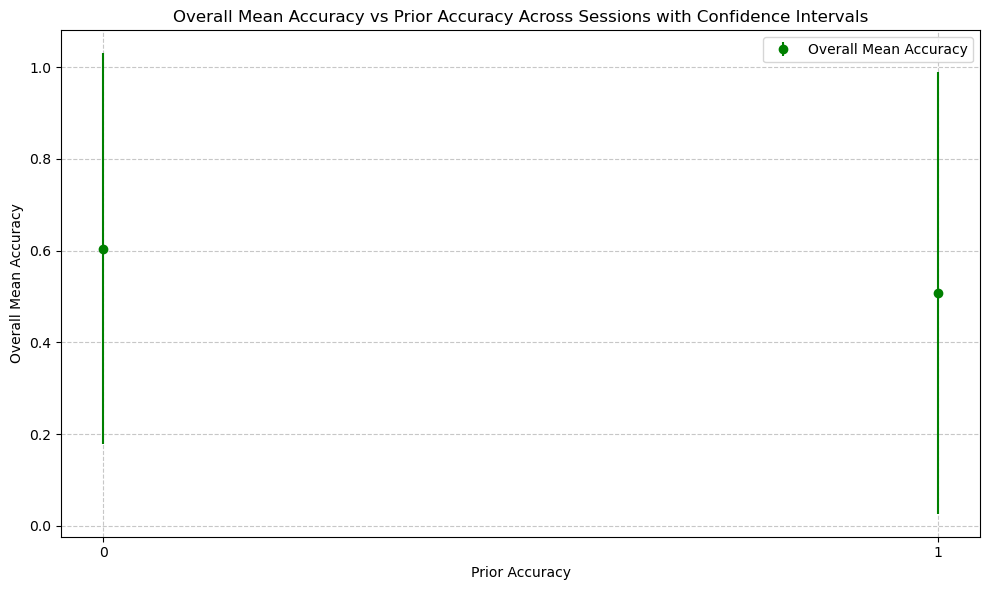

Overall Mean Accuracy per Prior Accuracy Across Sessions:
prior_accuracy
0.0    0.604096
1.0    0.508391
dtype: float64


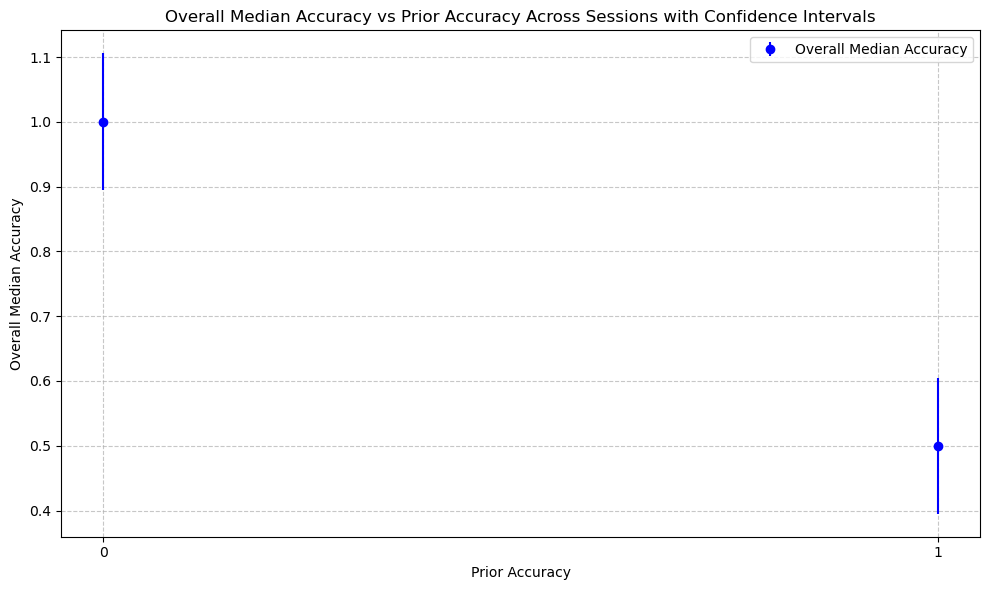


Overall Median Accuracy per Prior Accuracy Across Sessions:
prior_accuracy
0.0    1.0
1.0    0.5
dtype: float64


In [8]:
# Means and medians across sessions 
accuracy_by_prior_accuracy = [group['accuracy'].dropna() for name, group in same_difficulty_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality
for group_name, group_data in same_difficulty_data.groupby('prior_accuracy')['accuracy']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*accuracy_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*accuracy_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_accuracy = same_difficulty_data.groupby(['session', 'prior_accuracy'])['accuracy'].mean().unstack()
session_median_accuracy = same_difficulty_data.groupby(['session', 'prior_accuracy'])['accuracy'].median().unstack()

overall_mean_accuracy = session_mean_accuracy.mean()
overall_median_accuracy = session_median_accuracy.median()

session_std_accuracy = same_difficulty_data.groupby(['session', 'prior_accuracy'])['accuracy'].std().unstack()
session_count_accuracy = same_difficulty_data.groupby(['session', 'prior_accuracy'])['accuracy'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_accuracy.mean() / np.sqrt(session_count_accuracy.mean())

overall_conf_interval_median = 1.96 * session_median_accuracy.std() / np.sqrt(session_median_accuracy.count())

# Mean accuracy across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_accuracy.index, overall_mean_accuracy.values, yerr=overall_conf_interval_mean, fmt='o', color='green', label='Overall Mean Accuracy')
plt.title('Overall Mean Accuracy vs Prior Accuracy Across Sessions with Confidence Intervals')
plt.xlabel('Prior Accuracy')
plt.ylabel('Overall Mean Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(len(overall_mean_accuracy)))
plt.tight_layout()
plt.show()

print("Overall Mean Accuracy per Prior Accuracy Across Sessions:")
print(overall_mean_accuracy)

# Median accuracy across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_accuracy.index, overall_median_accuracy.values, yerr=overall_conf_interval_median, fmt='o', color='blue', label='Overall Median Accuracy')
plt.title('Overall Median Accuracy vs Prior Accuracy Across Sessions with Confidence Intervals')
plt.xlabel('Prior Accuracy')
plt.ylabel('Overall Median Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(len(overall_median_accuracy)))
plt.tight_layout()
plt.show()

print("\nOverall Median Accuracy per Prior Accuracy Across Sessions:")
print(overall_median_accuracy)

Cluster 1 - Shapiro-Wilk test for 0.0: p-value = 4.8540186089431343e-17
Cluster 1 - Shapiro-Wilk test for 1.0: p-value = 9.865852574867364e-18
Cluster 1 - Levene's test for homogeneity of variances: p-value = 0.025689652541863634
Cluster 1 - Kruskal-Wallis test:
H-statistic: 4.957233854507156
p-value: 0.02598173666636223


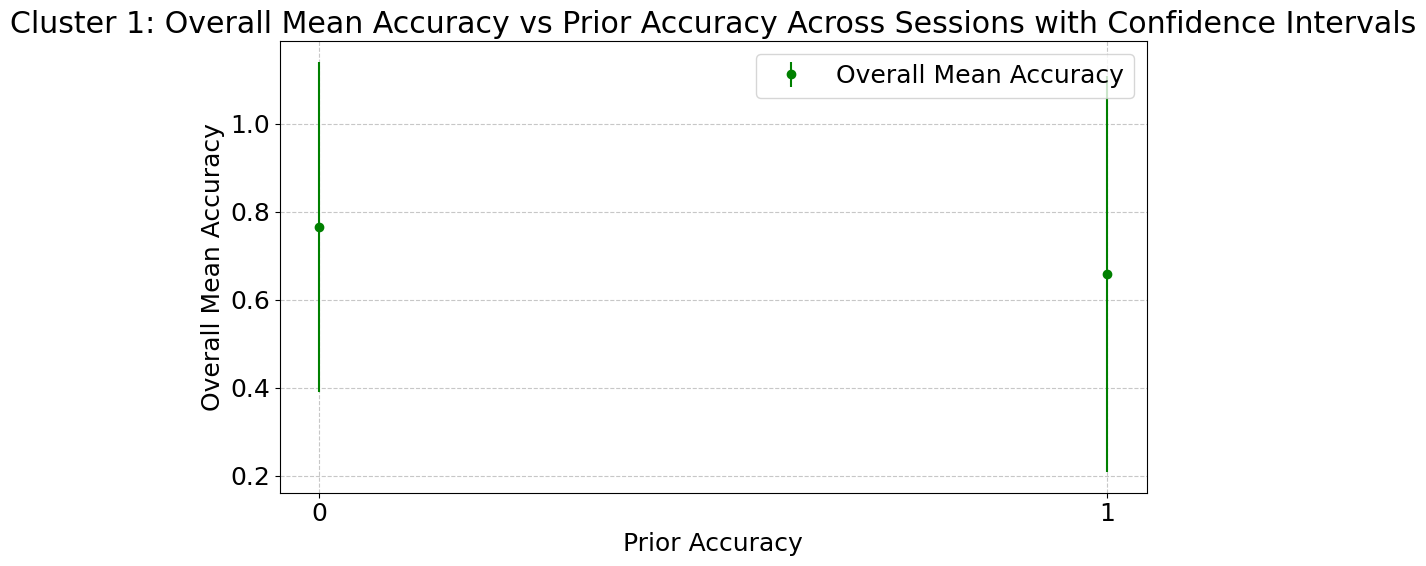

Cluster 1: Overall Mean Accuracy per Prior Accuracy Across Sessions:
prior_accuracy
0.0    0.765968
1.0    0.658309
dtype: float64


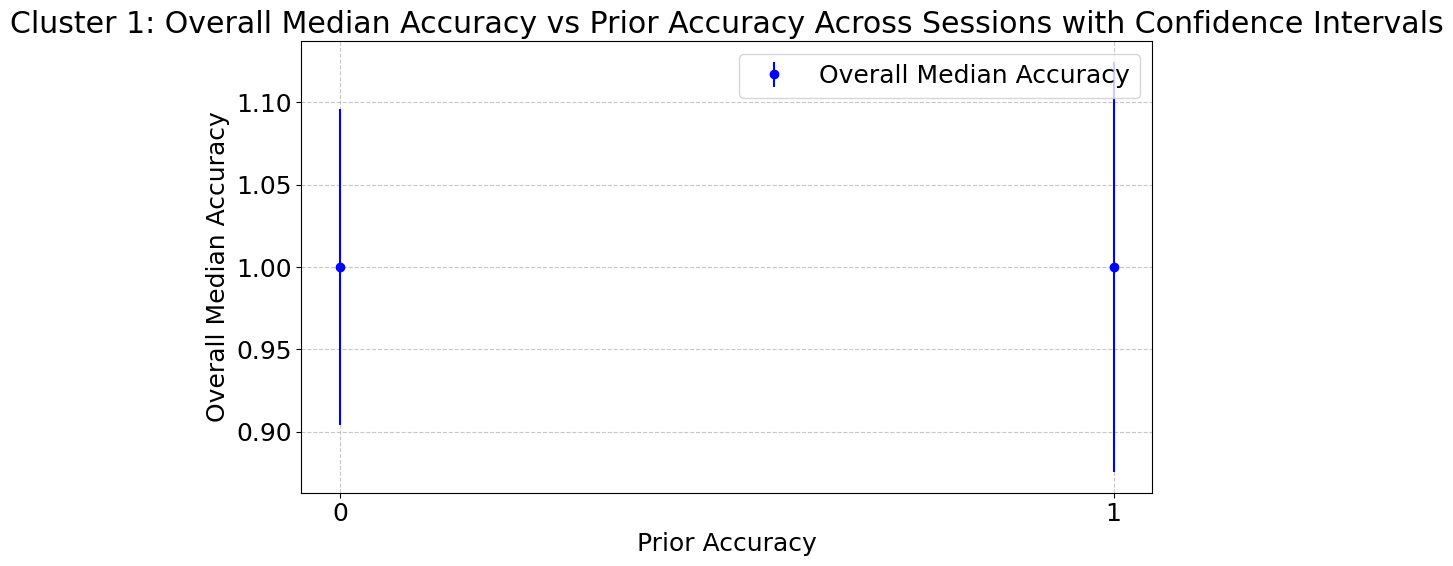


Cluster 1: Overall Median Accuracy per Prior Accuracy Across Sessions:
prior_accuracy
0.0    1.0
1.0    1.0
dtype: float64
Cluster 2 - Shapiro-Wilk test for 0.0: p-value = 9.202026842474209e-18
Cluster 2 - Shapiro-Wilk test for 1.0: p-value = 3.667468972968566e-16
Cluster 2 - Levene's test for homogeneity of variances: p-value = 0.8425599837830381
Cluster 2 - Kruskal-Wallis test:
H-statistic: 0.03966651683143586
p-value: 0.8421340311229264


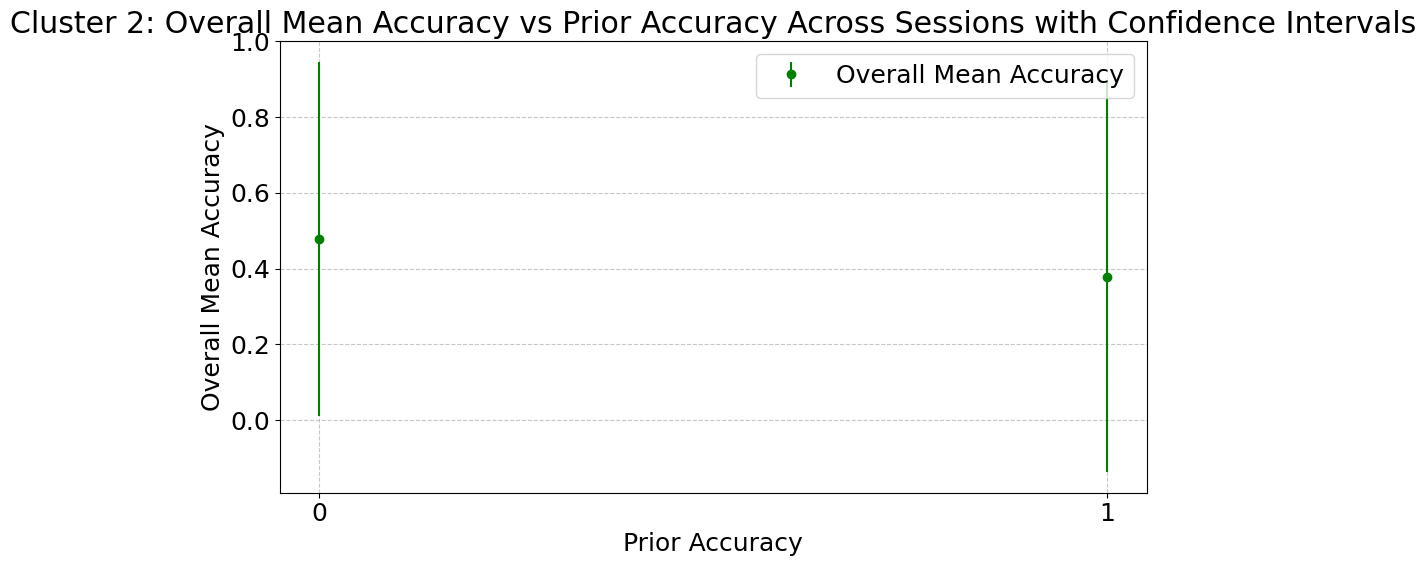

Cluster 2: Overall Mean Accuracy per Prior Accuracy Across Sessions:
prior_accuracy
0.0    0.478196
1.0    0.378732
dtype: float64


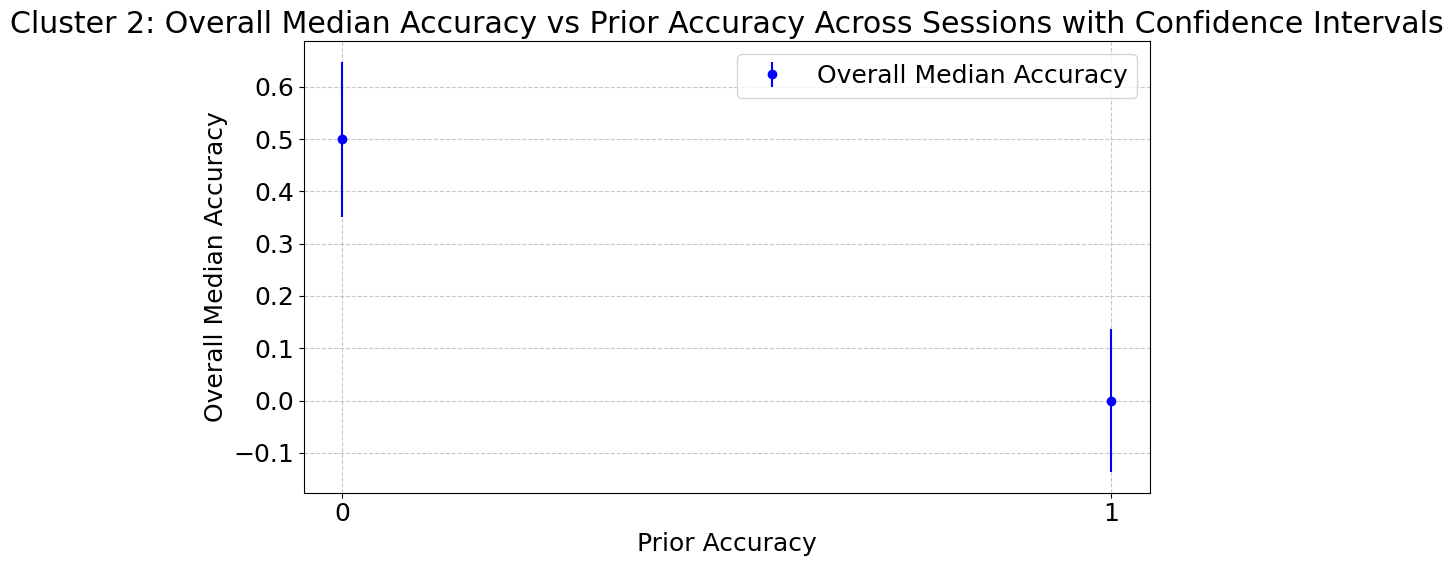


Cluster 2: Overall Median Accuracy per Prior Accuracy Across Sessions:
prior_accuracy
0.0    0.5
1.0    0.0
dtype: float64


In [33]:
#Same analysis for the two clusters

cluster_1_data = same_difficulty_data[same_difficulty_data['session'].isin(sessions_cluster_1)]
cluster_2_data = same_difficulty_data[same_difficulty_data['session'].isin(sessions_cluster_2)]

# Cluster 1
accuracy_by_prior_accuracy_cluster_1 = [group['accuracy'].dropna() for name, group in cluster_1_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 1
for group_name, group_data in cluster_1_data.groupby('prior_accuracy')['accuracy']:
    stat, p = shapiro(group_data)
    print(f"Cluster 1 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 1
stat, p = levene(*accuracy_by_prior_accuracy_cluster_1)
print(f"Cluster 1 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 1
H, p = kruskal(*accuracy_by_prior_accuracy_cluster_1)
print("Cluster 1 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_accuracy_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['accuracy'].mean().unstack()
session_median_accuracy_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['accuracy'].median().unstack()

overall_mean_accuracy_cluster_1 = session_mean_accuracy_cluster_1.mean()
overall_median_accuracy_cluster_1 = session_median_accuracy_cluster_1.median()

session_std_accuracy_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['accuracy'].std().unstack()
session_count_accuracy_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['accuracy'].count().unstack()
overall_conf_interval_mean_cluster_1 = 1.96 * session_std_accuracy_cluster_1.mean() / np.sqrt(session_count_accuracy_cluster_1.mean())

overall_conf_interval_median_cluster_1 = 1.96 * session_median_accuracy_cluster_1.std() / np.sqrt(session_median_accuracy_cluster_1.count())

# Mean accuracy across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_accuracy_cluster_1.index, overall_mean_accuracy_cluster_1.values, yerr=overall_conf_interval_mean_cluster_1, fmt='o', color='green', label='Overall Mean Accuracy')
plt.title('Cluster 1: Overall Mean Accuracy vs Prior Accuracy Across Sessions with Confidence Intervals')
plt.xlabel('Prior Accuracy')
plt.ylabel('Overall Mean Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(len(overall_mean_accuracy_cluster_1)))
plt.tight_layout()
plt.show()

print("Cluster 1: Overall Mean Accuracy per Prior Accuracy Across Sessions:")
print(overall_mean_accuracy_cluster_1)

# Median accuracy across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_accuracy_cluster_1.index, overall_median_accuracy_cluster_1.values, yerr=overall_conf_interval_median_cluster_1, fmt='o', color='blue', label='Overall Median Accuracy')
plt.title('Cluster 1: Overall Median Accuracy vs Prior Accuracy Across Sessions with Confidence Intervals')
plt.xlabel('Prior Accuracy')
plt.ylabel('Overall Median Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(len(overall_median_accuracy_cluster_1)))
plt.tight_layout()
plt.show()

print("\nCluster 1: Overall Median Accuracy per Prior Accuracy Across Sessions:")
print(overall_median_accuracy_cluster_1)

# Cluster 2
accuracy_by_prior_accuracy_cluster_2 = [group['accuracy'].dropna() for name, group in cluster_2_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 2
for group_name, group_data in cluster_2_data.groupby('prior_accuracy')['accuracy']:
    stat, p = shapiro(group_data)
    print(f"Cluster 2 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 2
stat, p = levene(*accuracy_by_prior_accuracy_cluster_2)
print(f"Cluster 2 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 2
H, p = kruskal(*accuracy_by_prior_accuracy_cluster_2)
print("Cluster 2 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_accuracy_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['accuracy'].mean().unstack()
session_median_accuracy_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['accuracy'].median().unstack()

overall_mean_accuracy_cluster_2 = session_mean_accuracy_cluster_2.mean()
overall_median_accuracy_cluster_2 = session_median_accuracy_cluster_2.median()

session_std_accuracy_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['accuracy'].std().unstack()
session_count_accuracy_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['accuracy'].count().unstack()
overall_conf_interval_mean_cluster_2 = 1.96 * session_std_accuracy_cluster_2.mean() / np.sqrt(session_count_accuracy_cluster_2.mean())

overall_conf_interval_median_cluster_2 = 1.96 * session_median_accuracy_cluster_2.std() / np.sqrt(session_median_accuracy_cluster_2.count())

# Mean accuracy across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_accuracy_cluster_2.index, overall_mean_accuracy_cluster_2.values, yerr=overall_conf_interval_mean_cluster_2, fmt='o', color='green', label='Overall Mean Accuracy')
plt.title('Cluster 2: Overall Mean Accuracy vs Prior Accuracy Across Sessions with Confidence Intervals')
plt.xlabel('Prior Accuracy')
plt.ylabel('Overall Mean Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(len(overall_mean_accuracy_cluster_2)))
plt.tight_layout()
plt.show()

print("Cluster 2: Overall Mean Accuracy per Prior Accuracy Across Sessions:")
print(overall_mean_accuracy_cluster_2)

# Median accuracy across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_accuracy_cluster_2.index, overall_median_accuracy_cluster_2.values, yerr=overall_conf_interval_median_cluster_2, fmt='o', color='blue', label='Overall Median Accuracy')
plt.title('Cluster 2: Overall Median Accuracy vs Prior Accuracy Across Sessions with Confidence Intervals')
plt.xlabel('Prior Accuracy')
plt.ylabel('Overall Median Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(len(overall_median_accuracy_cluster_2)))
plt.tight_layout()
plt.show()

print("\nCluster 2: Overall Median Accuracy per Prior Accuracy Across Sessions:")
print(overall_median_accuracy_cluster_2)

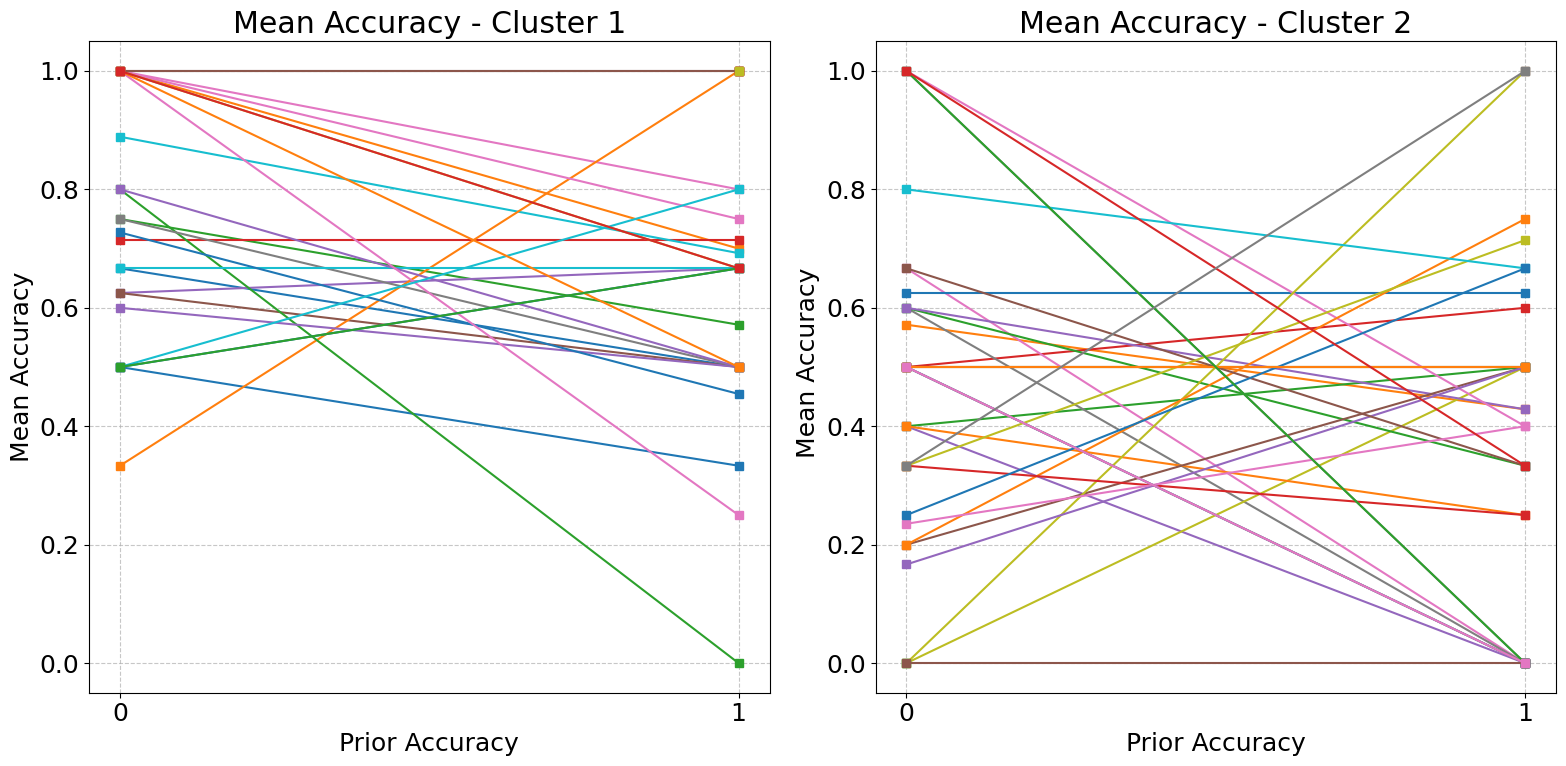

In [9]:
# Accuracy by prior accuracy per session

session_accuracy = same_difficulty_data.groupby(['session', 'prior_accuracy'])['accuracy'].mean().unstack()
cluster_1_sessions = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
cluster_2_sessions = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.rcParams.update({'font.size': 18})

# Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Cluster 1
axes[0].set_title('Mean Accuracy - Cluster 1')
for session in cluster_1_sessions:
    available_prior_accuracy = session_accuracy.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_accuracy_session = session_accuracy.loc[session][available_prior_accuracy]
        axes[0].plot(mean_accuracy_session.index, mean_accuracy_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

axes[0].set_xlabel('Prior Accuracy')
axes[0].set_ylabel('Mean Accuracy')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks(np.arange(len(session_accuracy.columns)))
#axes[0].legend()

# Cluster 2
axes[1].set_title('Mean Accuracy - Cluster 2')
for session in cluster_2_sessions:
    available_prior_accuracy = session_accuracy.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_accuracy_session = session_accuracy.loc[session][available_prior_accuracy]
        axes[1].plot(mean_accuracy_session.index, mean_accuracy_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

axes[1].set_xlabel('Prior Accuracy')
axes[1].set_ylabel(' Mean Accuracy')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks(np.arange(len(session_accuracy.columns)))
#axes[1].legend()

plt.tight_layout()
plt.show()

### Total Trial Duration vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 2.5110984472574035e-13
Shapiro-Wilk test for 1.0: p-value = 4.8565677493061104e-15
Levene's test for homogeneity of variances: p-value = 0.7352457953679263
Kruskal-Wallis test:
H-statistic: 1.952157075101128
p-value: 0.16235459485919368


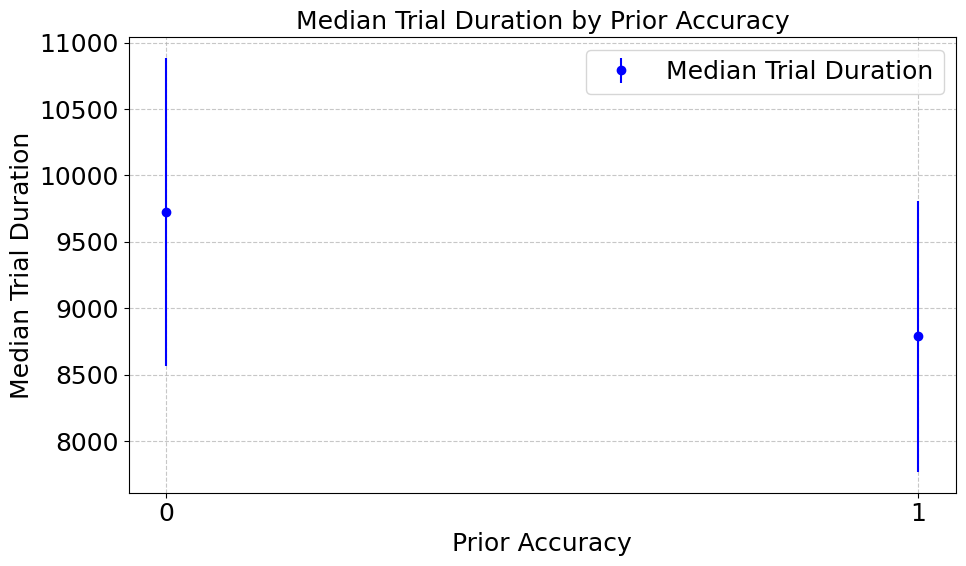


Overall Median Trial Duration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    9725.296875
1.0    8787.565217
dtype: float64


In [10]:
# Means and medians across sessions 

session_median_durPeriodTotal = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].median().unstack()
overall_median_durPeriodTotal = session_median_durPeriodTotal.mean()

session_std_durPeriodTotal = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].std().unstack()
session_count_durPeriodTotal = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_durPeriodTotal.mean() / np.sqrt(session_count_durPeriodTotal.mean())

overall_conf_interval_median = 1.96 * session_median_durPeriodTotal.std() / np.sqrt(session_median_durPeriodTotal.count())

durPeriodTotal_by_prior_accuracy = [group['durPeriodTotal'].dropna() for name, group in same_difficulty_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality
for group_name, group_data in same_difficulty_data.groupby('prior_accuracy')['durPeriodTotal']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*durPeriodTotal_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*durPeriodTotal_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Median trial duration across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_durPeriodTotal.index, overall_median_durPeriodTotal.values, yerr=overall_conf_interval_median, fmt='o', color='blue', label='Median Trial Duration')
plt.title('Median Trial Duration by Prior Accuracy', fontsize=18)
plt.xlabel('Prior Accuracy', fontsize=18)
plt.ylabel('Median Trial Duration', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1], fontsize=18)
plt.tight_layout()
plt.show()

print("\nOverall Median Trial Duration per Prior Accuracy Across Sessions:")
print(overall_median_durPeriodTotal)

Cluster 1 - Shapiro-Wilk test for 0.0: p-value = 4.2140892024705766e-07
Cluster 1 - Shapiro-Wilk test for 1.0: p-value = 8.785096939195008e-10
Cluster 1 - Levene's test for homogeneity of variances: p-value = 0.4901597372733896
Cluster 1 - Kruskal-Wallis test:
H-statistic: 3.1728106342452507
p-value: 0.0748734947486359


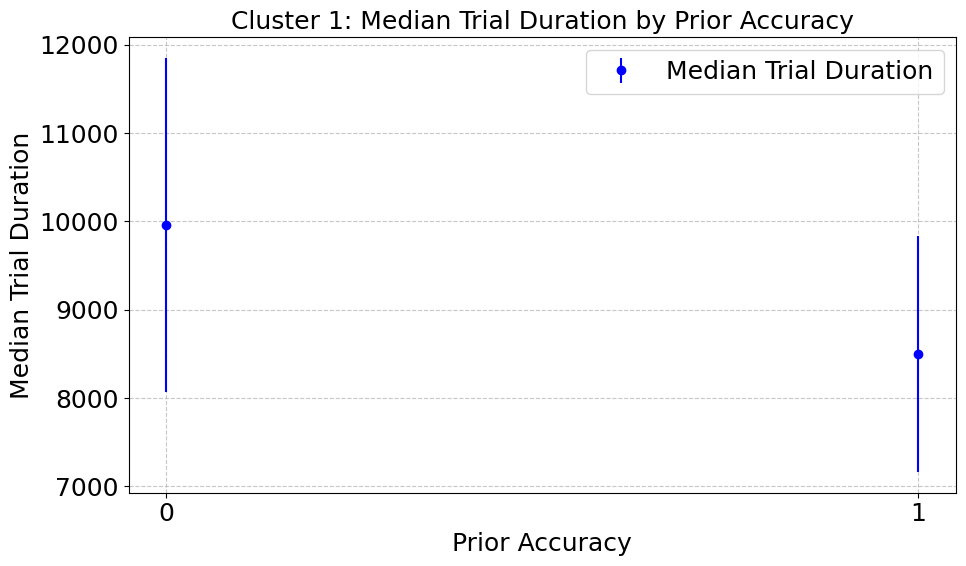


Cluster 1: Overall Median Trial Duration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    9957.071429
1.0    8498.093750
dtype: float64
Cluster 2 - Shapiro-Wilk test for 0.0: p-value = 1.9072114118292998e-10
Cluster 2 - Shapiro-Wilk test for 1.0: p-value = 2.384712230650044e-10
Cluster 2 - Levene's test for homogeneity of variances: p-value = 0.777842106206401
Cluster 2 - Kruskal-Wallis test:
H-statistic: 0.22974773850736413
p-value: 0.6317109396831243


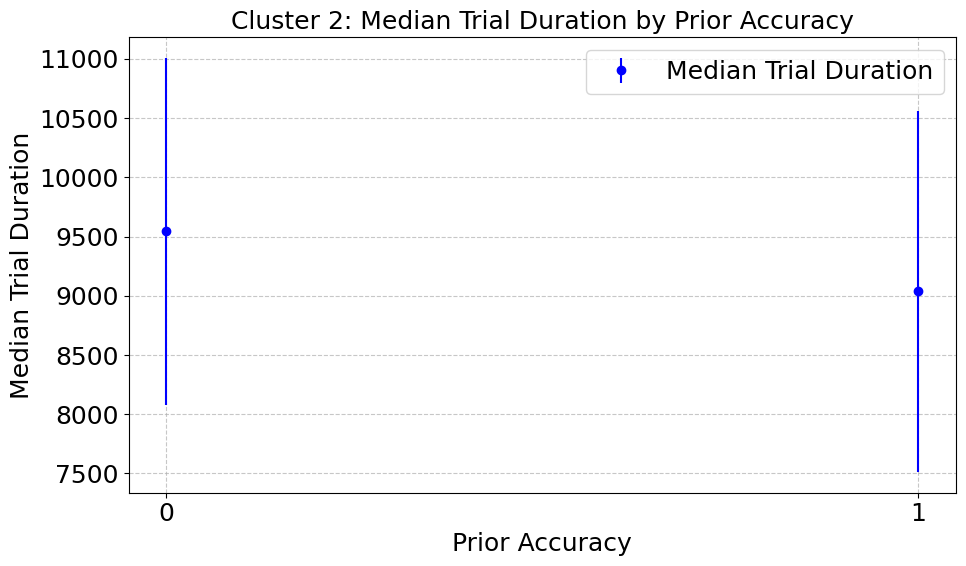


Cluster 2: Overall Median Trial Duration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    9545.027778
1.0    9037.918919
dtype: float64


In [36]:
# Same analysis for each cluster

#Cluster 1

cluster_1_data = same_difficulty_data[same_difficulty_data['session'].isin(sessions_cluster_1)]

session_median_durPeriodTotal_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].median().unstack()
overall_median_durPeriodTotal_cluster_1 = session_median_durPeriodTotal_cluster_1.mean()

session_std_durPeriodTotal_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].std().unstack()
session_count_durPeriodTotal_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].count().unstack()
overall_conf_interval_mean_cluster_1 = 1.96 * session_std_durPeriodTotal_cluster_1.mean() / np.sqrt(session_count_durPeriodTotal_cluster_1.mean())

overall_conf_interval_median_cluster_1 = 1.96 * session_median_durPeriodTotal_cluster_1.std() / np.sqrt(session_median_durPeriodTotal_cluster_1.count())

durPeriodTotal_by_prior_accuracy_cluster_1 = [group['durPeriodTotal'].dropna() for name, group in cluster_1_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 1
for group_name, group_data in cluster_1_data.groupby('prior_accuracy')['durPeriodTotal']:
    stat, p = shapiro(group_data)
    print(f"Cluster 1 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 1
stat, p = levene(*durPeriodTotal_by_prior_accuracy_cluster_1)
print(f"Cluster 1 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 1
H, p = kruskal(*durPeriodTotal_by_prior_accuracy_cluster_1)
print("Cluster 1 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Median trial duration across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_durPeriodTotal_cluster_1.index, overall_median_durPeriodTotal_cluster_1.values, yerr=overall_conf_interval_median_cluster_1, fmt='o', color='blue', label='Median Trial Duration')
plt.title('Cluster 1: Median Trial Duration by Prior Accuracy', fontsize=18)
plt.xlabel('Prior Accuracy', fontsize=18)
plt.ylabel('Median Trial Duration', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1], fontsize=18)
plt.tight_layout()
plt.show()

print("\nCluster 1: Overall Median Trial Duration per Prior Accuracy Across Sessions:")
print(overall_median_durPeriodTotal_cluster_1)

#Cluster 2
cluster_2_data = same_difficulty_data[same_difficulty_data['session'].isin(sessions_cluster_2)]

session_median_durPeriodTotal_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].median().unstack()
overall_median_durPeriodTotal_cluster_2 = session_median_durPeriodTotal_cluster_2.mean()

session_std_durPeriodTotal_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].std().unstack()
session_count_durPeriodTotal_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].count().unstack()
overall_conf_interval_mean_cluster_2 = 1.96 * session_std_durPeriodTotal_cluster_2.mean() / np.sqrt(session_count_durPeriodTotal_cluster_2.mean())

overall_conf_interval_median_cluster_2 = 1.96 * session_median_durPeriodTotal_cluster_2.std() / np.sqrt(session_median_durPeriodTotal_cluster_2.count())

durPeriodTotal_by_prior_accuracy_cluster_2 = [group['durPeriodTotal'].dropna() for name, group in cluster_2_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 2
for group_name, group_data in cluster_2_data.groupby('prior_accuracy')['durPeriodTotal']:
    stat, p = shapiro(group_data)
    print(f"Cluster 2 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 2
stat, p = levene(*durPeriodTotal_by_prior_accuracy_cluster_2)
print(f"Cluster 2 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 2
H, p = kruskal(*durPeriodTotal_by_prior_accuracy_cluster_2)
print("Cluster 2 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Median trial duration across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_durPeriodTotal_cluster_2.index, overall_median_durPeriodTotal_cluster_2.values, yerr=overall_conf_interval_median_cluster_2, fmt='o', color='blue', label='Median Trial Duration')
plt.title('Cluster 2: Median Trial Duration by Prior Accuracy', fontsize=18)
plt.xlabel('Prior Accuracy', fontsize=18)
plt.ylabel('Median Trial Duration', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1], fontsize=18)
plt.tight_layout()
plt.show()

print("\nCluster 2: Overall Median Trial Duration per Prior Accuracy Across Sessions:")
print(overall_median_durPeriodTotal_cluster_2)

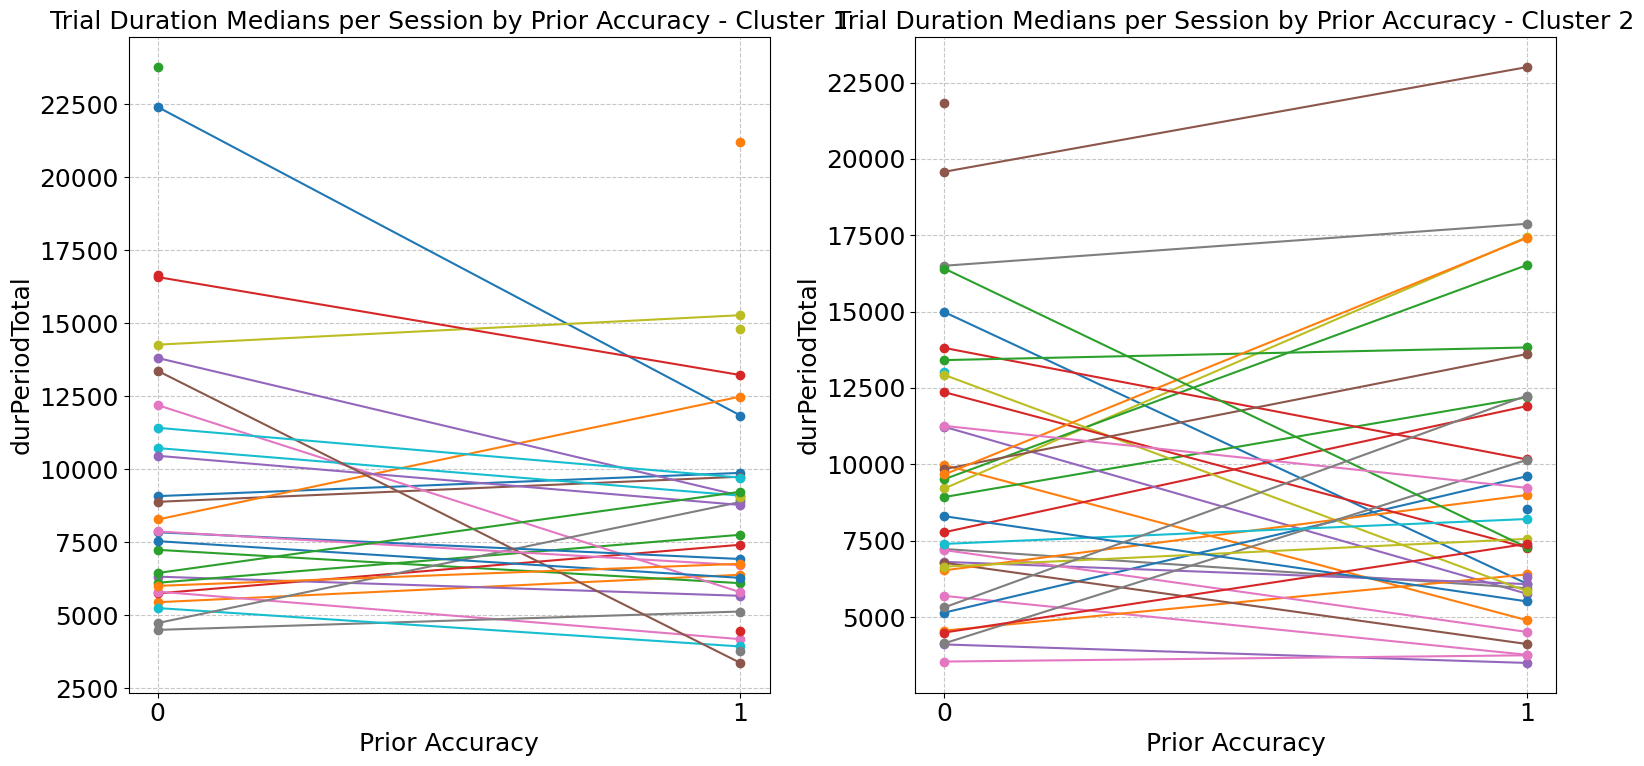

In [11]:
# Trial duration per session by prior accuracy per session

#Medians
session_dur_trial = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].median().unstack()
sessions = data['session'].unique()
cluster_1_sessions = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
cluster_2_sessions = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Cluster 1
axes[0].set_title('Trial Duration Medians per Session by Prior Accuracy - Cluster 1', fontsize=18)
for session in cluster_1_sessions:
    available_prior_accuracy = session_dur_trial.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_durtrial_session = session_dur_trial.loc[session][available_prior_accuracy]
        axes[0].plot(median_durtrial_session.index, median_durtrial_session, marker='o', linestyle='-', label=f'Session {session}')

axes[0].set_xlabel('Prior Accuracy', fontsize=18)
axes[0].set_ylabel('durPeriodTotal', fontsize=18)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks([0, 1])
#axes[0].legend()

# Plot Cluster 2
axes[1].set_title('Trial Duration Medians per Session by Prior Accuracy - Cluster 2', fontsize=18)
for session in cluster_2_sessions:
    available_prior_accuracy = session_dur_trial.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_durtrial_session = session_dur_trial.loc[session][available_prior_accuracy]
        axes[1].plot(median_durtrial_session.index, median_durtrial_session, marker='o', linestyle='-', label=f'Session {session}')

axes[1].set_xlabel('Prior Accuracy', fontsize=18)
axes[1].set_ylabel('durPeriodTotal', fontsize=18)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks([0, 1])
#axes[1].legend()

plt.tight_layout()
plt.show()

### Duration of Exploration and Decision Periods vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 2.4263767729236303e-17
Shapiro-Wilk test for 1.0: p-value = 1.0733152614604847e-17
Levene's test for homogeneity of variances: p-value = 0.9503518150558927
Kruskal-Wallis test:
H-statistic: 0.6426579685008051
p-value: 0.42274994404160204
Shapiro-Wilk test for 0.0: p-value = 6.362586300842879e-19
Shapiro-Wilk test for 1.0: p-value = 1.4286643142030937e-20
Levene's test for homogeneity of variances: p-value = 0.10423241512329395
Kruskal-Wallis test:
H-statistic: 1.9306449308337403
p-value: 0.16468790349292212


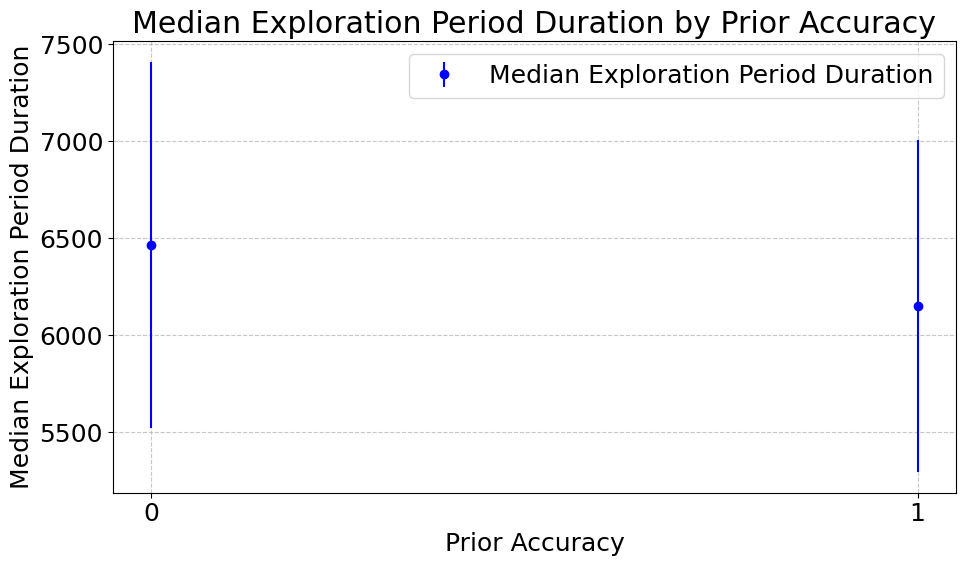


Overall Median Exploration Period Duration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    6465.703125
1.0    6149.000000
dtype: float64


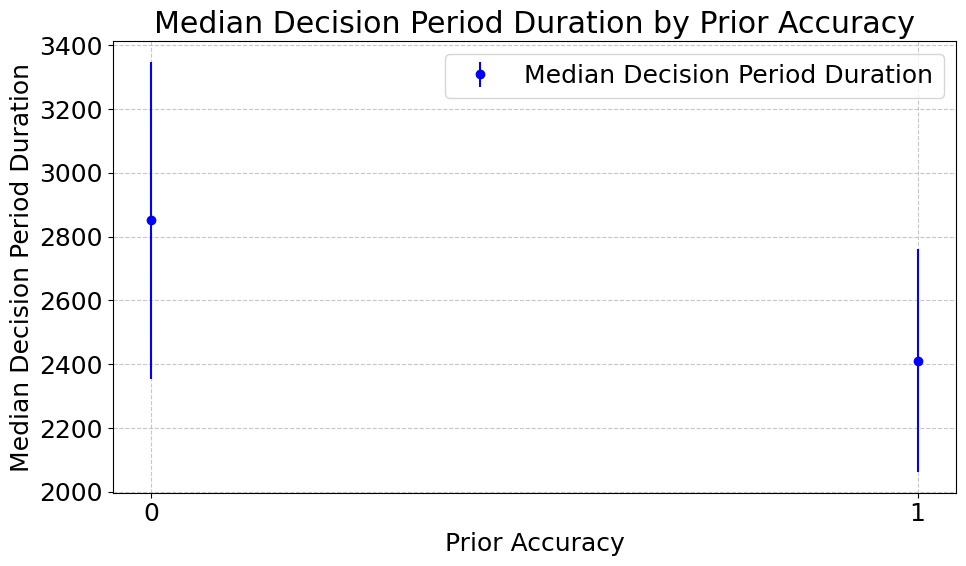


Overall Median Decision Period Duration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    2851.484375
1.0    2411.043478
dtype: float64


In [12]:
#Medians across sessions 

DurExploration_by_prior_accuracy = [group['durExplorationPeriod'].dropna() for name, group in same_difficulty_data.groupby('prior_accuracy')]
DurDecision_by_prior_accuracy = [group['durDecisionPeriod'].dropna() for name, group in same_difficulty_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality - Exploration
for group_name, group_data in same_difficulty_data.groupby('prior_accuracy')['durExplorationPeriod']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances - Exploration
stat, p = levene(*DurExploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test - Exploration
H, p = kruskal(*DurExploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Shapiro-Wilk test for normality - Decision
for group_name, group_data in same_difficulty_data.groupby('prior_accuracy')['durDecisionPeriod']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances - Decision
stat, p = levene(*DurDecision_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test - Decision
H, p = kruskal(*DurDecision_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_exp_period = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].median().unstack()
overall_median_exp_period = session_median_exp_period.mean()

session_std_exp_period = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].std().unstack()
session_count_exp_period = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_exp_period.mean() / np.sqrt(session_count_exp_period.mean())

overall_conf_interval_median = 1.96 * session_median_exp_period.std() / np.sqrt(session_median_exp_period.count())

# Median exploration period duration sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_period.index, overall_median_exp_period.values, yerr=overall_conf_interval_median, fmt='o', color='blue', label='Median Exploration Period Duration')
plt.title('Median Exploration Period Duration by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Exploration Period Duration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nOverall Median Exploration Period Duration per Prior Accuracy Across Sessions:")
print(overall_median_exp_period)

session_median_dec_period = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].median().unstack()
overall_median_dec_period = session_median_dec_period.mean()

session_std_dec_period = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].std().unstack()
session_count_dec_period = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_dec_period.mean() / np.sqrt(session_count_dec_period.mean())

overall_conf_interval_median = 1.96 * session_median_dec_period.std() / np.sqrt(session_median_dec_period.count())

# Median decision period duration sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_period.index, overall_median_dec_period.values, yerr=overall_conf_interval_median, fmt='o', color='blue', label='Median Decision Period Duration')
plt.title('Median Decision Period Duration by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Decision Period Duration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nOverall Median Decision Period Duration per Prior Accuracy Across Sessions:")
print(overall_median_dec_period)

Cluster 1 - Shapiro-Wilk test for durExplorationPeriod 0.0: p-value = 1.5283858420027492e-10
Cluster 1 - Shapiro-Wilk test for durExplorationPeriod 1.0: p-value = 3.718633429183478e-12
Cluster 1 - Levene's test for homogeneity of variances (durExplorationPeriod): p-value = 0.47243123624921357
Cluster 1 - Kruskal-Wallis test (durExplorationPeriod):
H-statistic: 1.5375883947177287
p-value: 0.21497712500370644
Cluster 1 - Shapiro-Wilk test for durDecisionPeriod 0.0: p-value = 2.0158959979435972e-10
Cluster 1 - Shapiro-Wilk test for durDecisionPeriod 1.0: p-value = 3.314273012231671e-14
Cluster 1 - Levene's test for homogeneity of variances (durDecisionPeriod): p-value = 0.11355402181631302
Cluster 1 - Kruskal-Wallis test (durDecisionPeriod):
H-statistic: 2.345808520931934
p-value: 0.12562036959566372


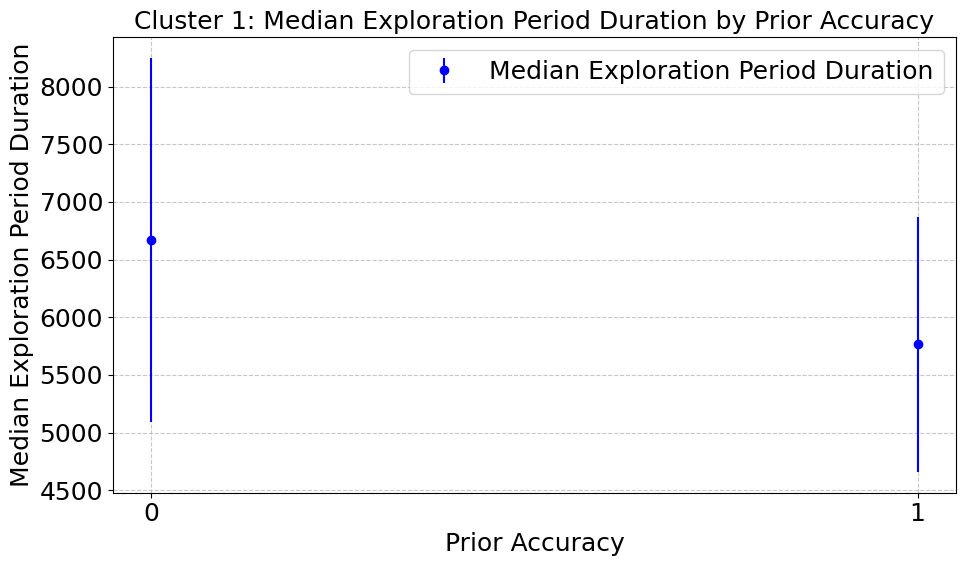


Cluster 1: Overall Median Exploration Period Duration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    6670.321429
1.0    5764.468750
dtype: float64


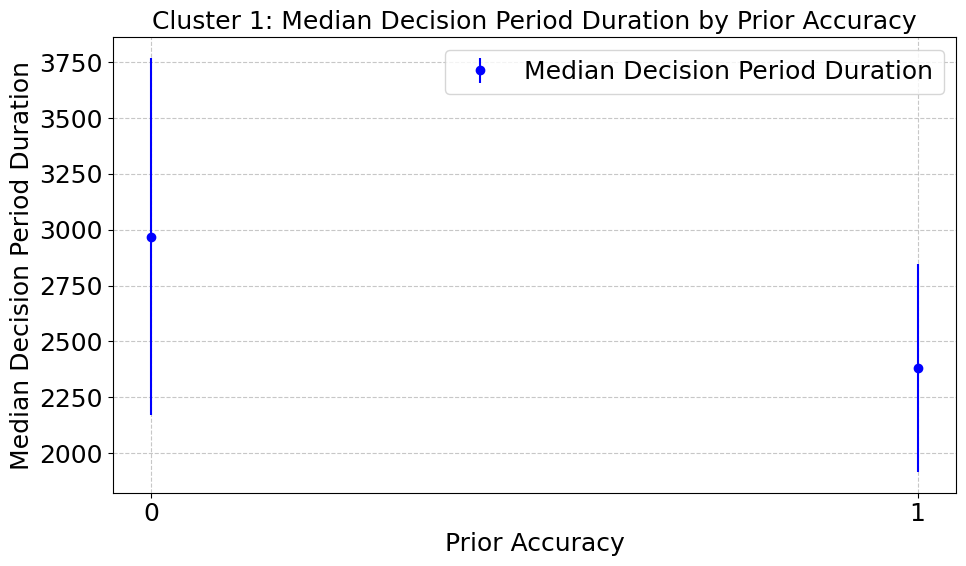


Cluster 1: Overall Median Decision Period Duration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    2969.464286
1.0    2380.656250
dtype: float64
Cluster 2 - Shapiro-Wilk test for durExplorationPeriod 0.0: p-value = 4.1148738597114364e-13
Cluster 2 - Shapiro-Wilk test for durExplorationPeriod 1.0: p-value = 4.075338365003813e-12
Cluster 2 - Levene's test for homogeneity of variances (durExplorationPeriod): p-value = 0.5888891756253782
Cluster 2 - Kruskal-Wallis test (durExplorationPeriod):
H-statistic: 0.0005770392420711045
p-value: 0.9808353465695576
Cluster 2 - Shapiro-Wilk test for durDecisionPeriod 0.0: p-value = 1.6090249545662184e-15
Cluster 2 - Shapiro-Wilk test for durDecisionPeriod 1.0: p-value = 1.0338262461680852e-14
Cluster 2 - Levene's test for homogeneity of variances (durDecisionPeriod): p-value = 0.39866120778720915
Cluster 2 - Kruskal-Wallis test (durDecisionPeriod):
H-statistic: 0.7111395669519935
p-value: 0.3990657626864914


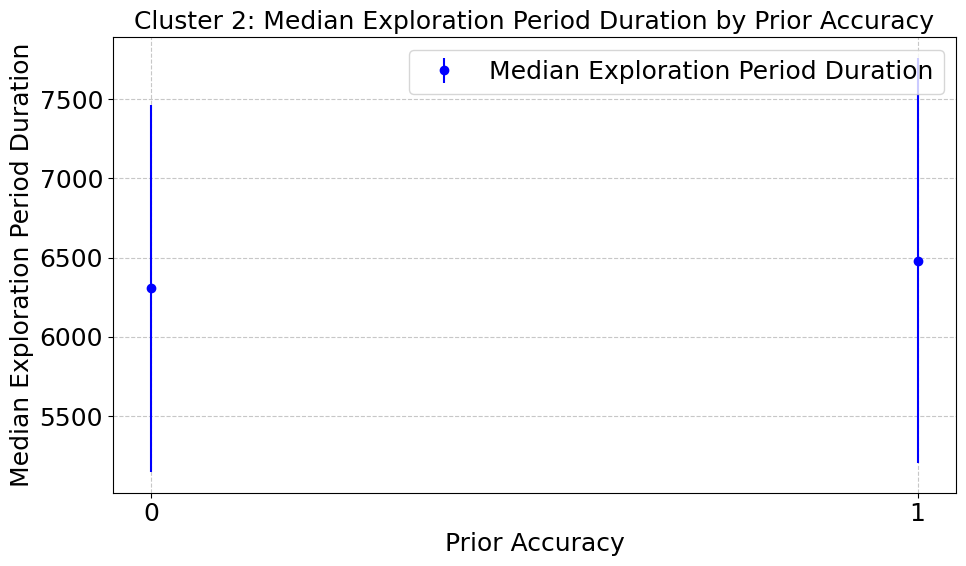


Cluster 2: Overall Median Exploration Period Duration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    6306.555556
1.0    6481.567568
dtype: float64


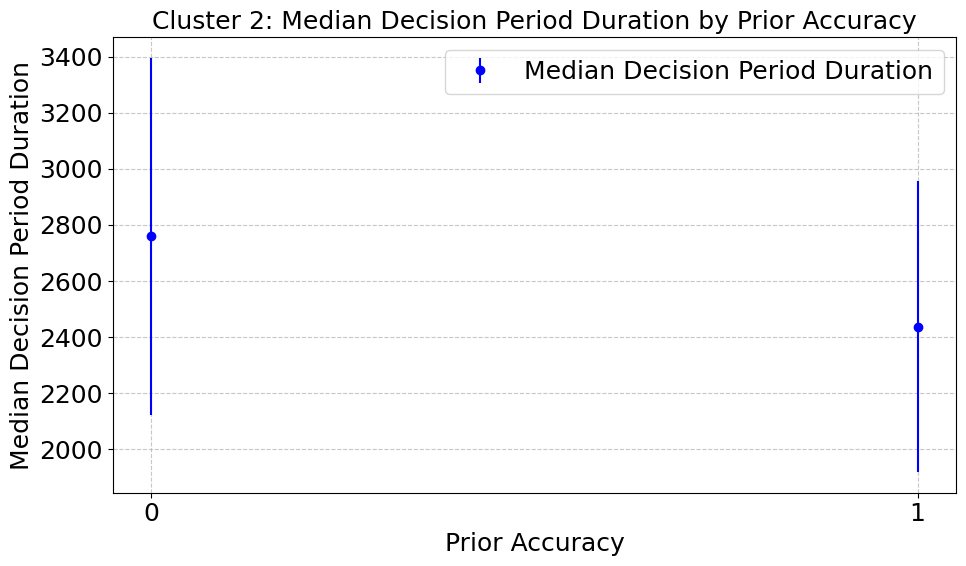


Cluster 2: Overall Median Decision Period Duration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    2759.722222
1.0    2437.324324
dtype: float64


In [38]:
# Same analysis for each cluster

#cluster 1

cluster_1_data = same_difficulty_data[same_difficulty_data['session'].isin(sessions_cluster_1)]

# DurExplorationPeriod Analysis for Cluster 1
DurExploration_by_prior_accuracy_cluster_1 = [group['durExplorationPeriod'].dropna() for name, group in cluster_1_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality - Exploration for Cluster 1
for group_name, group_data in cluster_1_data.groupby('prior_accuracy')['durExplorationPeriod']:
    stat, p = shapiro(group_data)
    print(f"Cluster 1 - Shapiro-Wilk test for durExplorationPeriod {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances - Exploration for Cluster 1
stat, p = levene(*DurExploration_by_prior_accuracy_cluster_1)
print(f"Cluster 1 - Levene's test for homogeneity of variances (durExplorationPeriod): p-value = {p}")

# Kruskal-Wallis test - Exploration for Cluster 1
H, p = kruskal(*DurExploration_by_prior_accuracy_cluster_1)
print("Cluster 1 - Kruskal-Wallis test (durExplorationPeriod):")
print("H-statistic:", H)
print("p-value:", p)

# DurDecisionPeriod Analysis for Cluster 1
DurDecision_by_prior_accuracy_cluster_1 = [group['durDecisionPeriod'].dropna() for name, group in cluster_1_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality - Decision for Cluster 1
for group_name, group_data in cluster_1_data.groupby('prior_accuracy')['durDecisionPeriod']:
    stat, p = shapiro(group_data)
    print(f"Cluster 1 - Shapiro-Wilk test for durDecisionPeriod {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances - Decision for Cluster 1
stat, p = levene(*DurDecision_by_prior_accuracy_cluster_1)
print(f"Cluster 1 - Levene's test for homogeneity of variances (durDecisionPeriod): p-value = {p}")

# Kruskal-Wallis test - Decision for Cluster 1
H, p = kruskal(*DurDecision_by_prior_accuracy_cluster_1)
print("Cluster 1 - Kruskal-Wallis test (durDecisionPeriod):")
print("H-statistic:", H)
print("p-value:", p)

# Median Exploration Period Analysis for Cluster 1
session_median_exp_period_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].median().unstack()
overall_median_exp_period_cluster_1 = session_median_exp_period_cluster_1.mean()

session_std_exp_period_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].std().unstack()
session_count_exp_period_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].count().unstack()
overall_conf_interval_median_exp_cluster_1 = 1.96 * session_median_exp_period_cluster_1.std() / np.sqrt(session_median_exp_period_cluster_1.count())

# Median exploration period duration across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_period_cluster_1.index, overall_median_exp_period_cluster_1.values, yerr=overall_conf_interval_median_exp_cluster_1, fmt='o', color='blue', label='Median Exploration Period Duration')
plt.title('Cluster 1: Median Exploration Period Duration by Prior Accuracy', fontsize=18)
plt.xlabel('Prior Accuracy', fontsize=18)
plt.ylabel('Median Exploration Period Duration', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1], fontsize=18)
plt.tight_layout()
plt.show()

print("\nCluster 1: Overall Median Exploration Period Duration per Prior Accuracy Across Sessions:")
print(overall_median_exp_period_cluster_1)

# Median Decision Period Analysis for Cluster 1
session_median_dec_period_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].median().unstack()
overall_median_dec_period_cluster_1 = session_median_dec_period_cluster_1.mean()

session_std_dec_period_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].std().unstack()
session_count_dec_period_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].count().unstack()
overall_conf_interval_median_dec_cluster_1 = 1.96 * session_median_dec_period_cluster_1.std() / np.sqrt(session_median_dec_period_cluster_1.count())

# Median decision period duration across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_period_cluster_1.index, overall_median_dec_period_cluster_1.values, yerr=overall_conf_interval_median_dec_cluster_1, fmt='o', color='blue', label='Median Decision Period Duration')
plt.title('Cluster 1: Median Decision Period Duration by Prior Accuracy', fontsize=18)
plt.xlabel('Prior Accuracy', fontsize=18)
plt.ylabel('Median Decision Period Duration', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1], fontsize=18)
plt.tight_layout()
plt.show()

print("\nCluster 1: Overall Median Decision Period Duration per Prior Accuracy Across Sessions:")
print(overall_median_dec_period_cluster_1)


# Cluster 2
cluster_2_data = same_difficulty_data[same_difficulty_data['session'].isin(sessions_cluster_2)]

# DurExplorationPeriod Analysis for Cluster 2
DurExploration_by_prior_accuracy_cluster_2 = [group['durExplorationPeriod'].dropna() for name, group in cluster_2_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality - Exploration for Cluster 2
for group_name, group_data in cluster_2_data.groupby('prior_accuracy')['durExplorationPeriod']:
    stat, p = shapiro(group_data)
    print(f"Cluster 2 - Shapiro-Wilk test for durExplorationPeriod {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances - Exploration for Cluster 2
stat, p = levene(*DurExploration_by_prior_accuracy_cluster_2)
print(f"Cluster 2 - Levene's test for homogeneity of variances (durExplorationPeriod): p-value = {p}")

# Kruskal-Wallis test - Exploration for Cluster 2
H, p = kruskal(*DurExploration_by_prior_accuracy_cluster_2)
print("Cluster 2 - Kruskal-Wallis test (durExplorationPeriod):")
print("H-statistic:", H)
print("p-value:", p)

# DurDecisionPeriod Analysis for Cluster 2
DurDecision_by_prior_accuracy_cluster_2 = [group['durDecisionPeriod'].dropna() for name, group in cluster_2_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality - Decision for Cluster 2
for group_name, group_data in cluster_2_data.groupby('prior_accuracy')['durDecisionPeriod']:
    stat, p = shapiro(group_data)
    print(f"Cluster 2 - Shapiro-Wilk test for durDecisionPeriod {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances - Decision for Cluster 2
stat, p = levene(*DurDecision_by_prior_accuracy_cluster_2)
print(f"Cluster 2 - Levene's test for homogeneity of variances (durDecisionPeriod): p-value = {p}")

# Kruskal-Wallis test - Decision for Cluster 2
H, p = kruskal(*DurDecision_by_prior_accuracy_cluster_2)
print("Cluster 2 - Kruskal-Wallis test (durDecisionPeriod):")
print("H-statistic:", H)
print("p-value:", p)

# Median Exploration Period Analysis for Cluster 2
session_median_exp_period_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].median().unstack()
overall_median_exp_period_cluster_2 = session_median_exp_period_cluster_2.mean()

session_std_exp_period_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].std().unstack()
session_count_exp_period_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].count().unstack()
overall_conf_interval_median_exp_cluster_2 = 1.96 * session_median_exp_period_cluster_2.std() / np.sqrt(session_median_exp_period_cluster_2.count())

# Median exploration period duration across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_period_cluster_2.index, overall_median_exp_period_cluster_2.values, yerr=overall_conf_interval_median_exp_cluster_2, fmt='o', color='blue', label='Median Exploration Period Duration')
plt.title('Cluster 2: Median Exploration Period Duration by Prior Accuracy', fontsize=18)
plt.xlabel('Prior Accuracy', fontsize=18)
plt.ylabel('Median Exploration Period Duration', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1], fontsize=18)
plt.tight_layout()
plt.show()

print("\nCluster 2: Overall Median Exploration Period Duration per Prior Accuracy Across Sessions:")
print(overall_median_exp_period_cluster_2)

# Median Decision Period Analysis for Cluster 2
session_median_dec_period_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].median().unstack()
overall_median_dec_period_cluster_2 = session_median_dec_period_cluster_2.mean()

session_std_dec_period_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].std().unstack()
session_count_dec_period_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].count().unstack()
overall_conf_interval_median_dec_cluster_2 = 1.96 * session_median_dec_period_cluster_2.std() / np.sqrt(session_median_dec_period_cluster_2.count())

# Median decision period duration across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_period_cluster_2.index, overall_median_dec_period_cluster_2.values, yerr=overall_conf_interval_median_dec_cluster_2, fmt='o', color='blue', label='Median Decision Period Duration')
plt.title('Cluster 2: Median Decision Period Duration by Prior Accuracy', fontsize=18)
plt.xlabel('Prior Accuracy', fontsize=18)
plt.ylabel('Median Decision Period Duration', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1], fontsize=18)
plt.tight_layout()
plt.show()

print("\nCluster 2: Overall Median Decision Period Duration per Prior Accuracy Across Sessions:")
print(overall_median_dec_period_cluster_2)

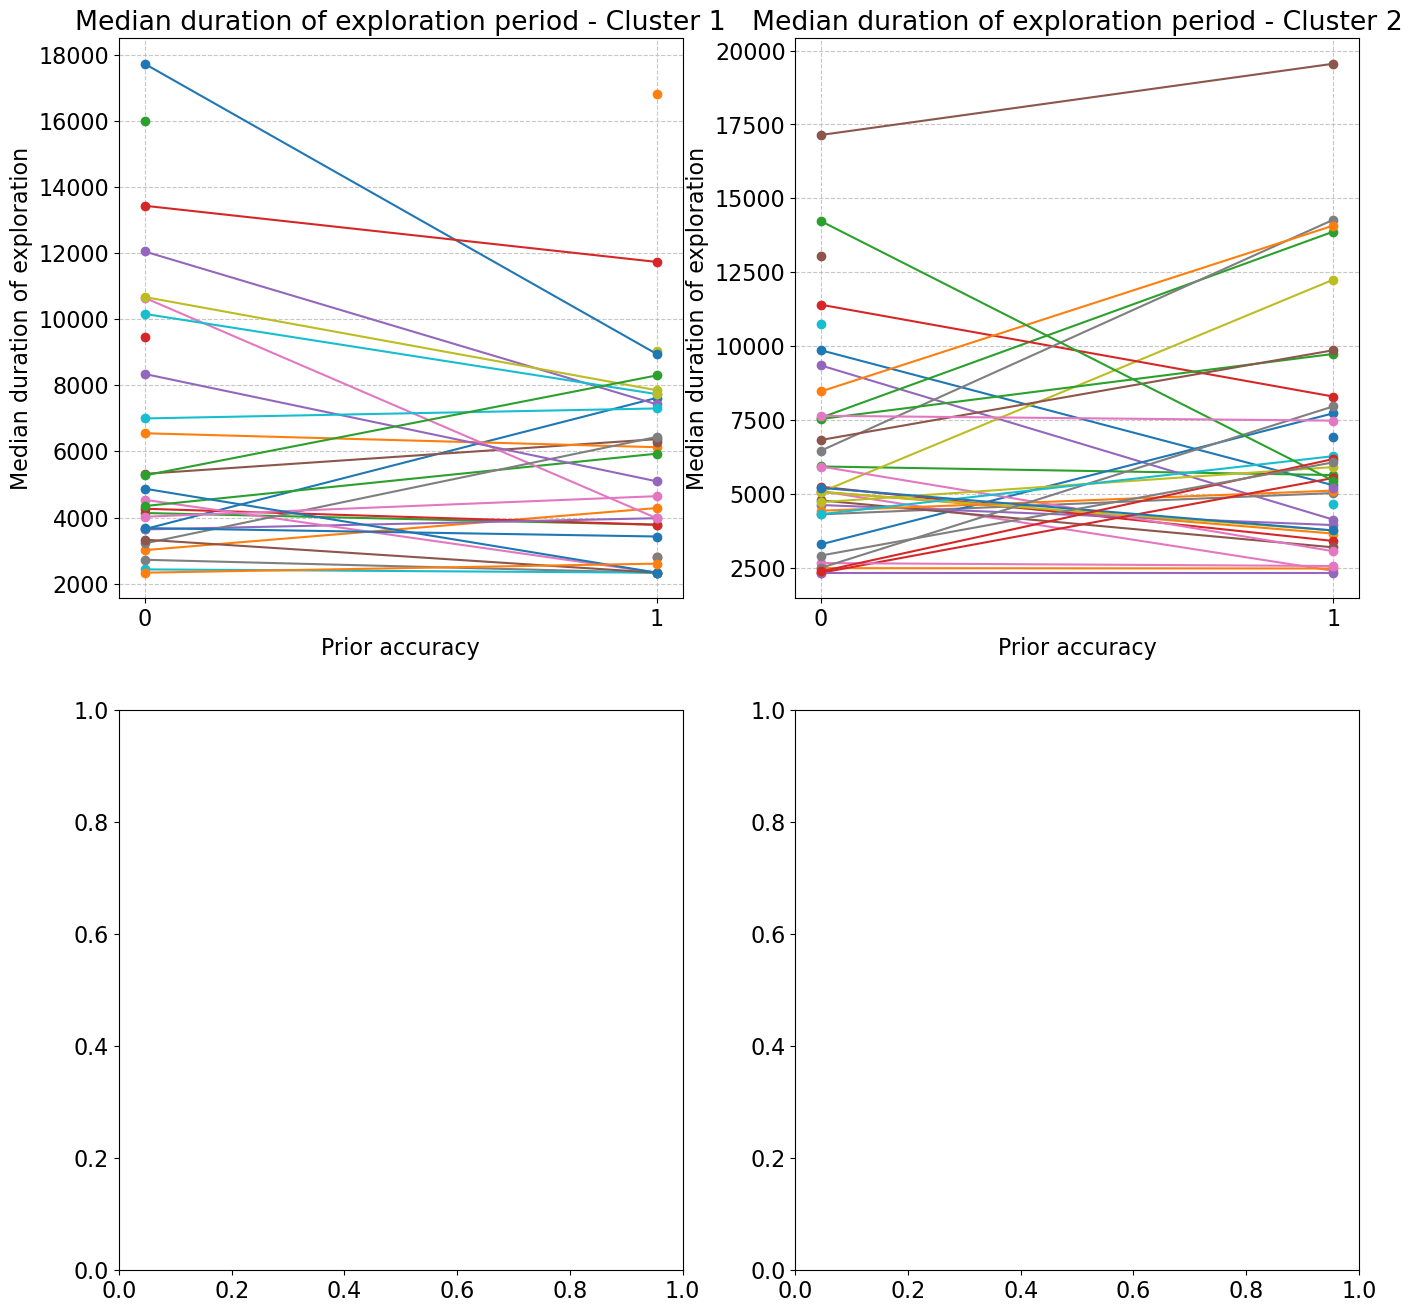

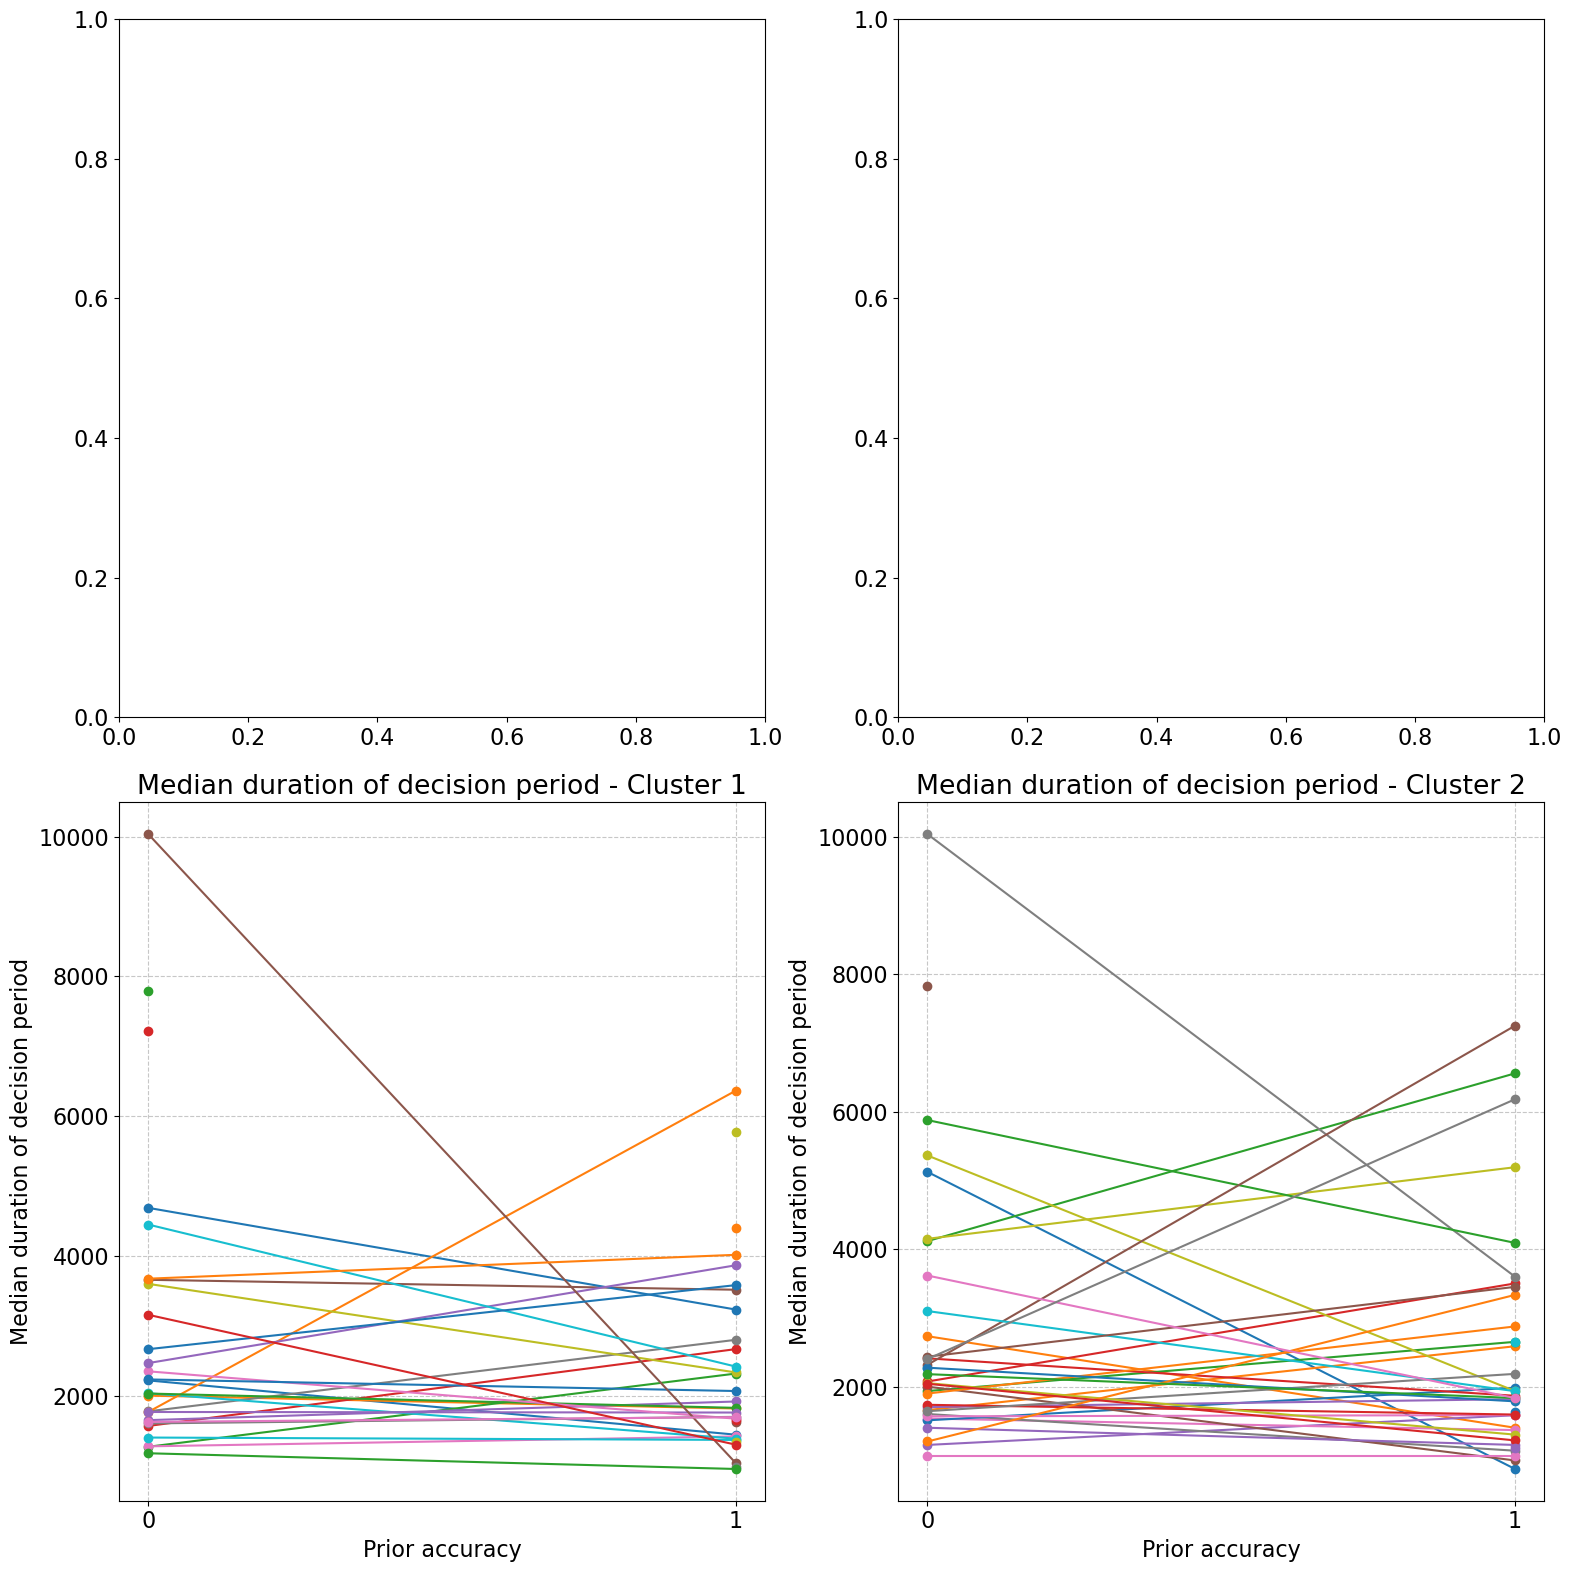

In [13]:
# Duration of both exploration and decision periods vs. prior accuracy per session

# Median durExplorationPeriod per session by prior accuracy 
durExplorationPeriod_per_trial_prior_accuracy = same_difficulty_data.groupby(['session', 'trialno', 'prior_accuracy'])['durExplorationPeriod'].sum().reset_index()
durExplorationPeriod_per_trial_prior_accuracy.dropna(inplace=True)
median_durExplorationPeriod_per_session_prior_accuracy = durExplorationPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].median().unstack()

durDecisionPeriod_per_trial_prior_accuracy = same_difficulty_data.groupby(['session', 'trialno', 'prior_accuracy'])['durDecisionPeriod'].sum().reset_index()
durDecisionPeriod_per_trial_prior_accuracy.dropna(inplace=True)
median_durDecisionPeriod_per_session_prior_accuracy = durDecisionPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].median().unstack()

cluster_1_sessions = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
cluster_2_sessions = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot Cluster 1
axes[0, 0].set_title('Median duration of exploration period - Cluster 1')
for session in cluster_1_sessions:
    session_data = median_durExplorationPeriod_per_session_prior_accuracy.loc[session].dropna()
    axes[0, 0].plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
axes[0, 0].set_xlabel('Prior accuracy')
axes[0, 0].set_ylabel('Median duration of exploration')
axes[0, 0].set_xticks([0, 1]) 
axes[0, 0].grid(True, linestyle='--', alpha=0.7)
#axes[0, 0].legend()

# Plot Cluster 2
axes[0, 1].set_title('Median duration of exploration period - Cluster 2')
for session in cluster_2_sessions:
    session_data = median_durExplorationPeriod_per_session_prior_accuracy.loc[session].dropna()
    axes[0, 1].plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
axes[0, 1].set_xlabel('Prior accuracy')
axes[0, 1].set_ylabel('Median duration of exploration')
axes[0, 1].set_xticks([0, 1]) 
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
#axes[0, 1].legend()

# Median durDecisionPeriod per session by prior accuracy
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot Cluster 1
axes[1, 0].set_title('Median duration of decision period - Cluster 1')
for session in cluster_1_sessions:
    session_data = median_durDecisionPeriod_per_session_prior_accuracy.loc[session].dropna()
    axes[1, 0].plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
axes[1, 0].set_xlabel('Prior accuracy')
axes[1, 0].set_ylabel('Median duration of decision period')
axes[1, 0].set_xticks([0, 1]) 
axes[1, 0].grid(True, linestyle='--', alpha=0.7)
#axes[1, 0].legend()

# Plot Cluster 2
axes[1, 1].set_title('Median duration of decision period - Cluster 2')
for session in cluster_2_sessions:
    session_data = median_durDecisionPeriod_per_session_prior_accuracy.loc[session].dropna()
    axes[1, 1].plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
axes[1, 1].set_xlabel('Prior accuracy')
axes[1, 1].set_ylabel('Median duration of decision period')
axes[1, 1].set_xticks([0, 1]) 
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
#axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Number of fixations of bottom cards during exploration vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.0328102743578771e-15
Shapiro-Wilk test for 1.0: p-value = 1.6069172659302014e-13
Levene's test for homogeneity of variances: p-value = 0.8661243361995143
Kruskal-Wallis test:
H-statistic: 0.7210126209350776
p-value: 0.39581195190057505


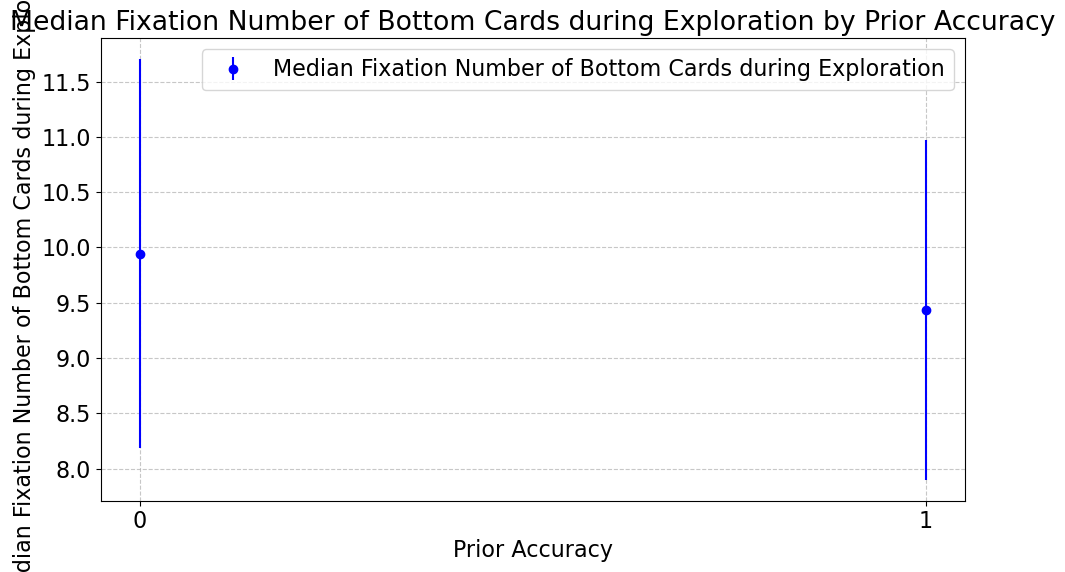


Overall Median Fixation Number of Bottom Cards during Exploration Period per Prior Accuracy Across Sessions:
prior_accuracy
0.0    9.945312
1.0    9.434783
dtype: float64


In [14]:
# Means and medians across sessions

FixNbInBottomExploration_by_prior_accuracy = [group['FixNbInBottomExploration'].dropna() for name, group in same_difficulty_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality
for group_name, group_data in same_difficulty_data.groupby('prior_accuracy')['FixNbInBottomExploration']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*FixNbInBottomExploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*FixNbInBottomExploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_exp_FixNbInBottom = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].median().unstack()

overall_median_exp_FixNbInBottom = session_median_exp_FixNbInBottom.mean()

session_std_exp_FixNbInBottom = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].std().unstack()
session_count_exp_FixNbInBottom = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_exp_FixNbInBottom.mean() / np.sqrt(session_count_exp_FixNbInBottom.mean())

overall_conf_interval_median = 1.96 * session_median_exp_FixNbInBottom.std() / np.sqrt(session_median_exp_FixNbInBottom.count())

# Median exploration fixation number of bottom cards across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_FixNbInBottom.index, overall_median_exp_FixNbInBottom.values, yerr=overall_conf_interval_median, fmt='o', color='blue', label='Median Fixation Number of Bottom Cards during Exploration')
plt.title('Median Fixation Number of Bottom Cards during Exploration by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Number of Bottom Cards during Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nOverall Median Fixation Number of Bottom Cards during Exploration Period per Prior Accuracy Across Sessions:")
print(overall_median_exp_FixNbInBottom)

Cluster 1 - Shapiro-Wilk test for 0.0: p-value = 8.137149460270957e-11
Cluster 1 - Shapiro-Wilk test for 1.0: p-value = 1.6692397787698993e-08
Cluster 1 - Levene's test for homogeneity of variances: p-value = 0.9309279062988779
Cluster 1 - Kruskal-Wallis test:
H-statistic: 1.3332583958790527
p-value: 0.24822637202702486


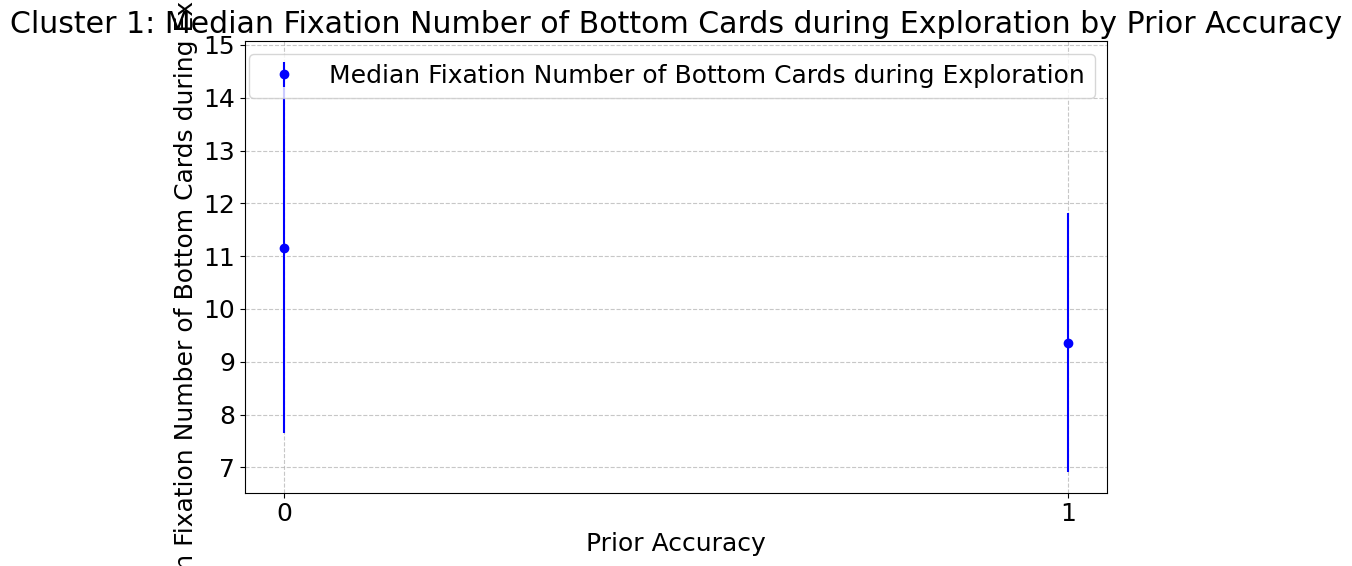


Cluster 1: Overall Median Fixation Number of Bottom Cards during Exploration Period per Prior Accuracy Across Sessions:
prior_accuracy
0.0    11.160714
1.0     9.359375
dtype: float64
Cluster 2 - Shapiro-Wilk test for 0.0: p-value = 6.174505082235762e-09
Cluster 2 - Shapiro-Wilk test for 1.0: p-value = 5.563173536374959e-10
Cluster 2 - Levene's test for homogeneity of variances: p-value = 0.9851790068475967
Cluster 2 - Kruskal-Wallis test:
H-statistic: 9.64165194457044e-06
p-value: 0.9975224918689919


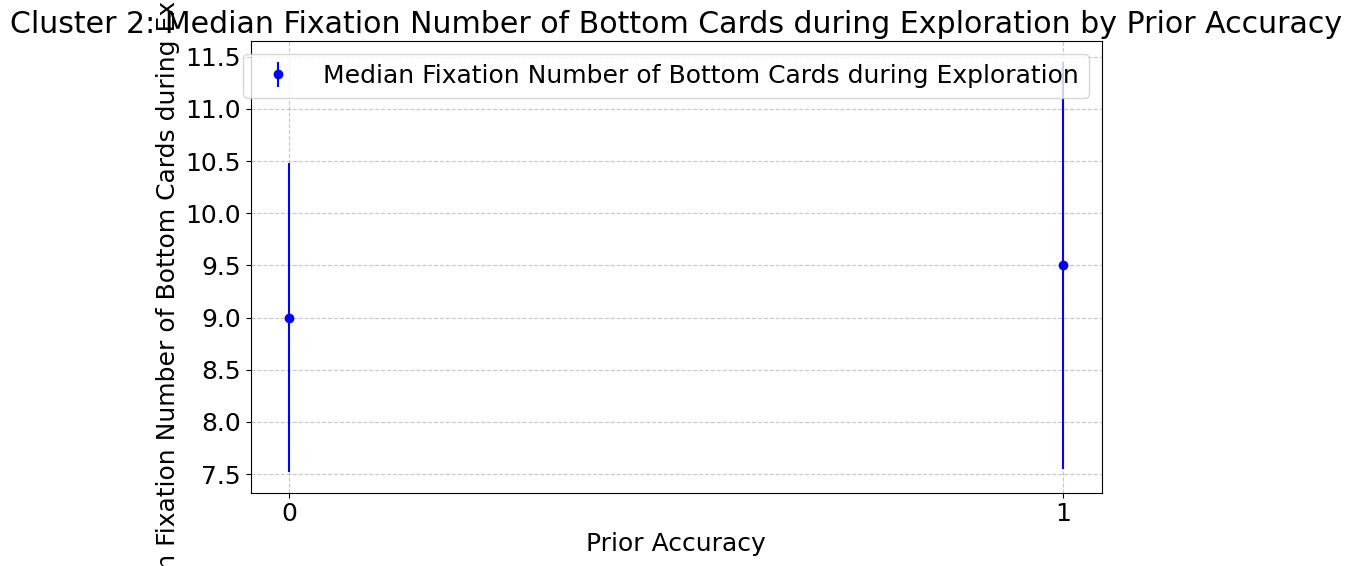


Cluster 2: Overall Median Fixation Number of Bottom Cards during Exploration Period per Prior Accuracy Across Sessions:
prior_accuracy
0.0    9.0
1.0    9.5
dtype: float64


In [40]:
# Same analysis for each cluster

# Cluster 1: Fixation number in bottom exploration
FixNbInBottomExploration_by_prior_accuracy_cluster_1 = [group['FixNbInBottomExploration'].dropna() for name, group in cluster_1_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 1
for group_name, group_data in cluster_1_data.groupby('prior_accuracy')['FixNbInBottomExploration']:
    stat, p = shapiro(group_data)
    print(f"Cluster 1 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 1
stat, p = levene(*FixNbInBottomExploration_by_prior_accuracy_cluster_1)
print(f"Cluster 1 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 1
H, p = kruskal(*FixNbInBottomExploration_by_prior_accuracy_cluster_1)
print("Cluster 1 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_exp_FixNbInBottom_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].median().unstack()

overall_median_exp_FixNbInBottom_cluster_1 = session_median_exp_FixNbInBottom_cluster_1.mean()

session_std_exp_FixNbInBottom_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].std().unstack()
session_count_exp_FixNbInBottom_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].count().unstack()
overall_conf_interval_median_cluster_1 = 1.96 * session_median_exp_FixNbInBottom_cluster_1.std() / np.sqrt(session_median_exp_FixNbInBottom_cluster_1.count())

# Median exploration fixation number of bottom cards across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_FixNbInBottom_cluster_1.index, overall_median_exp_FixNbInBottom_cluster_1.values, yerr=overall_conf_interval_median_cluster_1, fmt='o', color='blue', label='Median Fixation Number of Bottom Cards during Exploration')
plt.title('Cluster 1: Median Fixation Number of Bottom Cards during Exploration by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Number of Bottom Cards during Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 1: Overall Median Fixation Number of Bottom Cards during Exploration Period per Prior Accuracy Across Sessions:")
print(overall_median_exp_FixNbInBottom_cluster_1)


# Cluster 2: Fixation number in bottom exploration
FixNbInBottomExploration_by_prior_accuracy_cluster_2 = [group['FixNbInBottomExploration'].dropna() for name, group in cluster_2_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 2
for group_name, group_data in cluster_2_data.groupby('prior_accuracy')['FixNbInBottomExploration']:
    stat, p = shapiro(group_data)
    print(f"Cluster 2 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 2
stat, p = levene(*FixNbInBottomExploration_by_prior_accuracy_cluster_2)
print(f"Cluster 2 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 2
H, p = kruskal(*FixNbInBottomExploration_by_prior_accuracy_cluster_2)
print("Cluster 2 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_exp_FixNbInBottom_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].median().unstack()

overall_median_exp_FixNbInBottom_cluster_2 = session_median_exp_FixNbInBottom_cluster_2.mean()

session_std_exp_FixNbInBottom_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].std().unstack()
session_count_exp_FixNbInBottom_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].count().unstack()
overall_conf_interval_median_cluster_2 = 1.96 * session_median_exp_FixNbInBottom_cluster_2.std() / np.sqrt(session_median_exp_FixNbInBottom_cluster_2.count())

# Median exploration fixation number of bottom cards across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_FixNbInBottom_cluster_2.index, overall_median_exp_FixNbInBottom_cluster_2.values, yerr=overall_conf_interval_median_cluster_2, fmt='o', color='blue', label='Median Fixation Number of Bottom Cards during Exploration')
plt.title('Cluster 2: Median Fixation Number of Bottom Cards during Exploration by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Number of Bottom Cards during Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 2: Overall Median Fixation Number of Bottom Cards during Exploration Period per Prior Accuracy Across Sessions:")
print(overall_median_exp_FixNbInBottom_cluster_2)

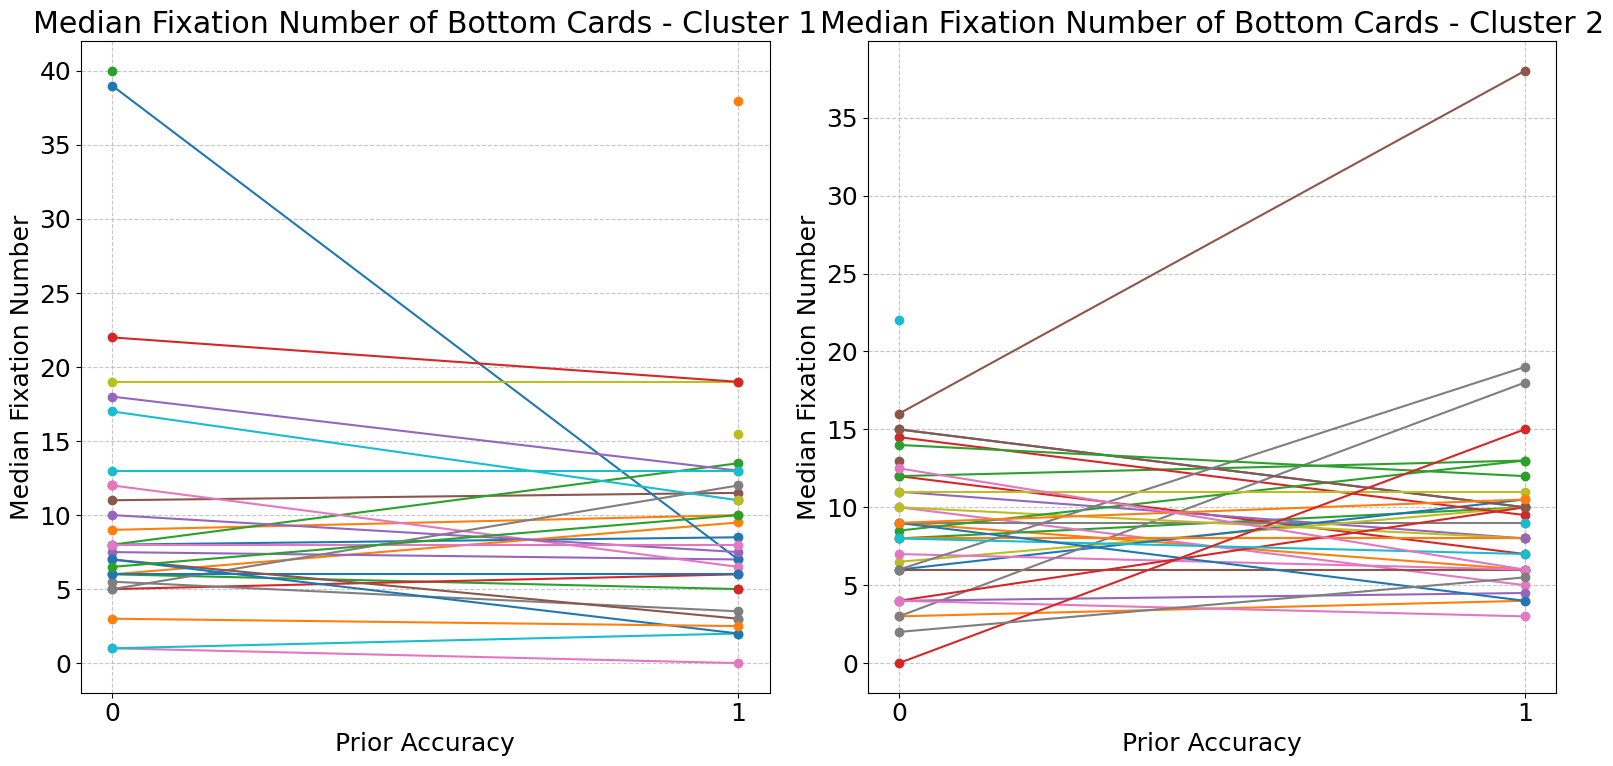

In [15]:
#Fixation Number of bottom cards during exploration per session by prior accuracy per session

#Medians
session_fix_exploration = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].median().unstack()
sessions = data['session'].unique()
cluster_1_sessions = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
cluster_2_sessions = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Cluster 1
axes[0].set_title('Median Fixation Number of Bottom Cards - Cluster 1')
for session in cluster_1_sessions:
    available_prior_accuracy = session_fix_exploration.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixNbInBottomExploration_session = session_fix_exploration.loc[session][available_prior_accuracy]
        axes[0].plot(median_FixNbInBottomExploration_session.index, median_FixNbInBottomExploration_session, marker='o', linestyle='-', label=f'Session {session}')
axes[0].set_xlabel('Prior Accuracy')
axes[0].set_ylabel('Median Fixation Number')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks([0, 1])
#axes[0].legend()

# Plot Cluster 2
axes[1].set_title('Median Fixation Number of Bottom Cards - Cluster 2')
for session in cluster_2_sessions:
    available_prior_accuracy = session_fix_exploration.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixNbInBottomExploration_session = session_fix_exploration.loc[session][available_prior_accuracy]
        axes[1].plot(median_FixNbInBottomExploration_session.index, median_FixNbInBottomExploration_session, marker='o', linestyle='-', label=f'Session {session}')
axes[1].set_xlabel('Prior Accuracy')
axes[1].set_ylabel('Median Fixation Number')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks([0, 1])
#axes[1].legend()

plt.tight_layout()
plt.show()

### Number of fixations of top card (decision period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.7679965194083937e-15
Shapiro-Wilk test for 1.0: p-value = 1.0778633247312953e-20
Levene's test for homogeneity of variances: p-value = 0.914758904986359
Kruskal-Wallis test:
H-statistic: 1.138555747110586
p-value: 0.28595771236238454


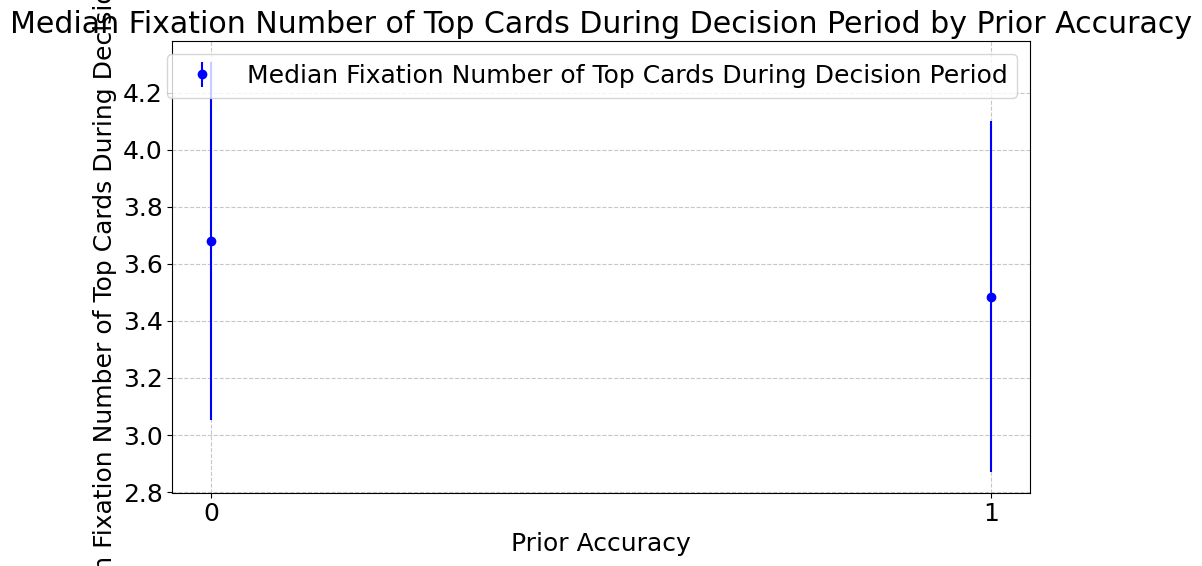


Overall Median Fixation Number of Top Cards During Decision Period per Prior Accuracy Across Sessions:
prior_accuracy
0.0    3.679688
1.0    3.485507
dtype: float64


In [16]:
# Means and medians across sessions 

FixNbInTDecision_by_prior_accuracy = [group['FixNbInTDecision'].dropna() for name, group in same_difficulty_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality
for group_name, group_data in same_difficulty_data.groupby('prior_accuracy')['FixNbInTDecision']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*FixNbInTDecision_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*FixNbInTDecision_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_dec_FixNbInT = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].median().unstack()
overall_median_dec_FixNbInT = session_median_dec_FixNbInT.mean()

session_std_dec_FixNbInT = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].std().unstack()
session_count_dec_FixNbInT = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_dec_FixNbInT.mean() / np.sqrt(session_count_dec_FixNbInT.mean())

overall_conf_interval_median = 1.96 * session_median_dec_FixNbInT.std() / np.sqrt(session_median_dec_FixNbInT.count())

# Median FixNbInT during decision period across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_FixNbInT.index, overall_median_dec_FixNbInT.values, yerr=overall_conf_interval_median, fmt='o', color='blue', label='Median Fixation Number of Top Cards During Decision Period')
plt.title('Median Fixation Number of Top Cards During Decision Period by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Number of Top Cards During Decision Period')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nOverall Median Fixation Number of Top Cards During Decision Period per Prior Accuracy Across Sessions:")
print(overall_median_dec_FixNbInT)

Cluster 1 - Shapiro-Wilk test for 0.0: p-value = 2.276826312948903e-09
Cluster 1 - Shapiro-Wilk test for 1.0: p-value = 4.785149999357592e-15
Cluster 1 - Levene's test for homogeneity of variances: p-value = 0.9456221571628702
Cluster 1 - Kruskal-Wallis test:
H-statistic: 0.6880376331856694
p-value: 0.40683265747374964


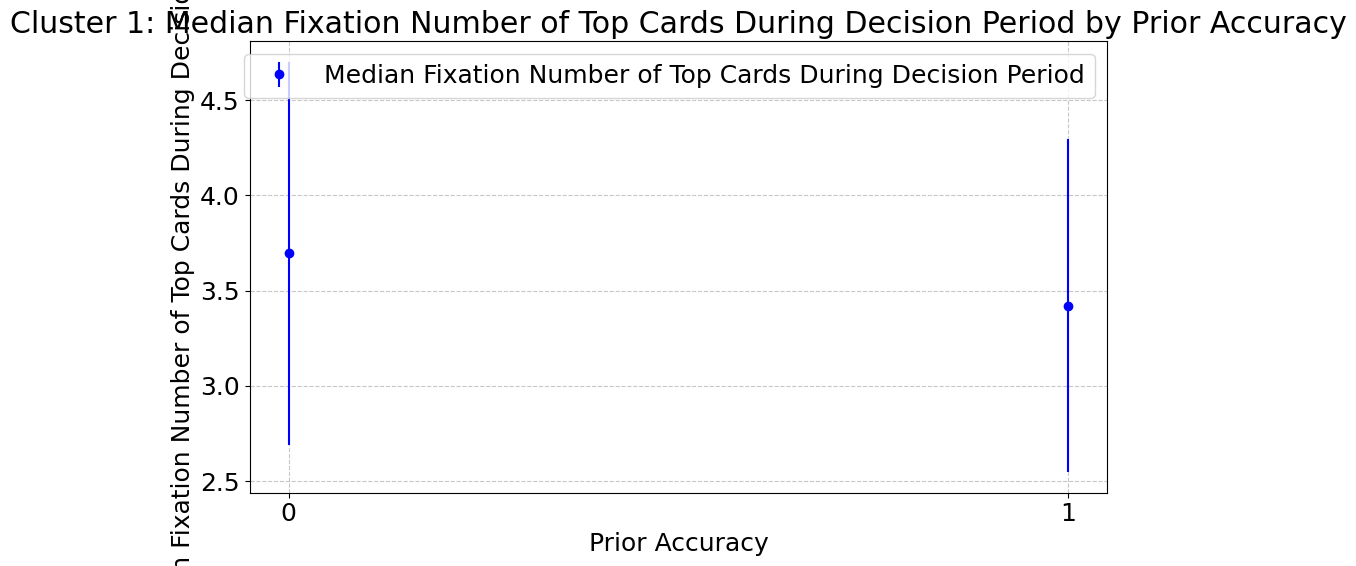


Cluster 1: Overall Median Fixation Number of Top Cards During Decision Period per Prior Accuracy Across Sessions:
prior_accuracy
0.0    3.696429
1.0    3.421875
dtype: float64
Cluster 2 - Shapiro-Wilk test for 0.0: p-value = 1.511722420028428e-11
Cluster 2 - Shapiro-Wilk test for 1.0: p-value = 3.760860571527967e-14
Cluster 2 - Levene's test for homogeneity of variances: p-value = 0.6192164998616378
Cluster 2 - Kruskal-Wallis test:
H-statistic: 0.7292927483186906
p-value: 0.3931125323759179


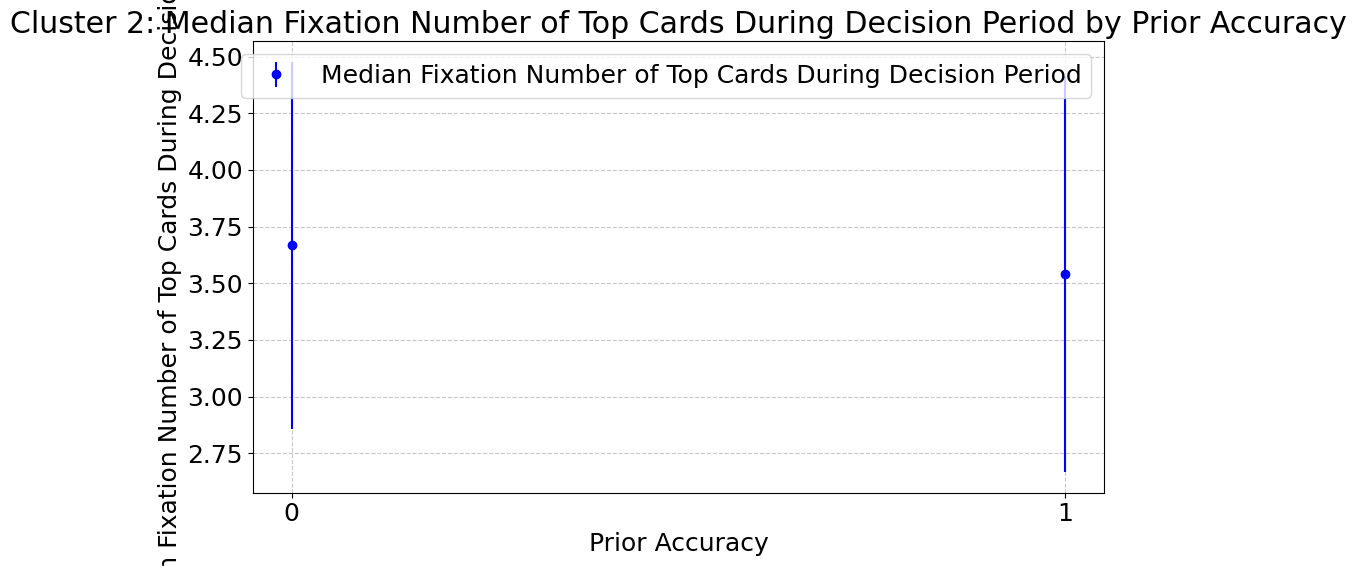


Cluster 2: Overall Median Fixation Number of Top Cards During Decision Period per Prior Accuracy Across Sessions:
prior_accuracy
0.0    3.666667
1.0    3.540541
dtype: float64


In [41]:
# Same analysis for each cluster

# Cluster 1: FixNbInTDecision across sessions
FixNbInTDecision_by_prior_accuracy_cluster_1 = [group['FixNbInTDecision'].dropna() for name, group in cluster_1_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 1
for group_name, group_data in cluster_1_data.groupby('prior_accuracy')['FixNbInTDecision']:
    stat, p = shapiro(group_data)
    print(f"Cluster 1 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 1
stat, p = levene(*FixNbInTDecision_by_prior_accuracy_cluster_1)
print(f"Cluster 1 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 1
H, p = kruskal(*FixNbInTDecision_by_prior_accuracy_cluster_1)
print("Cluster 1 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_dec_FixNbInT_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].median().unstack()
overall_median_dec_FixNbInT_cluster_1 = session_median_dec_FixNbInT_cluster_1.mean()

session_std_dec_FixNbInT_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].std().unstack()
session_count_dec_FixNbInT_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].count().unstack()
overall_conf_interval_mean_cluster_1 = 1.96 * session_std_dec_FixNbInT_cluster_1.mean() / np.sqrt(session_count_dec_FixNbInT_cluster_1.mean())

overall_conf_interval_median_cluster_1 = 1.96 * session_median_dec_FixNbInT_cluster_1.std() / np.sqrt(session_median_dec_FixNbInT_cluster_1.count())

# Median FixNbInT during decision period across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_FixNbInT_cluster_1.index, overall_median_dec_FixNbInT_cluster_1.values, yerr=overall_conf_interval_median_cluster_1, fmt='o', color='blue', label='Median Fixation Number of Top Cards During Decision Period')
plt.title('Cluster 1: Median Fixation Number of Top Cards During Decision Period by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Number of Top Cards During Decision Period')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 1: Overall Median Fixation Number of Top Cards During Decision Period per Prior Accuracy Across Sessions:")
print(overall_median_dec_FixNbInT_cluster_1)

# Cluster 2: FixNbInTDecision across sessions
FixNbInTDecision_by_prior_accuracy_cluster_2 = [group['FixNbInTDecision'].dropna() for name, group in cluster_2_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 2
for group_name, group_data in cluster_2_data.groupby('prior_accuracy')['FixNbInTDecision']:
    stat, p = shapiro(group_data)
    print(f"Cluster 2 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 2
stat, p = levene(*FixNbInTDecision_by_prior_accuracy_cluster_2)
print(f"Cluster 2 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 2
H, p = kruskal(*FixNbInTDecision_by_prior_accuracy_cluster_2)
print("Cluster 2 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_dec_FixNbInT_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].median().unstack()
overall_median_dec_FixNbInT_cluster_2 = session_median_dec_FixNbInT_cluster_2.mean()

session_std_dec_FixNbInT_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].std().unstack()
session_count_dec_FixNbInT_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].count().unstack()
overall_conf_interval_mean_cluster_2 = 1.96 * session_std_dec_FixNbInT_cluster_2.mean() / np.sqrt(session_count_dec_FixNbInT_cluster_2.mean())

overall_conf_interval_median_cluster_2 = 1.96 * session_median_dec_FixNbInT_cluster_2.std() / np.sqrt(session_median_dec_FixNbInT_cluster_2.count())

# Median FixNbInT during decision period across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_FixNbInT_cluster_2.index, overall_median_dec_FixNbInT_cluster_2.values, yerr=overall_conf_interval_median_cluster_2, fmt='o', color='blue', label='Median Fixation Number of Top Cards During Decision Period')
plt.title('Cluster 2: Median Fixation Number of Top Cards During Decision Period by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Number of Top Cards During Decision Period')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 2: Overall Median Fixation Number of Top Cards During Decision Period per Prior Accuracy Across Sessions:")
print(overall_median_dec_FixNbInT_cluster_2)

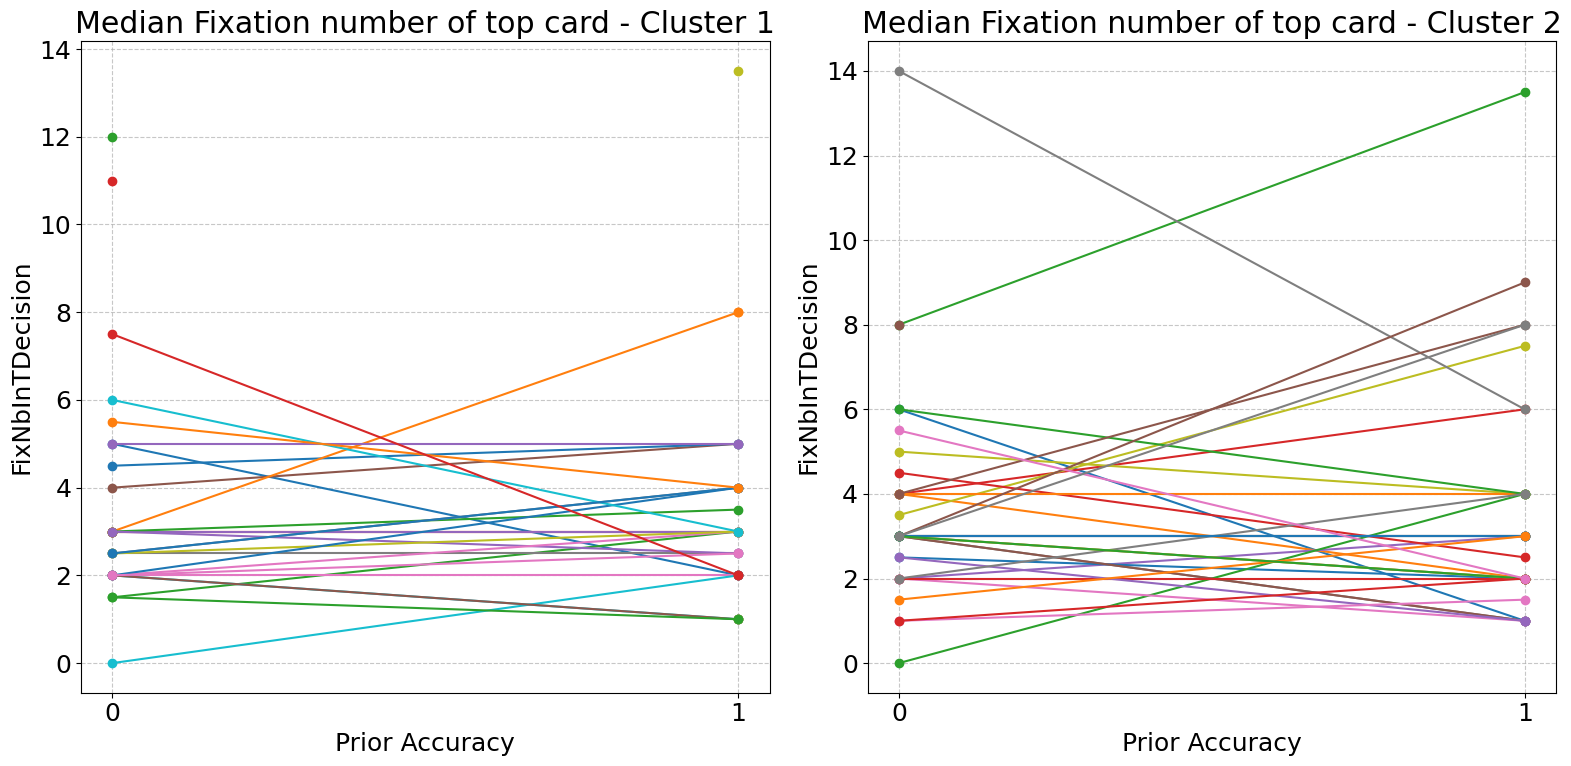

In [17]:
#Fixation Number of top card during decision per session by prior accuracy per session

#Medians
session_fix_decision = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].median().unstack()
sessions = data['session'].unique()
cluster_1_sessions = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
cluster_2_sessions = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Cluster 1
axes[0].set_title('Median Fixation number of top card - Cluster 1')
for session in cluster_1_sessions:
    available_prior_accuracy = session_fix_decision.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixNbInTDecision_session = session_fix_decision.loc[session][available_prior_accuracy]
        axes[0].plot(median_FixNbInTDecision_session.index, median_FixNbInTDecision_session, marker='o', linestyle='-', label=f'Session {session}')

axes[0].set_xlabel('Prior Accuracy')
axes[0].set_ylabel('FixNbInTDecision')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks([0, 1])
#axes[0].legend()

# Plot Cluster 2
axes[1].set_title('Median Fixation number of top card - Cluster 2')
for session in cluster_2_sessions:
    available_prior_accuracy = session_fix_decision.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixNbInTDecision_session = session_fix_decision.loc[session][available_prior_accuracy]
        axes[1].plot(median_FixNbInTDecision_session.index, median_FixNbInTDecision_session, marker='o', linestyle='-', label=f'Session {session}')

axes[1].set_xlabel('Prior Accuracy')
axes[1].set_ylabel('FixNbInTDecision')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks([0, 1])
#axes[1].legend()

plt.tight_layout()
plt.show()

### Fixation Duration of Top Card (Decision Period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.753687758565982e-16
Shapiro-Wilk test for 1.0: p-value = 1.0532993366587233e-18
Levene's test for homogeneity of variances: p-value = 0.6082184495860165
Kruskal-Wallis test:
H-statistic: 0.7188761736374738
p-value: 0.3965127921405952


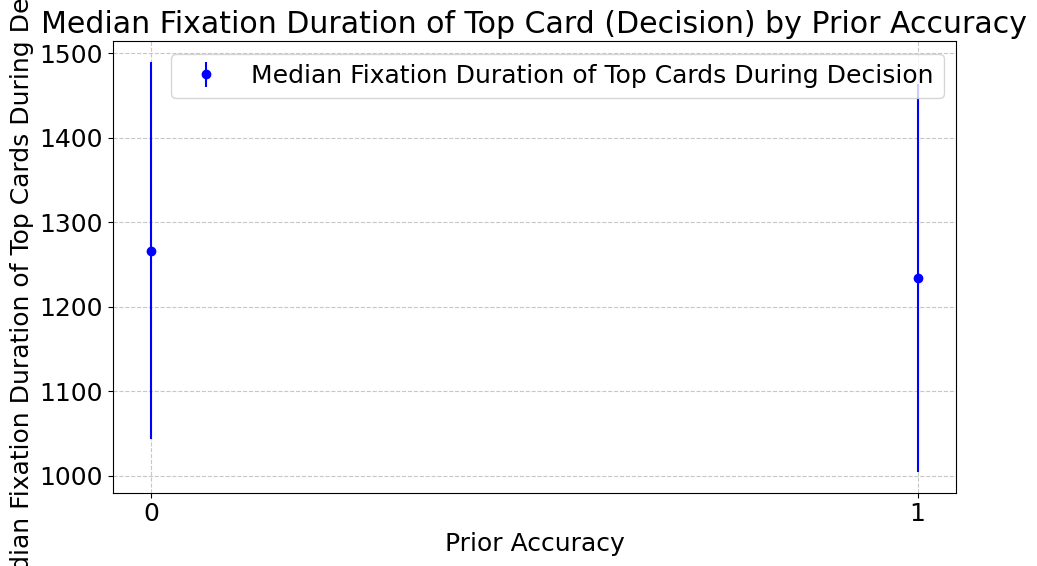


Overall Median Fixation Duration of Top Cards During Decision Period per Prior Accuracy Across Sessions:
prior_accuracy
0.0    1266.390625
1.0    1233.797101
dtype: float64


In [18]:
# Means and medians across sessions 

FixDurInTDecision_by_prior_accuracy = [group['FixDurInTDecision'].dropna() for name, group in same_difficulty_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality
for group_name, group_data in same_difficulty_data.groupby('prior_accuracy')['FixDurInTDecision']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*FixDurInTDecision_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*FixDurInTDecision_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_dec_FixTotDurInT = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].median().unstack()
overall_median_dec_FixTotDurInT = session_median_dec_FixTotDurInT.mean()

session_std_dec_FixTotDurInT = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].std().unstack()
session_count_dec_FixTotDurInT = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_dec_FixTotDurInT.mean() / np.sqrt(session_count_dec_FixTotDurInT.mean())

overall_conf_interval_median = 1.96 * session_median_dec_FixTotDurInT.std() / np.sqrt(session_median_dec_FixTotDurInT.count())

# Median FixTotDurInT during decision period across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_FixTotDurInT.index, overall_median_dec_FixTotDurInT.values, yerr=overall_conf_interval_median, fmt='o', color='blue', label='Median Fixation Duration of Top Cards During Decision')
plt.title('Median Fixation Duration of Top Card (Decision) by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Duration of Top Cards During Decision')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nOverall Median Fixation Duration of Top Cards During Decision Period per Prior Accuracy Across Sessions:")
print(overall_median_dec_FixTotDurInT)

Cluster 1 - Shapiro-Wilk test for 0.0: p-value = 1.4873223178506423e-09
Cluster 1 - Shapiro-Wilk test for 1.0: p-value = 3.617835522808733e-13
Cluster 1 - Levene's test for homogeneity of variances: p-value = 0.8494758999301197
Cluster 1 - Kruskal-Wallis test:
H-statistic: 0.32885486381269713
p-value: 0.5663341650129747


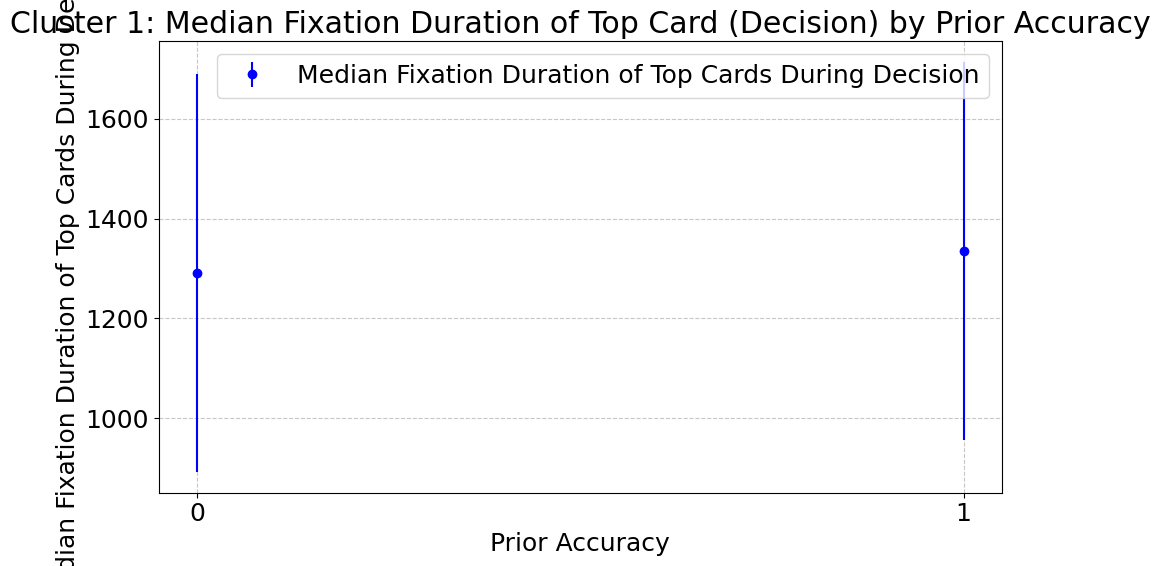


Cluster 1: Overall Median Fixation Duration of Top Cards During Decision Period per Prior Accuracy Across Sessions:
prior_accuracy
0.0    1291.071429
1.0    1334.781250
dtype: float64
Cluster 2 - Shapiro-Wilk test for 0.0: p-value = 8.538919179078198e-13
Cluster 2 - Shapiro-Wilk test for 1.0: p-value = 1.5137382865933329e-12
Cluster 2 - Levene's test for homogeneity of variances: p-value = 0.459558542482175
Cluster 2 - Kruskal-Wallis test:
H-statistic: 0.7793443243006403
p-value: 0.3773417437449915


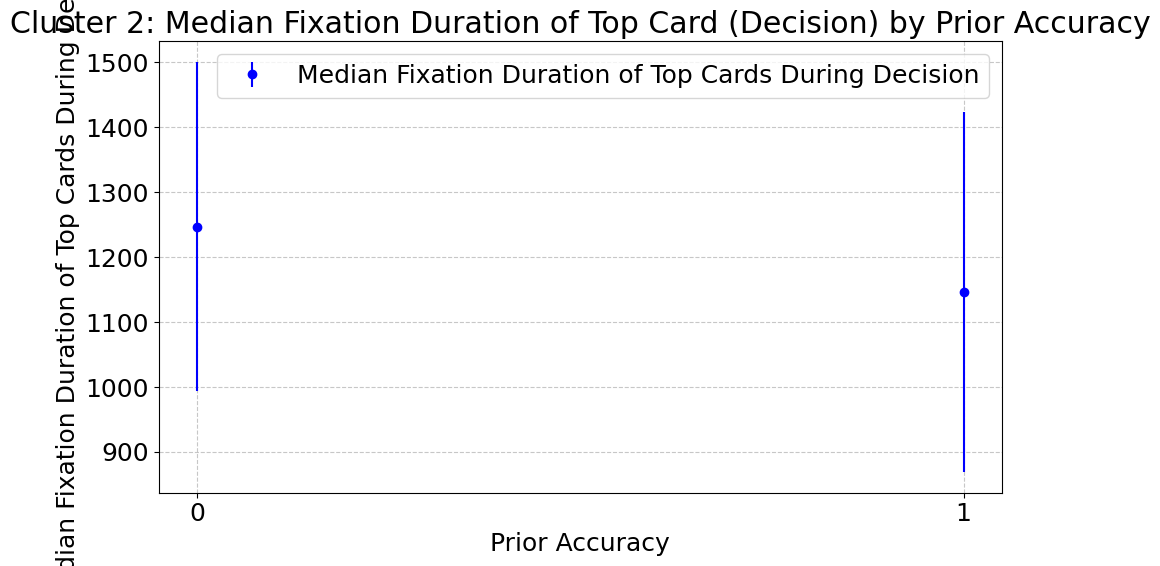


Cluster 2: Overall Median Fixation Duration of Top Cards During Decision Period per Prior Accuracy Across Sessions:
prior_accuracy
0.0    1247.194444
1.0    1146.459459
dtype: float64


In [42]:
# Same analysis for each cluster

# Cluster 1: Means and medians across sessions
FixDurInTDecision_by_prior_accuracy_cluster_1 = [group['FixDurInTDecision'].dropna() for name, group in cluster_1_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 1
for group_name, group_data in cluster_1_data.groupby('prior_accuracy')['FixDurInTDecision']:
    stat, p = shapiro(group_data)
    print(f"Cluster 1 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 1
stat, p = levene(*FixDurInTDecision_by_prior_accuracy_cluster_1)
print(f"Cluster 1 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 1
H, p = kruskal(*FixDurInTDecision_by_prior_accuracy_cluster_1)
print("Cluster 1 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_dec_FixTotDurInT_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].median().unstack()
overall_median_dec_FixTotDurInT_cluster_1 = session_median_dec_FixTotDurInT_cluster_1.mean()

session_std_dec_FixTotDurInT_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].std().unstack()
session_count_dec_FixTotDurInT_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].count().unstack()
overall_conf_interval_mean_cluster_1 = 1.96 * session_std_dec_FixTotDurInT_cluster_1.mean() / np.sqrt(session_count_dec_FixTotDurInT_cluster_1.mean())

overall_conf_interval_median_cluster_1 = 1.96 * session_median_dec_FixTotDurInT_cluster_1.std() / np.sqrt(session_median_dec_FixTotDurInT_cluster_1.count())

# Median FixTotDurInT during decision period across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_FixTotDurInT_cluster_1.index, overall_median_dec_FixTotDurInT_cluster_1.values, yerr=overall_conf_interval_median_cluster_1, fmt='o', color='blue', label='Median Fixation Duration of Top Cards During Decision')
plt.title('Cluster 1: Median Fixation Duration of Top Card (Decision) by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Duration of Top Cards During Decision')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 1: Overall Median Fixation Duration of Top Cards During Decision Period per Prior Accuracy Across Sessions:")
print(overall_median_dec_FixTotDurInT_cluster_1)

# Cluster 2: Means and medians across sessions
FixDurInTDecision_by_prior_accuracy_cluster_2 = [group['FixDurInTDecision'].dropna() for name, group in cluster_2_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 2
for group_name, group_data in cluster_2_data.groupby('prior_accuracy')['FixDurInTDecision']:
    stat, p = shapiro(group_data)
    print(f"Cluster 2 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 2
stat, p = levene(*FixDurInTDecision_by_prior_accuracy_cluster_2)
print(f"Cluster 2 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 2
H, p = kruskal(*FixDurInTDecision_by_prior_accuracy_cluster_2)
print("Cluster 2 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_dec_FixTotDurInT_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].median().unstack()
overall_median_dec_FixTotDurInT_cluster_2 = session_median_dec_FixTotDurInT_cluster_2.mean()

session_std_dec_FixTotDurInT_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].std().unstack()
session_count_dec_FixTotDurInT_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].count().unstack()
overall_conf_interval_mean_cluster_2 = 1.96 * session_std_dec_FixTotDurInT_cluster_2.mean() / np.sqrt(session_count_dec_FixTotDurInT_cluster_2.mean())

overall_conf_interval_median_cluster_2 = 1.96 * session_median_dec_FixTotDurInT_cluster_2.std() / np.sqrt(session_median_dec_FixTotDurInT_cluster_2.count())

# Median FixTotDurInT during decision period across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_FixTotDurInT_cluster_2.index, overall_median_dec_FixTotDurInT_cluster_2.values, yerr=overall_conf_interval_median_cluster_2, fmt='o', color='blue', label='Median Fixation Duration of Top Cards During Decision')
plt.title('Cluster 2: Median Fixation Duration of Top Card (Decision) by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Duration of Top Cards During Decision')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 2: Overall Median Fixation Duration of Top Cards During Decision Period per Prior Accuracy Across Sessions:")
print(overall_median_dec_FixTotDurInT_cluster_2)

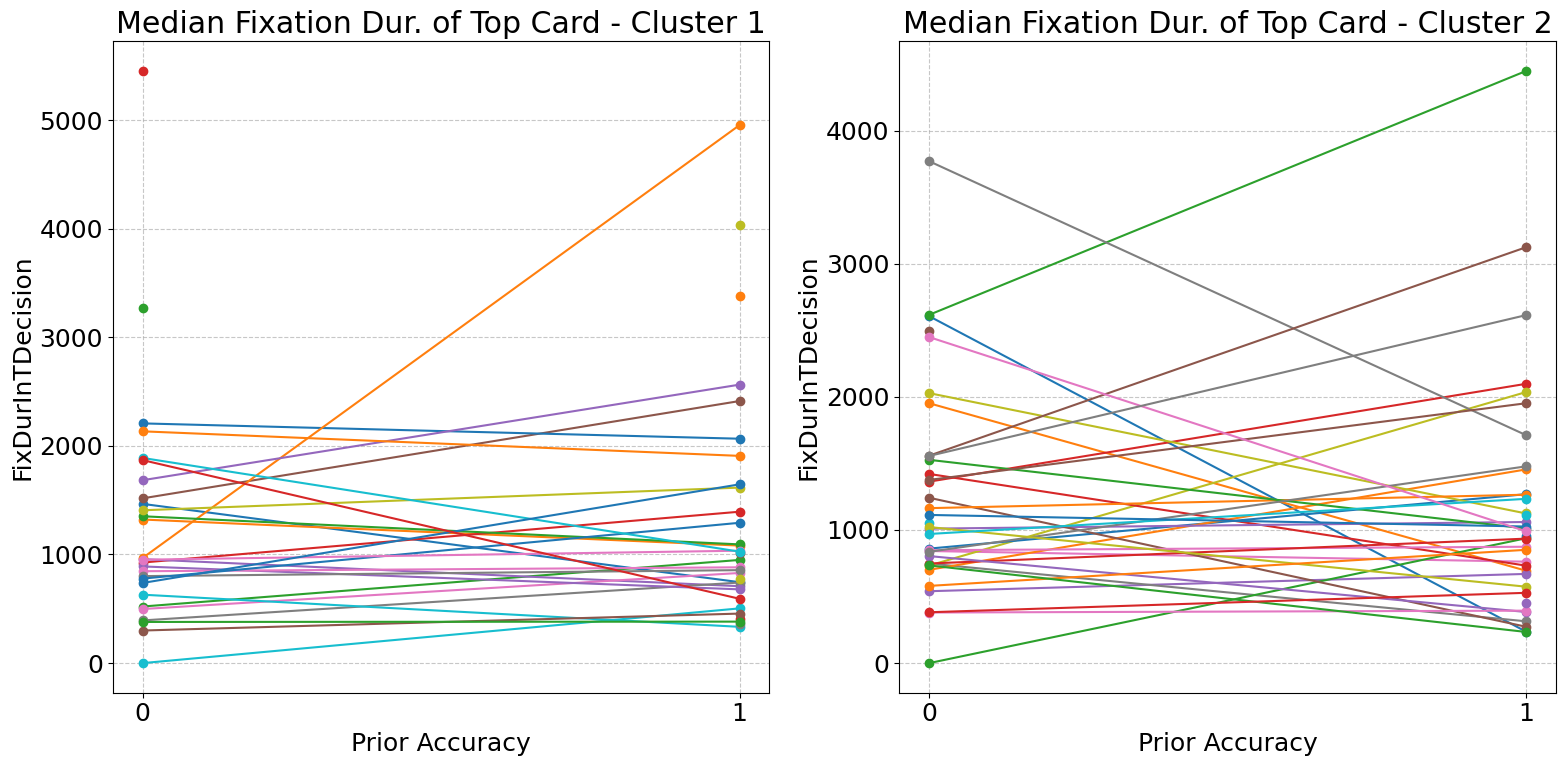

In [19]:
#Fixation duration of top card during decision per session by prior accuracy per session

#Medians
session_fix_decision = same_difficulty_data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].median().unstack()
sessions = same_difficulty_data['session'].unique()
cluster_1_sessions = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
cluster_2_sessions = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Cluster 1
axes[0].set_title('Median Fixation Dur. of Top Card - Cluster 1')
for session in cluster_1_sessions:
    available_prior_accuracy = session_fix_decision.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixDurInTDecision_session = session_fix_decision.loc[session][available_prior_accuracy]
        axes[0].plot(median_FixDurInTDecision_session.index, median_FixDurInTDecision_session, marker='o', linestyle='-', label=f'Session {session}')
axes[0].set_xlabel('Prior Accuracy')
axes[0].set_ylabel('FixDurInTDecision')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks([0, 1])
#axes[0].legend()

# Plot for Cluster 2
axes[1].set_title('Median Fixation Dur. of Top Card - Cluster 2')
for session in cluster_2_sessions:
    available_prior_accuracy = session_fix_decision.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixDurInTDecision_session = session_fix_decision.loc[session][available_prior_accuracy]
        axes[1].plot(median_FixDurInTDecision_session.index, median_FixDurInTDecision_session, marker='o', linestyle='-', label=f'Session {session}')
axes[1].set_xlabel('Prior Accuracy')
axes[1].set_ylabel('FixDurInTDecision')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks([0, 1])
#axes[1].legend()

plt.tight_layout()
plt.show()

### Fixation Duration of Bottom Cards (Exploration Period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.6232824002617182e-15
Shapiro-Wilk test for 1.0: p-value = 2.7285294945423213e-12
Levene's test for homogeneity of variances: p-value = 0.6985221131476357
Kruskal-Wallis test:
H-statistic: 0.2869210262003181
p-value: 0.5922003988166425


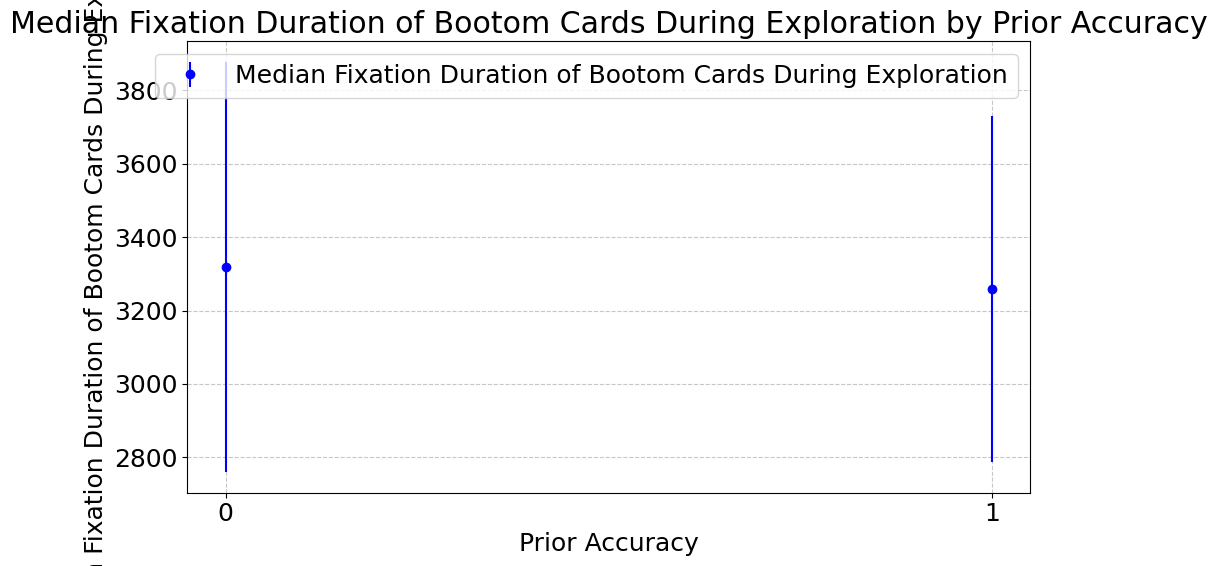


Overall Median Fixation Duration of Bootom Cards During Exploration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    3318.671875
1.0    3258.376812
dtype: float64


In [20]:
# Means and medians across sessions 

durfixBottomExploration_by_prior_accuracy = [group['durfixBottomExploration'].dropna() for name, group in same_difficulty_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality
for group_name, group_data in same_difficulty_data.groupby('prior_accuracy')['durfixBottomExploration']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*durfixBottomExploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*durfixBottomExploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_exp_durfixBottom = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].mean().unstack()
session_median_exp_durfixBottom = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].median().unstack()

overall_mean_exp_durfixBottom = session_mean_exp_durfixBottom.mean()
overall_median_exp_durfixBottom = session_median_exp_durfixBottom.mean()

session_std_exp_durfixBottom = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].std().unstack()
session_count_exp_durfixBottom = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_exp_durfixBottom.mean() / np.sqrt(session_count_exp_durfixBottom.mean())

overall_conf_interval_median = 1.96 * session_median_exp_durfixBottom.std() / np.sqrt(session_median_exp_durfixBottom.count())

# Median exploration Fixation duration of bottom cards across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_durfixBottom.index, overall_median_exp_durfixBottom.values, yerr=overall_conf_interval_median, fmt='o', color='blue', label='Median Fixation Duration of Bootom Cards During Exploration')
plt.title('Median Fixation Duration of Bootom Cards During Exploration by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Duration of Bootom Cards During Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nOverall Median Fixation Duration of Bootom Cards During Exploration per Prior Accuracy Across Sessions:")
print(overall_median_exp_durfixBottom)

Cluster 1 - Shapiro-Wilk test for 0.0: p-value = 3.3383659641070927e-10
Cluster 1 - Shapiro-Wilk test for 1.0: p-value = 6.792102907364405e-08
Cluster 1 - Levene's test for homogeneity of variances: p-value = 0.5586453089849599
Cluster 1 - Kruskal-Wallis test:
H-statistic: 1.526455204494242
p-value: 0.21664523592386956


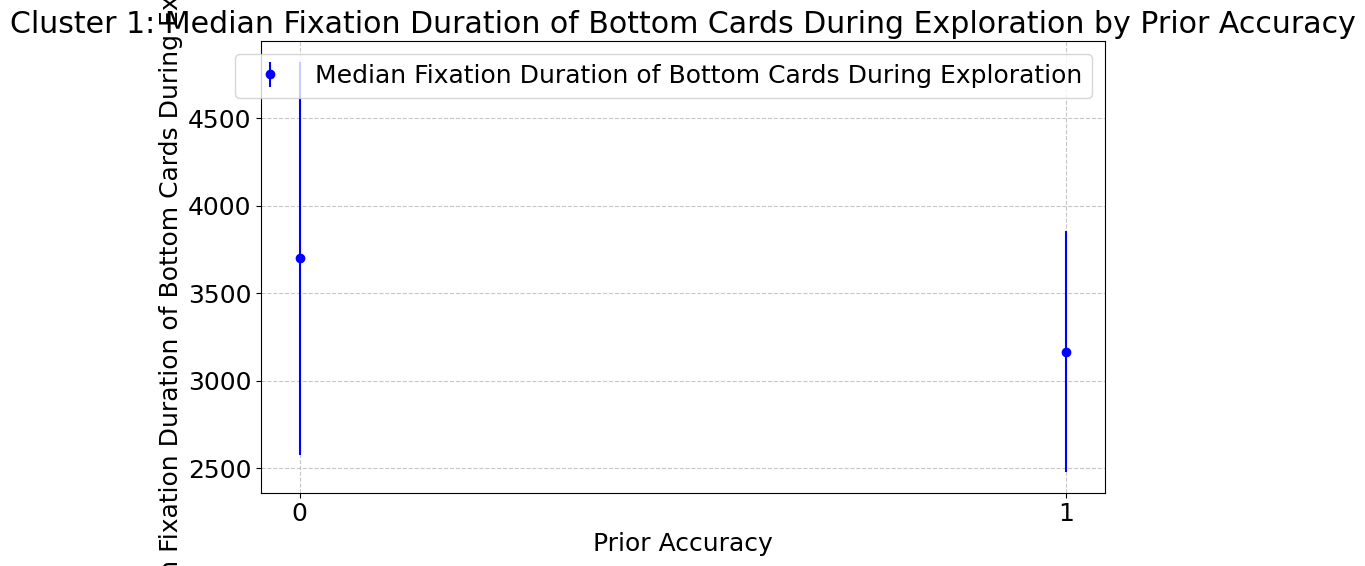


Cluster 1: Overall Median Fixation Duration of Bottom Cards During Exploration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    3700.571429
1.0    3166.062500
dtype: float64
Cluster 2 - Shapiro-Wilk test for 0.0: p-value = 1.2915803135970403e-09
Cluster 2 - Shapiro-Wilk test for 1.0: p-value = 5.095088336485872e-09
Cluster 2 - Levene's test for homogeneity of variances: p-value = 0.33682433532429557
Cluster 2 - Kruskal-Wallis test:
H-statistic: 0.3212872813137106
p-value: 0.5708350611370876


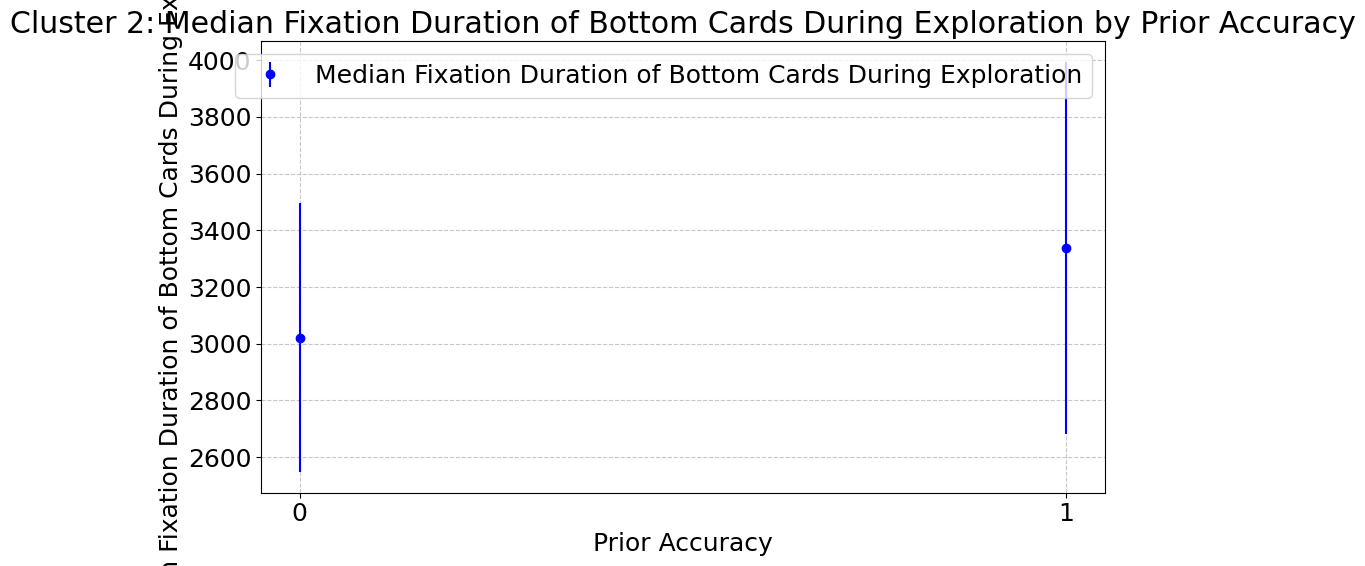


Cluster 2: Overall Median Fixation Duration of Bottom Cards During Exploration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    3021.638889
1.0    3338.216216
dtype: float64


In [43]:
# Same analysis for each cluster

# Cluster 1: Means and medians across sessions
durfixBottomExploration_by_prior_accuracy_cluster_1 = [group['durfixBottomExploration'].dropna() for name, group in cluster_1_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 1
for group_name, group_data in cluster_1_data.groupby('prior_accuracy')['durfixBottomExploration']:
    stat, p = shapiro(group_data)
    print(f"Cluster 1 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 1
stat, p = levene(*durfixBottomExploration_by_prior_accuracy_cluster_1)
print(f"Cluster 1 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 1
H, p = kruskal(*durfixBottomExploration_by_prior_accuracy_cluster_1)
print("Cluster 1 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_exp_durfixBottom_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].mean().unstack()
session_median_exp_durfixBottom_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].median().unstack()

overall_mean_exp_durfixBottom_cluster_1 = session_mean_exp_durfixBottom_cluster_1.mean()
overall_median_exp_durfixBottom_cluster_1 = session_median_exp_durfixBottom_cluster_1.mean()

session_std_exp_durfixBottom_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].std().unstack()
session_count_exp_durfixBottom_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].count().unstack()
overall_conf_interval_mean_cluster_1 = 1.96 * session_std_exp_durfixBottom_cluster_1.mean() / np.sqrt(session_count_exp_durfixBottom_cluster_1.mean())

overall_conf_interval_median_cluster_1 = 1.96 * session_median_exp_durfixBottom_cluster_1.std() / np.sqrt(session_median_exp_durfixBottom_cluster_1.count())

# Median exploration Fixation duration of bottom cards across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_durfixBottom_cluster_1.index, overall_median_exp_durfixBottom_cluster_1.values, yerr=overall_conf_interval_median_cluster_1, fmt='o', color='blue', label='Median Fixation Duration of Bottom Cards During Exploration')
plt.title('Cluster 1: Median Fixation Duration of Bottom Cards During Exploration by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Duration of Bottom Cards During Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 1: Overall Median Fixation Duration of Bottom Cards During Exploration per Prior Accuracy Across Sessions:")
print(overall_median_exp_durfixBottom_cluster_1)

# Cluster 2: Means and medians across sessions
durfixBottomExploration_by_prior_accuracy_cluster_2 = [group['durfixBottomExploration'].dropna() for name, group in cluster_2_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 2
for group_name, group_data in cluster_2_data.groupby('prior_accuracy')['durfixBottomExploration']:
    stat, p = shapiro(group_data)
    print(f"Cluster 2 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 2
stat, p = levene(*durfixBottomExploration_by_prior_accuracy_cluster_2)
print(f"Cluster 2 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 2
H, p = kruskal(*durfixBottomExploration_by_prior_accuracy_cluster_2)
print("Cluster 2 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_exp_durfixBottom_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].mean().unstack()
session_median_exp_durfixBottom_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].median().unstack()

overall_mean_exp_durfixBottom_cluster_2 = session_mean_exp_durfixBottom_cluster_2.mean()
overall_median_exp_durfixBottom_cluster_2 = session_median_exp_durfixBottom_cluster_2.mean()

session_std_exp_durfixBottom_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].std().unstack()
session_count_exp_durfixBottom_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].count().unstack()
overall_conf_interval_mean_cluster_2 = 1.96 * session_std_exp_durfixBottom_cluster_2.mean() / np.sqrt(session_count_exp_durfixBottom_cluster_2.mean())

overall_conf_interval_median_cluster_2 = 1.96 * session_median_exp_durfixBottom_cluster_2.std() / np.sqrt(session_median_exp_durfixBottom_cluster_2.count())

# Median exploration Fixation duration of bottom cards across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_durfixBottom_cluster_2.index, overall_median_exp_durfixBottom_cluster_2.values, yerr=overall_conf_interval_median_cluster_2, fmt='o', color='blue', label='Median Fixation Duration of Bottom Cards During Exploration')
plt.title('Cluster 2: Median Fixation Duration of Bottom Cards During Exploration by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Fixation Duration of Bottom Cards During Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 2: Overall Median Fixation Duration of Bottom Cards During Exploration per Prior Accuracy Across Sessions:")
print(overall_median_exp_durfixBottom_cluster_2)

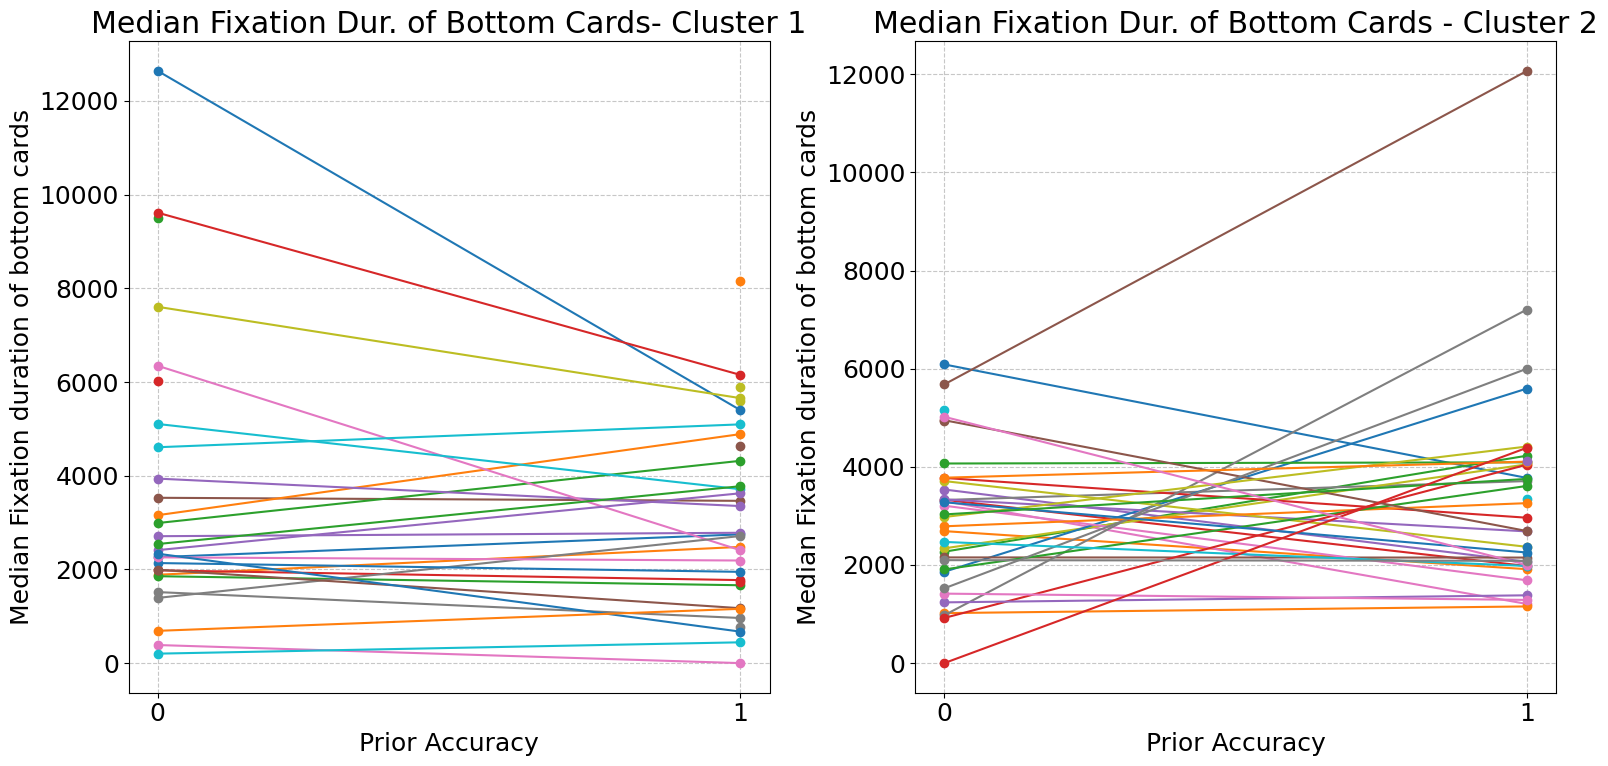

In [21]:
#Fixation duration of bottom cards during exploration per session by prior accuracy per session

#Medians
session_fix_exploration = same_difficulty_data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].median().unstack()
sessions = data['session'].unique()
cluster_1_sessions = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
cluster_2_sessions = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Cluster 1
axes[0].set_title('Median Fixation Dur. of Bottom Cards- Cluster 1')
for session in cluster_1_sessions:
    available_prior_accuracy = session_fix_exploration.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_durfixBottom_session = session_fix_exploration.loc[session][available_prior_accuracy]
        axes[0].plot(median_durfixBottom_session.index, median_durfixBottom_session, marker='o', linestyle='-', label=f'Session {session}')
axes[0].set_xlabel('Prior Accuracy')
axes[0].set_ylabel('Median Fixation duration of bottom cards')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks([0, 1])
#axes[0].legend()

# Plot for Cluster 2
axes[1].set_title('Median Fixation Dur. of Bottom Cards - Cluster 2')
for session in cluster_2_sessions:
    available_prior_accuracy = session_fix_exploration.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_durfixBottom_session = session_fix_exploration.loc[session][available_prior_accuracy]
        axes[1].plot(median_durfixBottom_session.index, median_durfixBottom_session, marker='o', linestyle='-', label=f'Session {session}')
axes[1].set_xlabel('Prior Accuracy')
axes[1].set_ylabel('Median Fixation duration of bottom cards')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks([0, 1])
#axes[1].legend()

plt.tight_layout()
plt.show()

### Number of Switches between bottom cards (exploration period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.4375620680190561e-15
Shapiro-Wilk test for 1.0: p-value = 3.1678435462295106e-13
Levene's test for homogeneity of variances: p-value = 0.8489678431645323
Kruskal-Wallis test:
H-statistic: 0.38395337319783523
p-value: 0.5354950152182432


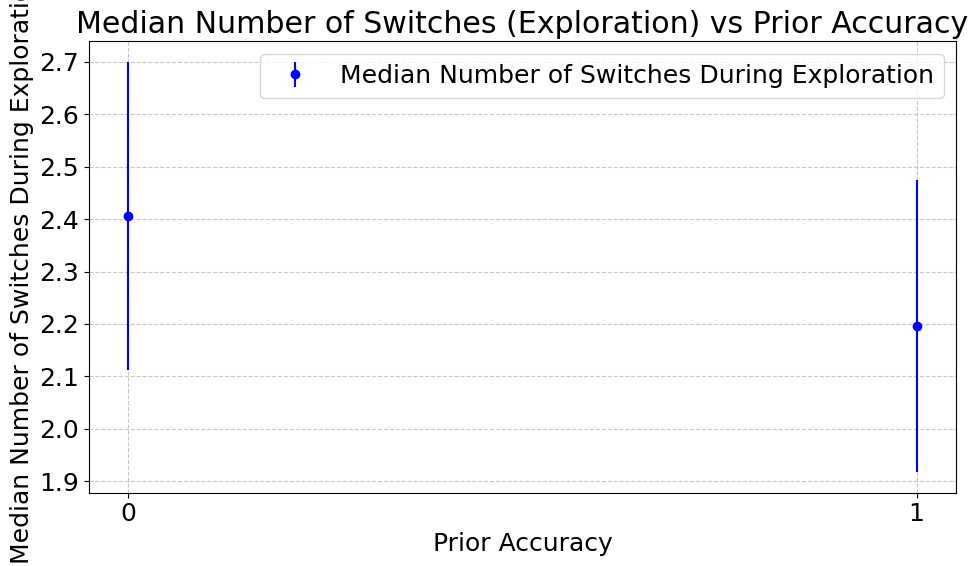


Overall Median Number of Switches During Exploration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    2.406250
1.0    2.195652
dtype: float64


In [22]:
# Medians across sessions

Switches_Exploration_by_prior_accuracy = [group['SwitchesExplorationPeriod'].dropna() for name, group in same_difficulty_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality
for group_name, group_data in same_difficulty_data.groupby('prior_accuracy')['SwitchesExplorationPeriod']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*Switches_Exploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*Switches_Exploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_exp_NbSwitches = same_difficulty_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].median().unstack()
overall_median_exp_NbSwitches = session_median_exp_NbSwitches.mean()

session_std_exp_NbSwitches = same_difficulty_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].std().unstack()
session_count_exp_NbSwitches = same_difficulty_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_exp_NbSwitches.mean() / np.sqrt(session_count_exp_NbSwitches.mean())

overall_conf_interval_median = 1.96 * session_median_exp_NbSwitches.std() / np.sqrt(session_median_exp_NbSwitches.count())

# Median NbSwitches during exploration across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_NbSwitches.index, overall_median_exp_NbSwitches.values, yerr=overall_conf_interval_median, fmt='o', color='blue', label='Median Number of Switches During Exploration')
plt.title('Median Number of Switches (Exploration) vs Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Number of Switches During Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nOverall Median Number of Switches During Exploration per Prior Accuracy Across Sessions:")
print(overall_median_exp_NbSwitches)

Cluster 1 - Shapiro-Wilk test for 0.0: p-value = 1.8433294052494776e-08
Cluster 1 - Shapiro-Wilk test for 1.0: p-value = 2.5783026867008227e-09
Cluster 1 - Levene's test for homogeneity of variances: p-value = 0.5848298711686546
Cluster 1 - Kruskal-Wallis test:
H-statistic: 0.38898154046969785
p-value: 0.5328352336029338


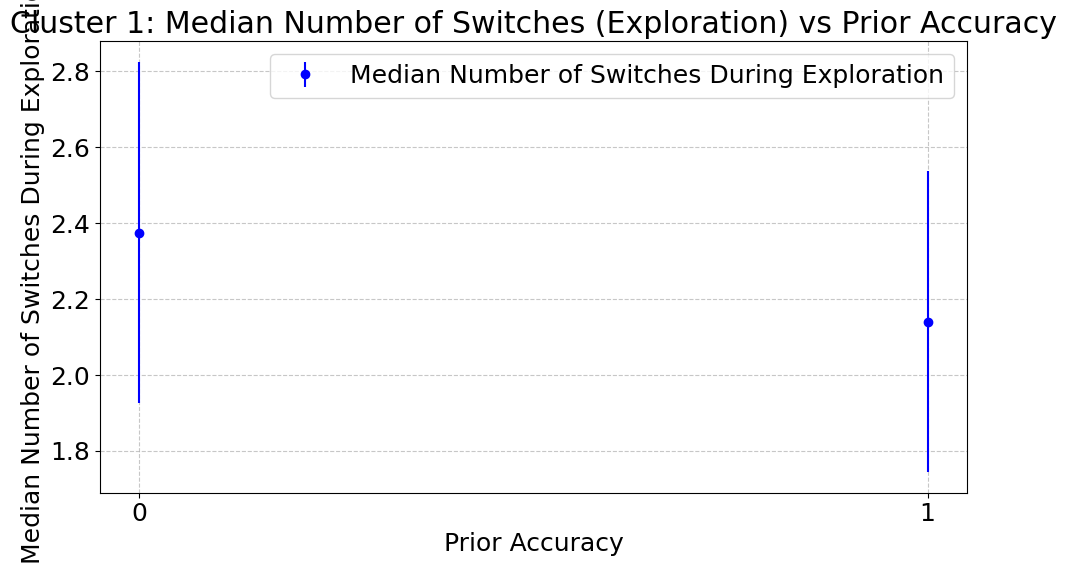


Cluster 1: Overall Median Number of Switches During Exploration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    2.375000
1.0    2.140625
dtype: float64
Cluster 2 - Shapiro-Wilk test for 0.0: p-value = 1.255683776213716e-12
Cluster 2 - Shapiro-Wilk test for 1.0: p-value = 1.3686666465962648e-08
Cluster 2 - Levene's test for homogeneity of variances: p-value = 0.7241078879189353
Cluster 2 - Kruskal-Wallis test:
H-statistic: 0.013687343588586852
p-value: 0.9068656630988461


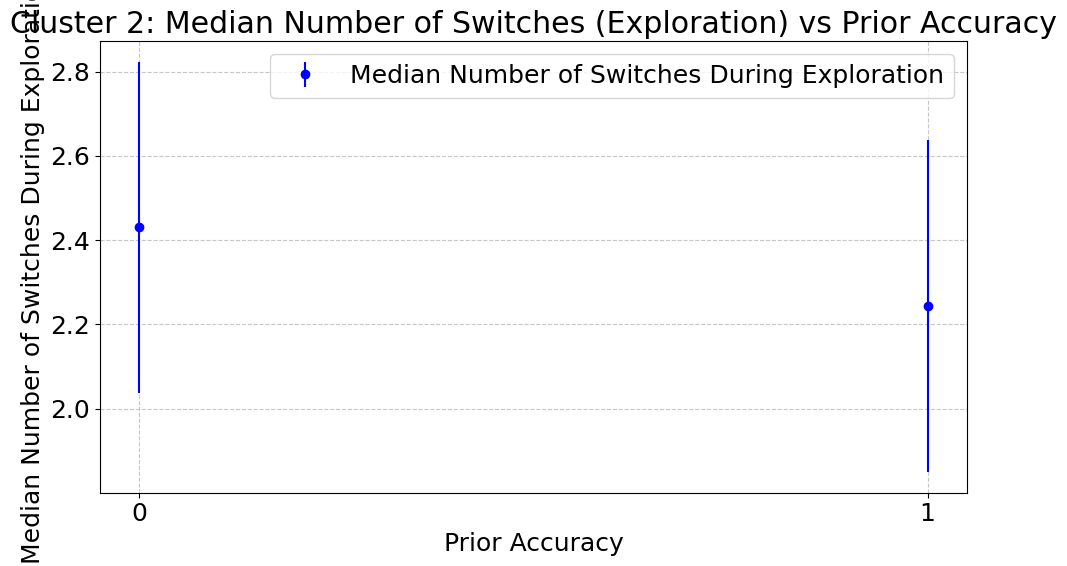


Cluster 2: Overall Median Number of Switches During Exploration per Prior Accuracy Across Sessions:
prior_accuracy
0.0    2.430556
1.0    2.243243
dtype: float64


In [44]:
# Same analysis for each cluster

# Cluster 1: Medians across sessions
switches_exploration_by_prior_accuracy_cluster_1 = [group['SwitchesExplorationPeriod'].dropna() for name, group in cluster_1_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 1
for group_name, group_data in cluster_1_data.groupby('prior_accuracy')['SwitchesExplorationPeriod']:
    stat, p = shapiro(group_data)
    print(f"Cluster 1 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 1
stat, p = levene(*switches_exploration_by_prior_accuracy_cluster_1)
print(f"Cluster 1 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 1
H, p = kruskal(*switches_exploration_by_prior_accuracy_cluster_1)
print("Cluster 1 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_exp_nb_switches_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].median().unstack()
overall_median_exp_nb_switches_cluster_1 = session_median_exp_nb_switches_cluster_1.mean()

session_std_exp_nb_switches_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].std().unstack()
session_count_exp_nb_switches_cluster_1 = cluster_1_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].count().unstack()
overall_conf_interval_mean_cluster_1 = 1.96 * session_std_exp_nb_switches_cluster_1.mean() / np.sqrt(session_count_exp_nb_switches_cluster_1.mean())

overall_conf_interval_median_cluster_1 = 1.96 * session_median_exp_nb_switches_cluster_1.std() / np.sqrt(session_median_exp_nb_switches_cluster_1.count())

# Median number of switches during exploration across sessions with confidence intervals for Cluster 1
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_nb_switches_cluster_1.index, overall_median_exp_nb_switches_cluster_1.values, yerr=overall_conf_interval_median_cluster_1, fmt='o', color='blue', label='Median Number of Switches During Exploration')
plt.title('Cluster 1: Median Number of Switches (Exploration) vs Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Number of Switches During Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 1: Overall Median Number of Switches During Exploration per Prior Accuracy Across Sessions:")
print(overall_median_exp_nb_switches_cluster_1)

# Cluster 2: Medians across sessions
switches_exploration_by_prior_accuracy_cluster_2 = [group['SwitchesExplorationPeriod'].dropna() for name, group in cluster_2_data.groupby('prior_accuracy')]

# Shapiro-Wilk test for normality for Cluster 2
for group_name, group_data in cluster_2_data.groupby('prior_accuracy')['SwitchesExplorationPeriod']:
    stat, p = shapiro(group_data)
    print(f"Cluster 2 - Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances for Cluster 2
stat, p = levene(*switches_exploration_by_prior_accuracy_cluster_2)
print(f"Cluster 2 - Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test for Cluster 2
H, p = kruskal(*switches_exploration_by_prior_accuracy_cluster_2)
print("Cluster 2 - Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_median_exp_nb_switches_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].median().unstack()
overall_median_exp_nb_switches_cluster_2 = session_median_exp_nb_switches_cluster_2.mean()

session_std_exp_nb_switches_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].std().unstack()
session_count_exp_nb_switches_cluster_2 = cluster_2_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].count().unstack()
overall_conf_interval_mean_cluster_2 = 1.96 * session_std_exp_nb_switches_cluster_2.mean() / np.sqrt(session_count_exp_nb_switches_cluster_2.mean())

overall_conf_interval_median_cluster_2 = 1.96 * session_median_exp_nb_switches_cluster_2.std() / np.sqrt(session_median_exp_nb_switches_cluster_2.count())

# Median number of switches during exploration across sessions with confidence intervals for Cluster 2
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_nb_switches_cluster_2.index, overall_median_exp_nb_switches_cluster_2.values, yerr=overall_conf_interval_median_cluster_2, fmt='o', color='blue', label='Median Number of Switches During Exploration')
plt.title('Cluster 2: Median Number of Switches (Exploration) vs Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Median Number of Switches During Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

print("\nCluster 2: Overall Median Number of Switches During Exploration per Prior Accuracy Across Sessions:")
print(overall_median_exp_nb_switches_cluster_2)

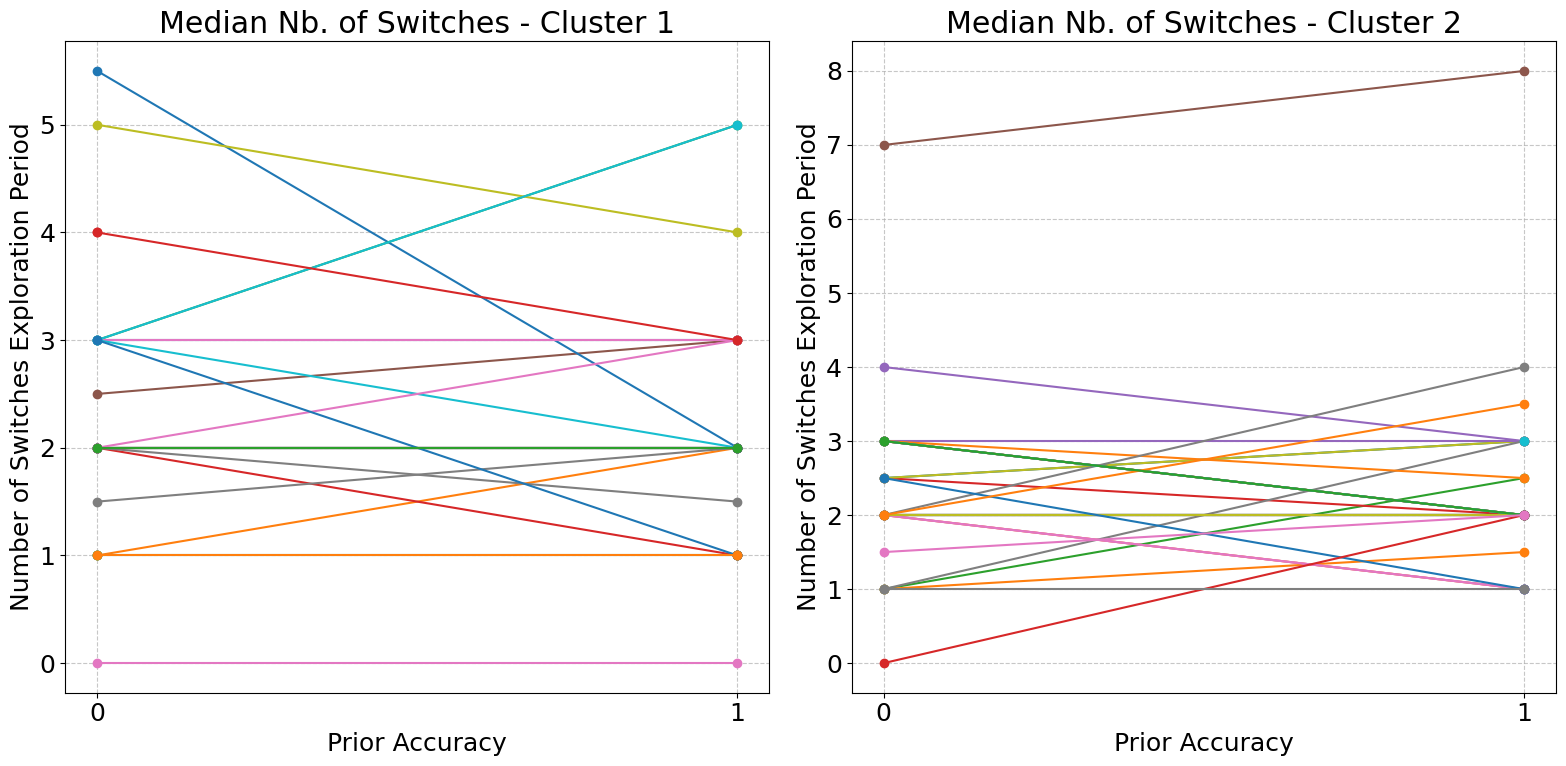

In [23]:
# Number of switches per session during Exploration Period by prior accuracy per session

#Medians
session_SwitchesExplorationPeriod = same_difficulty_data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].median().unstack()

sessions = data['session'].unique()
cluster_1_sessions = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
cluster_2_sessions = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Cluster 1
axes[0].set_title('Median Nb. of Switches - Cluster 1')
for session in cluster_1_sessions:
    available_prior_accuracy = session_SwitchesExplorationPeriod.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_SwitchesExplorationPeriod_session = session_SwitchesExplorationPeriod.loc[session][available_prior_accuracy]
        axes[0].plot(median_SwitchesExplorationPeriod_session.index, median_SwitchesExplorationPeriod_session, marker='o', linestyle='-', label=f'Session {session}')
axes[0].set_xlabel('Prior Accuracy')
axes[0].set_ylabel('Number of Switches Exploration Period')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks([0, 1])
#axes[0].legend()

# Plot for Cluster 2
axes[1].set_title('Median Nb. of Switches - Cluster 2')
for session in cluster_2_sessions:
    available_prior_accuracy = session_SwitchesExplorationPeriod.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_SwitchesExplorationPeriod_session = session_SwitchesExplorationPeriod.loc[session][available_prior_accuracy]
        axes[1].plot(median_SwitchesExplorationPeriod_session.index, median_SwitchesExplorationPeriod_session, marker='o', linestyle='-', label=f'Session {session}')
axes[1].set_xlabel('Prior Accuracy')
axes[1].set_ylabel('Number of Switches Exploration Period')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks([0, 1])
#axes[1].legend()

plt.tight_layout()
plt.show()

## Modeling 

### Accuracy vs. Prior_Accuracy

In [17]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: accuracy
# Distribution: Binomial

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

formula = 'accuracy ~ prior_accuracy + (1 + prior_accuracy | session)'

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['accuracy']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     accuracy 
No. Observations:     954         Method:                 REML     
No. Groups:           73          Scale:                  0.2492   
Min. group size:      2           Log-Likelihood:         -701.8207
Max. group size:      40          Converged:              Yes      
Mean group size:      13.1                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.539    0.025 21.567 0.000  0.490  0.588
prior_accuracy           -0.016    0.025 -0.644 0.519 -0.065  0.033
prior_accuracy | session -0.000    0.001 -0.047 0.962 -0.002  0.002
Group Var                 0.000    0.005                           

Mean Absolute Error (MAE): 0.49692333278898093
Mean Squared Er

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Trial Duration vs. Prior_Accuracy

In [20]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durPeriodTotal
# Distribution: Weibull 

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

qt = QuantileTransformer(output_distribution='normal') 
data['transformed_durPeriodTotal'] = qt.fit_transform(data['durPeriodTotal'].values.reshape(-1, 1)) # Transform trial duration to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
data['scaled_transformed_durPeriodTotal'] = scaler.fit_transform(data[['transformed_durPeriodTotal']])

formula = 'scaled_transformed_durPeriodTotal ~ C(prior_accuracy) + (1 + prior_accuracy | session)' #random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['scaled_transformed_durPeriodTotal']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (954). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durPeriodTotal
No. Observations: 954     Method:             REML                             
No. Groups:       73      Scale:              0.0075                           
Min. group size:  2       Log-Likelihood:     911.5883                         
Max. group size:  40      Converged:          Yes                              
Mean group size:  13.1                                                         
---------------------------------------------------------------------------------
                             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                     0.517      0.013   40.263   0.000    0.492    0.542
C(prior_accuracy)[T.1]        0.009      0.007    1.185   0.236   -0.006    0.023
C(prior_accuracy)[T.2]       -0.002      0.007   -0

### Exploration Period Duration vs. Prior Accuracy

In [8]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durExplorationPeriod
# Distribution: beta

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

data['log_prior_accuracy'] = np.log(data['prior_accuracy'] + 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data['scaled_durExplorationPeriod'] = scaler.fit_transform(data[['durExplorationPeriod']]) #scaling durExplorationPeriod 

formula = 'scaled_durExplorationPeriod ~ C(prior_accuracy) + (1 + prior_accuracy | session)' #non-linear trend #random intercept and random slope

mixed_model = sm.MixedLM.from_formula(
    formula, 
    data=data, 
    groups=data['session']
)
result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['scaled_durExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_durExplorationPeriod
No. Observations: 954     Method:             REML                       
No. Groups:       73      Scale:              0.0444                     
Min. group size:  2       Log-Likelihood:     74.1063                    
Max. group size:  40      Converged:          Yes                        
Mean group size:  13.1                                                   
--------------------------------------------------------------------------
                           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.204     0.028   7.154  0.000   0.148   0.260
C(prior_accuracy)[T.1]      0.032     0.018   1.817  0.069  -0.003   0.067
C(prior_accuracy)[T.2]      0.019     0.017   1.111  0.266  -0.014   0.052
prior_accuracy | session   -0.000     0.001  -0.07

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Decision Period Duration vs. Prior_Accuracy 

In [9]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durDecisionPeriod
# Distribution: Log-normal

data['log_durDecisionPeriod'] = np.log(data['durDecisionPeriod'])
data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

scaler = StandardScaler() 
data[['log_durDecisionPeriod']] = scaler.fit_transform(data[['log_durDecisionPeriod']]) # Decision period duration follows a log-normal distribution

formula = 'log_durDecisionPeriod ~ C(prior_accuracy) + (1 + prior_accuracy | session)' #Random intercept and random slope 

mixed_model = smf.mixedlm(formula, data, groups=data['session'])
result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['log_durDecisionPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_durDecisionPeriod
No. Observations: 954     Method:             REML                 
No. Groups:       73      Scale:              0.8182               
Min. group size:  2       Log-Likelihood:     -1313.4597           
Max. group size:  40      Converged:          Yes                  
Mean group size:  13.1                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.202    0.128  1.580 0.114 -0.048  0.451
C(prior_accuracy)[T.1]    0.033    0.076  0.428 0.669 -0.117  0.182
C(prior_accuracy)[T.2]   -0.088    0.073 -1.210 0.226 -0.231  0.055
prior_accuracy | session -0.003    0.003 -1.084 0.278 -0.009  0.003
Group Var                 0.192    0.053                       

### Fixation Duration of bottom cards (exploration period) vs. Prior accuracy

In [10]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durLookBottomExploration
# Distribution: gamma

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

data['transformed_durfixBottomExploration'] = np.log(data['durfixBottomExploration'] + 0.001) # Transform durfixBottomExploration to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
data['scaled_transformed_durfixBottomExploration'] = scaler.fit_transform(data[['transformed_durfixBottomExploration']])

formula = 'scaled_transformed_durfixBottomExploration ~ C(prior_accuracy) + (1 + prior_accuracy | session)' # Quadratic term for difficulty (non-linearity) #random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['scaled_transformed_durfixBottomExploration']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durfixBottomExploration
No. Observations: 954     Method:             REML                                      
No. Groups:       73      Scale:              0.0220                                    
Min. group size:  2       Log-Likelihood:     385.5306                                  
Max. group size:  40      Converged:          Yes                                       
Mean group size:  13.1                                                                  
--------------------------------------------------------------------------------------------
                               Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
--------------------------------------------------------------------------------------------
Intercept                      0.851        0.027     31.712     0.000      0.798      0.904
C(prior_accuracy)[T.1]         

### Fixation duration of Top Card (Decision Period) vs. Prior accuracy

In [13]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixDurInTDecision
# Distribution: Weibull 

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

data['transformed_FixDurInTDecision'] = np.log(data['FixDurInTDecision'] + 0.001) # Transform FixDurInTDecision to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
data['scaled_transformed_FixDurInTDecision'] = scaler.fit_transform(data[['transformed_FixDurInTDecision']])

formula = 'scaled_transformed_FixDurInTDecision ~ C(prior_accuracy) + (1 + prior_accuracy | session)' # Square root for difficulty (non-linearity) #random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['scaled_transformed_FixDurInTDecision']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixDurInTDecision
No. Observations: 954     Method:             REML                                
No. Groups:       73      Scale:              0.0425                              
Min. group size:  2       Log-Likelihood:     118.4830                            
Max. group size:  40      Converged:          No                                  
Mean group size:  13.1                                                            
-------------------------------------------------------------------------------------
                            Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-------------------------------------------------------------------------------------
Intercept                    0.852       0.020    41.630    0.000     0.812     0.892
C(prior_accuracy)[T.1]      -0.005       0.017    -0.316    0.752    -0.039     0.028
C(prior_accu

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 25.233049
  warnings.warn(msg, ConvergenceWarning)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Number of fixations of bottom cards during exploration vs. Prior accuracy

In [14]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixNbInBottomExploration
# Distribution: Weibull 

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

data['transformed_FixNbInBottomExploration'] = np.log(data['FixNbInBottomExploration'] + 0.001) # Transform FixNbInBottomExploration to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
data['scaled_transformed_FixNbInBottomExploration'] = scaler.fit_transform(data[['transformed_FixNbInBottomExploration']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_transformed_FixNbInBottomExploration ~ C(prior_accuracy) + (prior_accuracy | session)' # Accounting for non linear trend #random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['scaled_transformed_FixNbInBottomExploration']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixNbInBottomExploration
No. Observations: 954     Method:             REML                                       
No. Groups:       73      Scale:              0.0206                                     
Min. group size:  2       Log-Likelihood:     414.9961                                   
Max. group size:  40      Converged:          Yes                                        
Mean group size:  13.1                                                                   
---------------------------------------------------------------------------------------------
                               Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
---------------------------------------------------------------------------------------------
Intercept                       0.794        0.026     29.977     0.000      0.742      0.846
C(prior_accuracy)[T.

### Number of fixations of top card during decision period vs. prior accuracy

In [18]:
# Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixNbTD
# Distribution: gamma

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

data['transformed_FixNbTD'] = np.log(data['FixNbInTDecision'] + 0.001) # Transform FixNbTD to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
data['scaled_transformed_FixNbTD'] = scaler.fit_transform(data[['transformed_FixNbTD']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_transformed_FixNbTD ~ C(prior_accuracy) + (1+ prior_accuracy | session)' # Square root for difficulty (non-linearity) #random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['scaled_transformed_FixNbTD']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixNbTD
No. Observations: 954     Method:             REML                      
No. Groups:       73      Scale:              0.0384                    
Min. group size:  2       Log-Likelihood:     167.0805                  
Max. group size:  40      Converged:          Yes                       
Mean group size:  13.1                                                  
-------------------------------------------------------------------------
                          Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  0.773     0.019  39.915  0.000   0.735   0.811
C(prior_accuracy)[T.1]    -0.008     0.016  -0.473  0.636  -0.040   0.024
C(prior_accuracy)[T.2]    -0.007     0.016  -0.424  0.671  -0.037   0.024
prior_accuracy | session  -0.001     0.000  -1.612  0.107  -0.0

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Number of Switches during Exploration vs. Prior accuracy

In [16]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: SwitchesExplorationPeriod
# Distribution: gamma

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

data['transformed_SwitchesExplorationPeriod'] = np.log(data['SwitchesExplorationPeriod'] + 0.001) # Transform SwitchesExplorationPeriod to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
data['scaled_transformed_SwitchesExplorationPeriod'] = scaler.fit_transform(data[['transformed_SwitchesExplorationPeriod']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_transformed_SwitchesExplorationPeriod ~ C(prior_accuracy) + (1 + prior_accuracy | session)' #random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['scaled_transformed_SwitchesExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_SwitchesExplorationPeriod
No. Observations: 954     Method:             REML                                        
No. Groups:       73      Scale:              0.0205                                      
Min. group size:  2       Log-Likelihood:     414.4847                                    
Max. group size:  40      Converged:          Yes                                         
Mean group size:  13.1                                                                    
----------------------------------------------------------------------------------------------
                                 Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
----------------------------------------------------------------------------------------------
Intercept                        0.794        0.028     28.432     0.000      0.740      0.849
C(prior_ac

## Change for each variable

C:\Users\I587504\AppData\Local\Temp\ipykernel_56448\4009064996.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_difficulty_data[f'{variable}_diff'] = same_difficulty_data.groupby('session')[variable].diff()
C:\Users\I587504\AppData\Local\Temp\ipykernel_56448\4009064996.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_difficulty_data[f'{variable}_diff'] = same_difficulty_data.groupby('session')[variable].diff()
C:\Users\I587504\AppData\Local\Temp\ipykernel_56448\4009064996.py:30: SettingWit

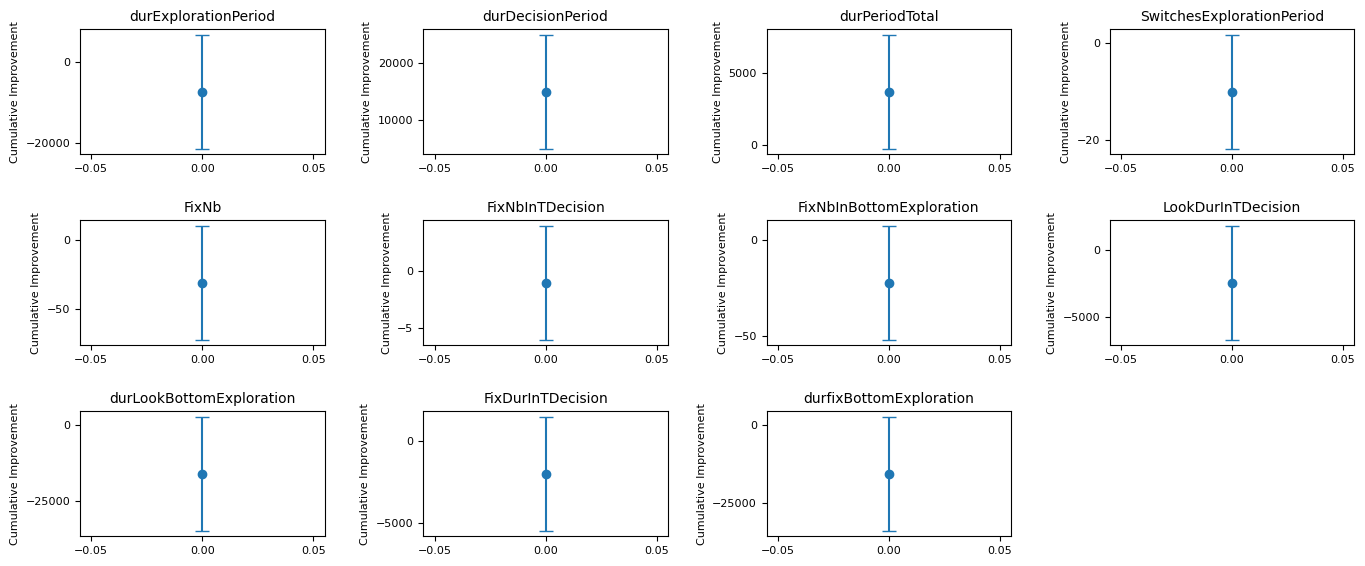

Variable: durExplorationPeriod
  Cumulative Median Change = -7363.0, Cumulative Mean Change = -15973.851922587217

Variable: durDecisionPeriod
  Cumulative Median Change = 14942.0, Cumulative Mean Change = 9730.913827349123

Variable: durPeriodTotal
  Cumulative Median Change = 3685.0, Cumulative Mean Change = -6242.938095238096

Variable: SwitchesExplorationPeriod
  Cumulative Median Change = -10.0, Cumulative Mean Change = -12.532015533486122

Variable: FixNb
  Cumulative Median Change = -31.0, Cumulative Mean Change = -49.08543417366947

Variable: FixNbInTDecision
  Cumulative Median Change = -1.0, Cumulative Mean Change = -8.175490196078432

Variable: FixNbInBottomExploration
  Cumulative Median Change = -22.5, Cumulative Mean Change = -41.69412401324166

Variable: LookDurInTDecision
  Cumulative Median Change = -2452.0, Cumulative Mean Change = -5970.062846956964

Variable: durLookBottomExploration
  Cumulative Median Change = -15984.0, Cumulative Mean Change = -20515.021708683475

In [26]:
#Check if babies tend to improve or not (cumulative change per variable)

variables = [
    'durExplorationPeriod',
    'durDecisionPeriod',
    'durPeriodTotal',
    'SwitchesExplorationPeriod',
    'FixNb',
    'FixNbInTDecision', 
    'FixNbInBottomExploration',
    'LookDurInTDecision', 
    'durLookBottomExploration', 
    'FixDurInTDecision', 
    'durfixBottomExploration'
]

change_medians = []
change_means = []

confidence_level = 0.95

# Calculate cumulative changes
cumulative_change_medians = []
cumulative_change_means = []

# Plots
plt.figure(figsize=(14, 6))

for i, variable in enumerate(variables, start=1):
    same_difficulty_data[f'{variable}_diff'] = same_difficulty_data.groupby('session')[variable].diff()
    first_trials = same_difficulty_data.groupby('session')['trialno'].transform('min')
    same_difficulty_data.loc[same_difficulty_data['trialno'] == first_trials, f'{variable}_diff'] = pd.NA
    same_difficulty_data.loc[(same_difficulty_data['trialno'].shift(1) != same_difficulty_data['trialno'] - 1) & (same_difficulty_data['trialno'] != first_trials), f'{variable}_diff'] = pd.NA

    median_diff = same_difficulty_data.groupby('session')[f'{variable}_diff'].median()
    mean_diff = same_difficulty_data.groupby('session')[f'{variable}_diff'].mean()

    change_median = np.median(median_diff)
    change_mean = np.mean(mean_diff)
    
    change_medians.append(change_median)
    change_means.append(change_mean)

    # Calculate cumulative change
    cumulative_change_median = median_diff.sum()
    cumulative_change_mean = mean_diff.sum()
    
    cumulative_change_medians.append(cumulative_change_median)
    cumulative_change_means.append(cumulative_change_mean)

    # Calculate confidence interval for the median differences
    ci_median = np.percentile(median_diff.dropna(), [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])
    # Calculate the standard error of the mean (SEM)
    sem = np.std(mean_diff) / np.sqrt(len(mean_diff.dropna()))
    ci_mean = [change_mean - sem * 1.96, change_mean + sem * 1.96]

    plt.subplot(3, 4, i)
    plt.errorbar(x=[0], y=[cumulative_change_median],
                 yerr=np.abs([ci_median[1] - cumulative_change_median]),  
                 fmt='o', capsize=5)
    plt.title(variable, fontsize=10)
    plt.ylabel('Cumulative Improvement', fontsize=8)  
    plt.xticks(fontsize=8)  
    plt.yticks(fontsize=8)  

plt.tight_layout()
plt.show()

# Mean and median cumulative improvement
for variable, median_cumulative, mean_cumulative in zip(variables, cumulative_change_medians, cumulative_change_means):
    print(f'Variable: {variable}')
    print(f'  Cumulative Median Change = {median_cumulative}, Cumulative Mean Change = {mean_cumulative}')
    print()

Variable: durExplorationPeriod
  Shapiro-Wilk p-values: Prior Accuracy 0 = 0.5162721557415872, Prior Accuracy 1 = 0.007089592570179075
  Levene p-value: 0.9282183858194272
  Kruskal-Wallis p-value: 0.06477774358863855
  Prior Accuracy = 0: Median Change = 416.0, Mean Change = 418.61574239713775
  Prior Accuracy = 1: Median Change = -438.0, Mean Change = -1181.9916666666666

Variable: durDecisionPeriod
  Shapiro-Wilk p-values: Prior Accuracy 0 = 0.0002738621096384487, Prior Accuracy 1 = 1.4275850935814404e-06
  Levene p-value: 0.9448600826917604
  Kruskal-Wallis p-value: 0.6805234855934763
  Prior Accuracy = 0: Median Change = 73.0, Mean Change = 95.15670840787122
  Prior Accuracy = 1: Median Change = 62.5, Mean Change = 454.0166666666666

Variable: durPeriodTotal
  Shapiro-Wilk p-values: Prior Accuracy 0 = 0.22345333355722768, Prior Accuracy 1 = 0.46439561703371307
  Levene p-value: 0.9921174947221846
  Kruskal-Wallis p-value: 0.17706179605882616
  Prior Accuracy = 0: Median Change = 2

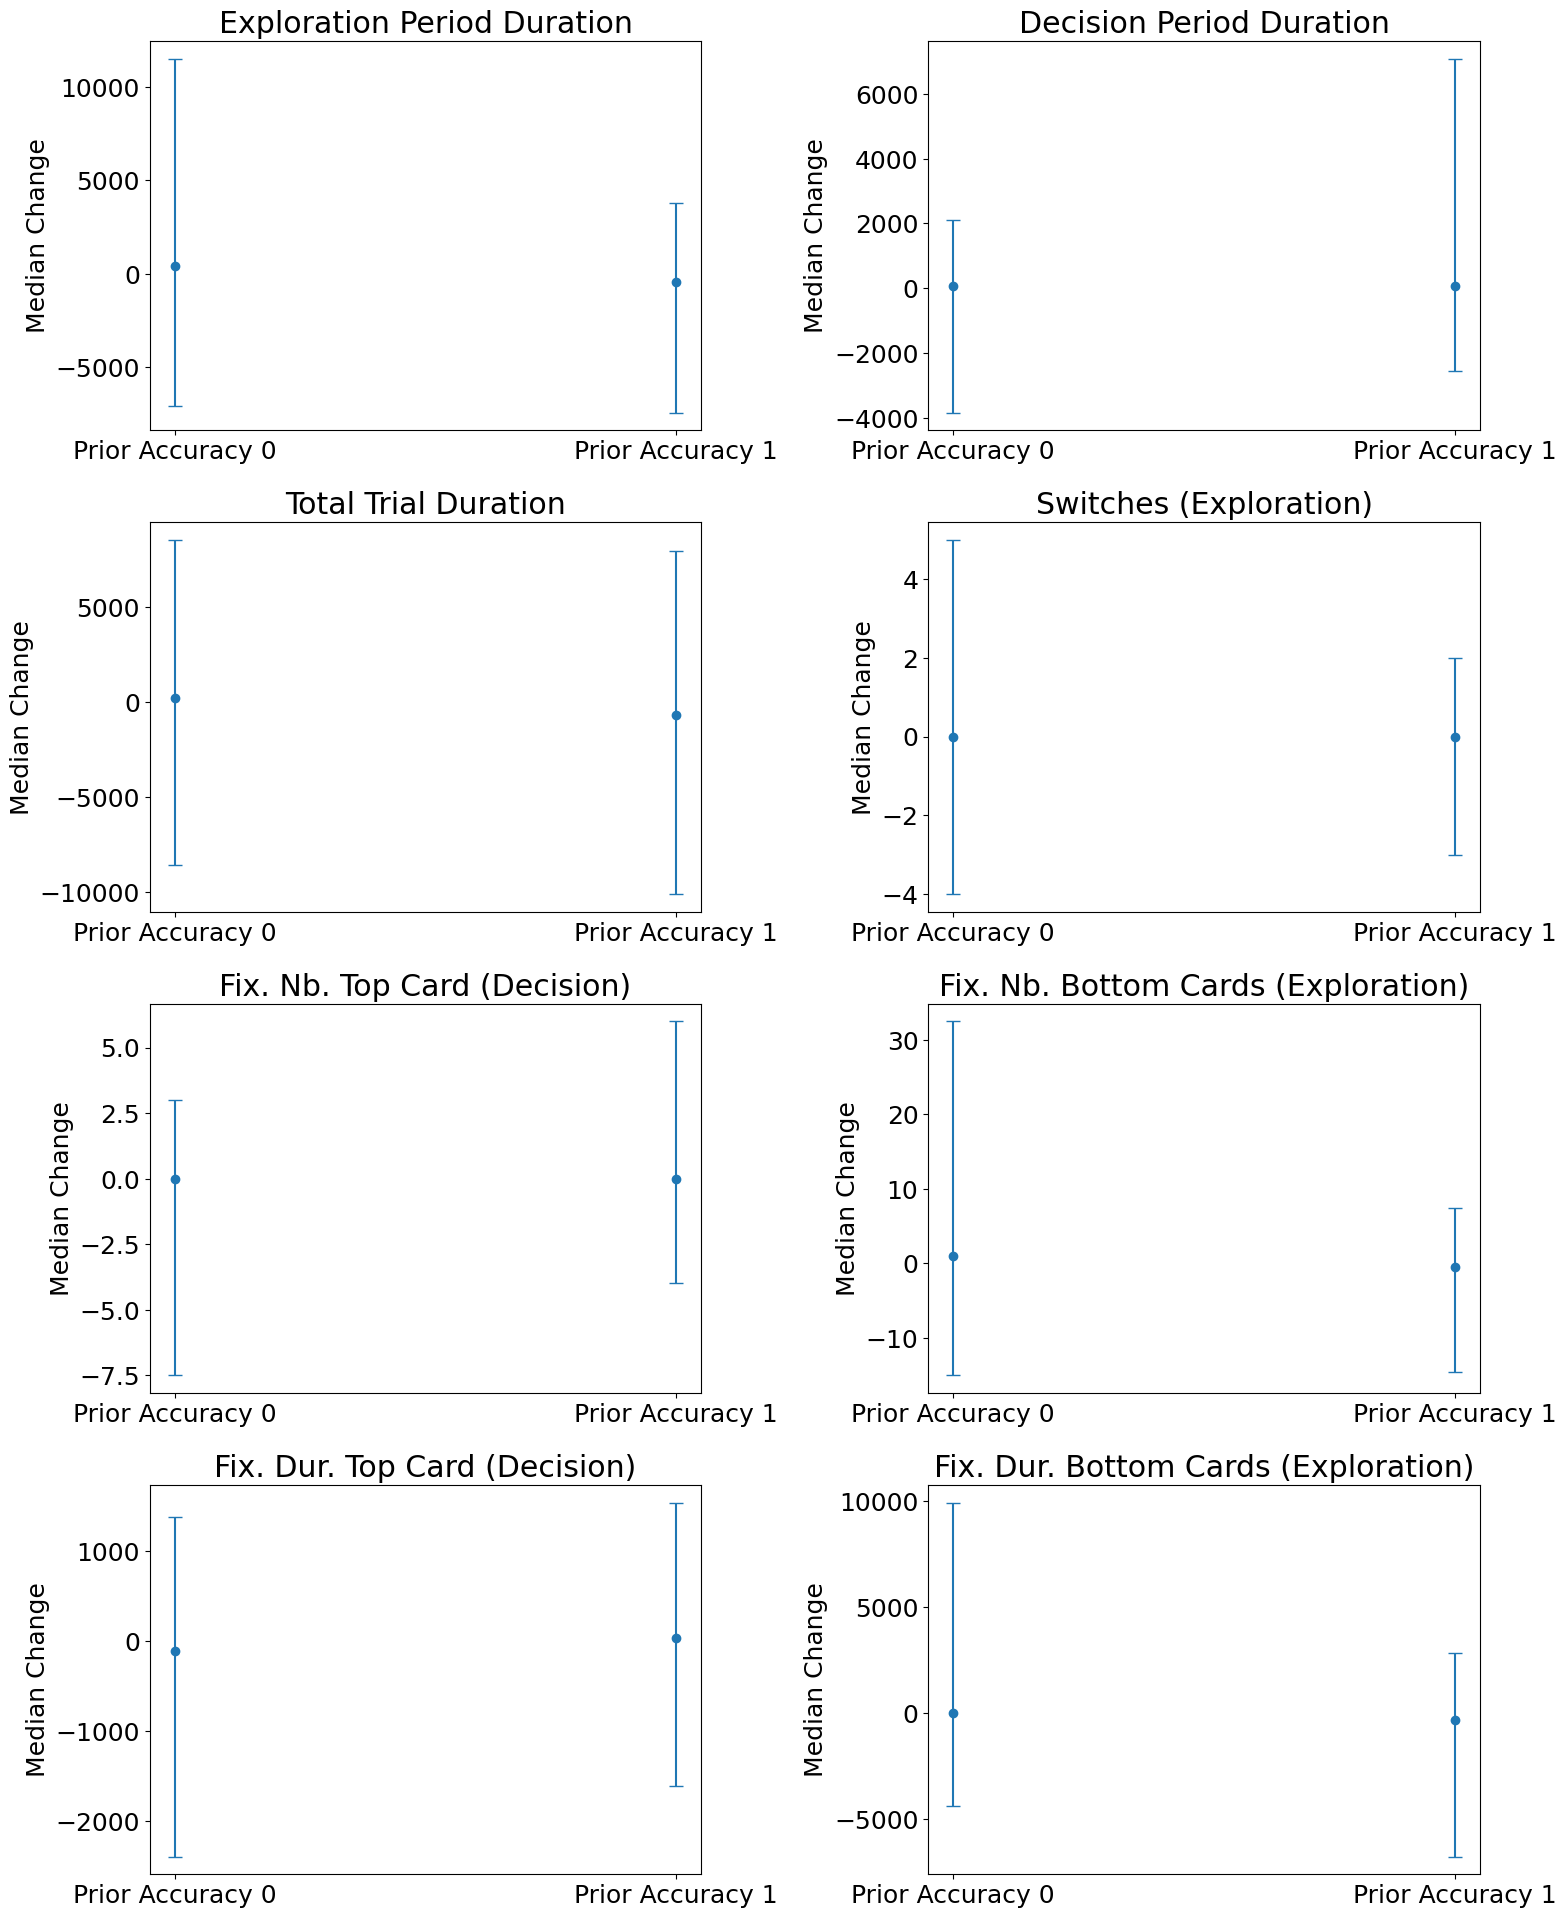

In [30]:
# Check if babies tend to change for each variable depending on prior accuracy 

def custom_percentile(data, confidence_level):
    data_sorted = np.sort(data.dropna())
    n = len(data_sorted)
    lower_index = int((1 - confidence_level) / 2 * n)
    upper_index = int((1 + confidence_level) / 2 * n)
    return data_sorted[lower_index], np.median(data_sorted), data_sorted[upper_index]

variables = [
    'durExplorationPeriod',
    'durDecisionPeriod',
    'durPeriodTotal',
    'SwitchesExplorationPeriod',
    'FixNbInTDecision', 
    'FixNbInBottomExploration',
    'FixDurInTDecision', 
    'durfixBottomExploration'
]

change_0_medians = []
change_1_medians = []
change_0_means = []
change_1_means = []

confidence_level = 0.95

num_variables = len(variables)
num_rows = (num_variables + 2) // 2  

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(16, 24))

titles = [
    'Exploration Period Duration',
    'Decision Period Duration',
    'Total Trial Duration',
    'Switches (Exploration)',
    'Fix. Nb. Top Card (Decision)',
    'Fix. Nb. Bottom Cards (Exploration)',
    'Fix. Dur. Top Card (Decision)',
    'Fix. Dur. Bottom Cards (Exploration)'
]

for i, variable in enumerate(variables, start=1):
    
    data_reset = same_difficulty_data.reset_index(drop=True)
    data_reset[f'{variable}_diff'] = data_reset.groupby('session')[variable].diff()
    data_reset.loc[data_reset['trialno'].diff() != 1, f'{variable}_diff'] = np.nan
    data_filtered = data_reset.dropna(subset=[f'{variable}_diff'])
    
    data_0 = data_filtered[data_filtered['prior_accuracy'] == 0]
    data_1 = data_filtered[data_filtered['prior_accuracy'] == 1]
   
    median_diff_0 = data_0.groupby('session')[f'{variable}_diff'].median()
    mean_diff_0 = data_0.groupby('session')[f'{variable}_diff'].mean()
    median_diff_1 = data_1.groupby('session')[f'{variable}_diff'].median()
    mean_diff_1 = data_1.groupby('session')[f'{variable}_diff'].mean()

    change_0_median = np.nanmedian(median_diff_0)
    change_1_median = np.nanmedian(median_diff_1)
    change_0_mean = np.nanmean(mean_diff_0)
    change_1_mean = np.nanmean(mean_diff_1)

    change_0_medians.append(change_0_median)
    change_1_medians.append(change_1_median)
    change_0_means.append(change_0_mean)
    change_1_means.append(change_1_mean)

    # Shapiro-Wilk test 
    _, shapiro_p_0 = shapiro(median_diff_0.dropna())
    _, shapiro_p_1 = shapiro(median_diff_1.dropna())
    
    # Levene's test 
    _, levene_p = levene(median_diff_0.dropna(), median_diff_1.dropna())
    
    # Kruskal-Wallis test 
    _, kruskal_p = kruskal(median_diff_0.dropna(), median_diff_1.dropna())

    ci_0 = custom_percentile(median_diff_0, confidence_level)
    ci_1 = custom_percentile(median_diff_1, confidence_level)

    # Use different title for each plot
    title = titles[i-1]
    
    plt.subplot(num_rows, 2, i)
    plt.errorbar(x=[0, 1], y=[change_0_median, change_1_median],
                 yerr=[[change_0_median - ci_0[0], ci_0[2] - change_0_median],
                       [change_1_median - ci_1[0], ci_1[2] - change_1_median]],
                 fmt='o', capsize=5)
    plt.title(title)
    plt.xticks([0, 1], ['Prior Accuracy 0', 'Prior Accuracy 1'])
    plt.ylabel('Median Change')

    # Print test results
    print(f'Variable: {variable}')
    print(f'  Shapiro-Wilk p-values: Prior Accuracy 0 = {shapiro_p_0}, Prior Accuracy 1 = {shapiro_p_1}')
    print(f'  Levene p-value: {levene_p}')
    print(f'  Kruskal-Wallis p-value: {kruskal_p}')
    print(f'  Prior Accuracy = 0: Median Change = {change_0_median}, Mean Change = {change_0_mean}')
    print(f'  Prior Accuracy = 1: Median Change = {change_1_median}, Mean Change = {change_1_mean}')
    print()

plt.tight_layout()
plt.show()

Cluster: Cluster 1
Variable: durExplorationPeriod
  Shapiro-Wilk p-values: Prior Accuracy 0 = 0.8329318035058754, Prior Accuracy 1 = 0.009234535252633314
  Levene p-value: 0.967251692639586
  Kruskal-Wallis p-value: 0.1037971474004618
  Prior Accuracy = 0: Median Change = 980.0, Mean Change = 1144.6407407407407
  Prior Accuracy = 1: Median Change = -324.0, Mean Change = -1099.95

Cluster: Cluster 1
Variable: durDecisionPeriod
  Shapiro-Wilk p-values: Prior Accuracy 0 = 0.004031415820647151, Prior Accuracy 1 = 0.0017002647955512674
  Levene p-value: 0.7618234010715891
  Kruskal-Wallis p-value: 0.2634291316383083
  Prior Accuracy = 0: Median Change = 262.5, Mean Change = 494.3962962962962
  Prior Accuracy = 1: Median Change = 33.0, Mean Change = 190.50972222222222

Cluster: Cluster 1
Variable: durPeriodTotal
  Shapiro-Wilk p-values: Prior Accuracy 0 = 0.4668581873294331, Prior Accuracy 1 = 0.06338641845037635
  Levene p-value: 0.8354295804970365
  Kruskal-Wallis p-value: 0.07521517528286

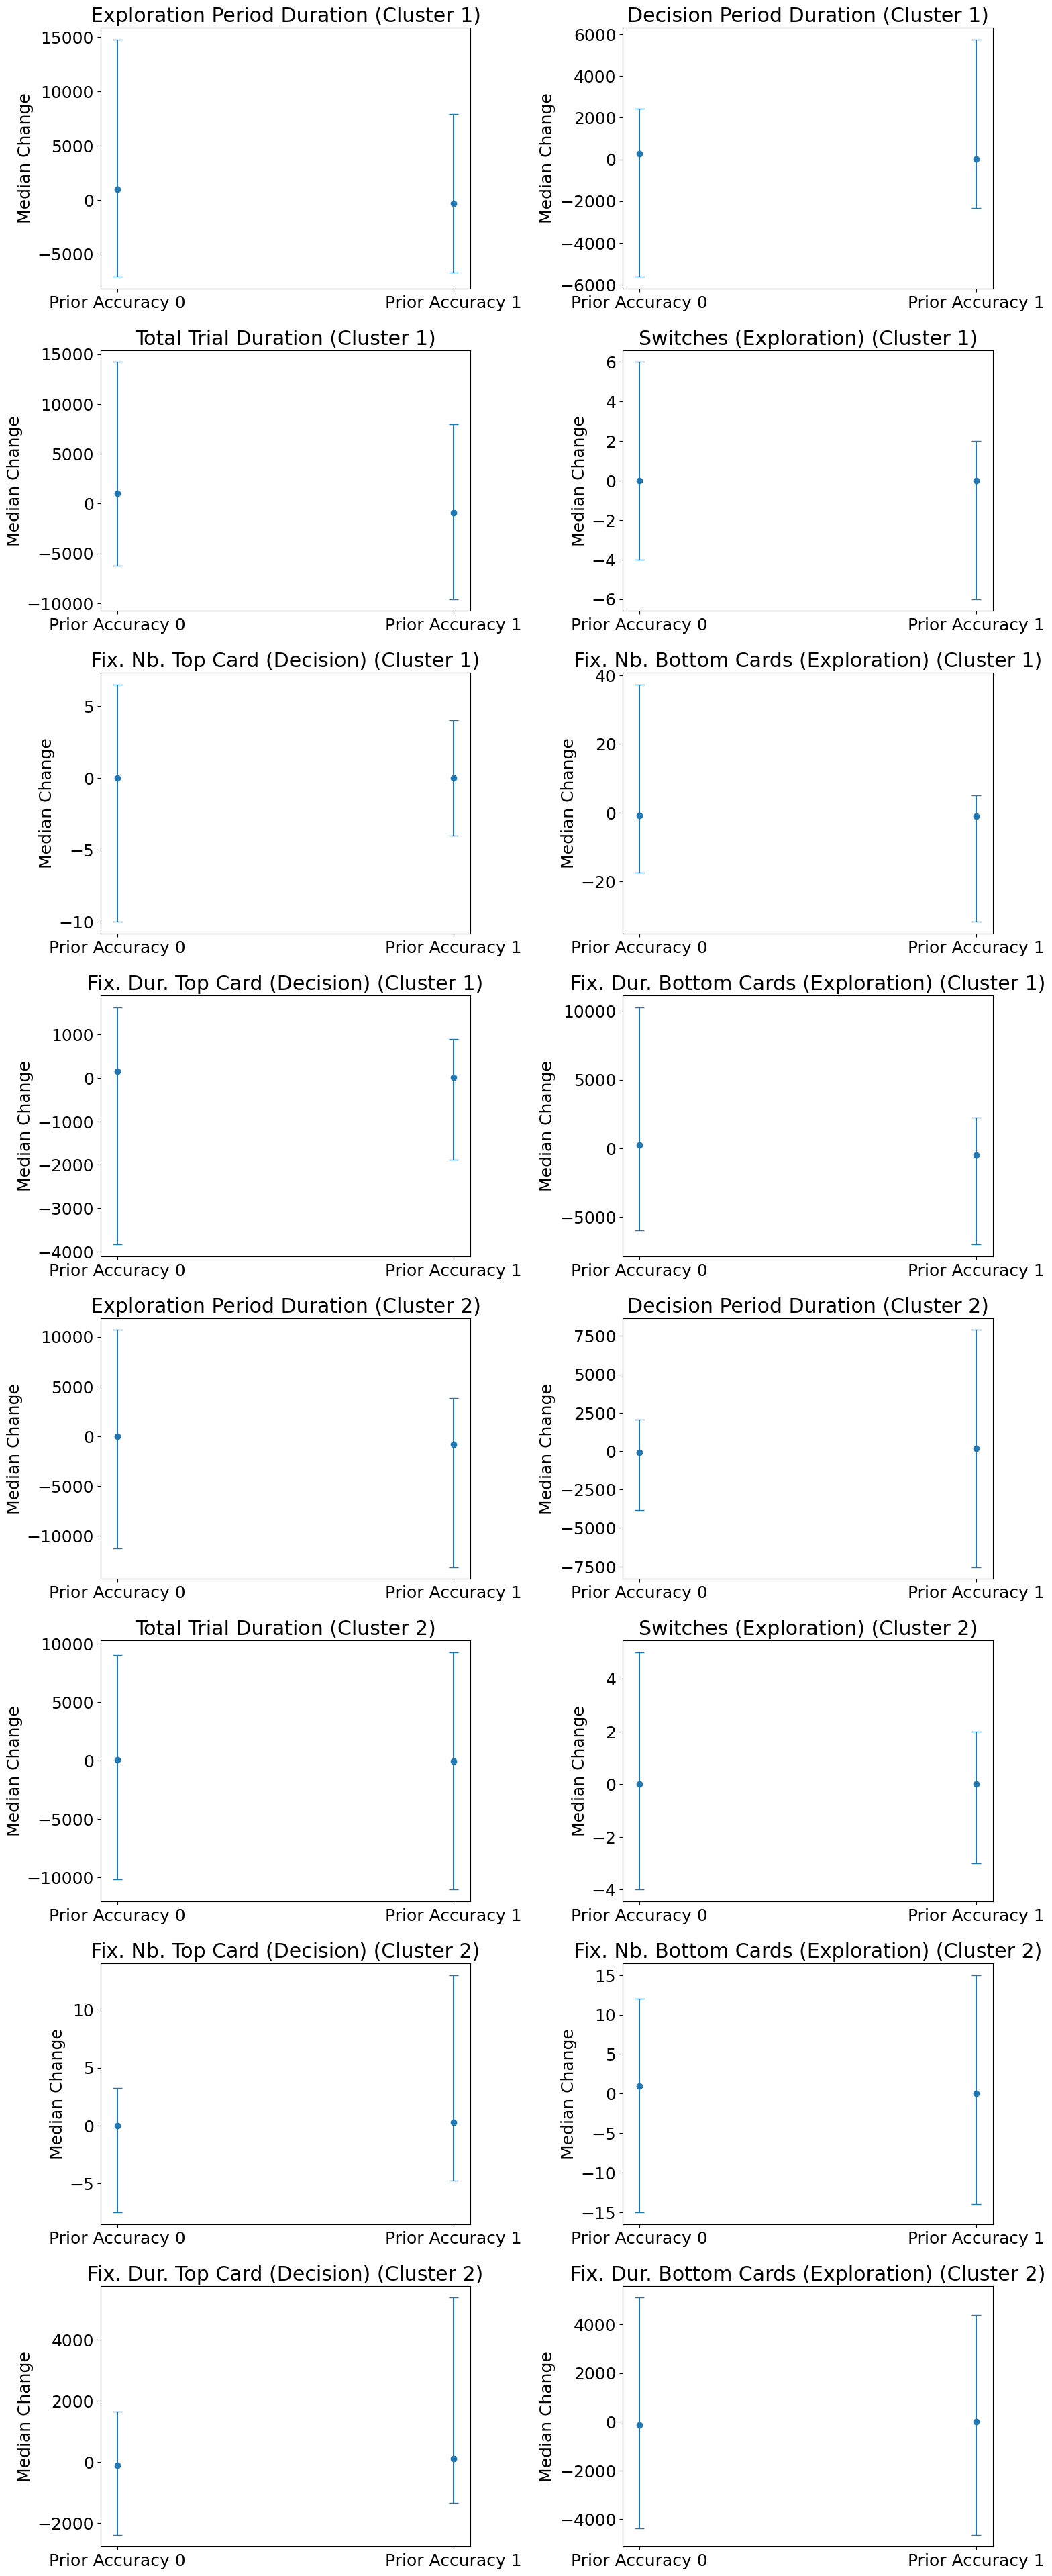

In [31]:
#Same analysis but for each cluster

def custom_percentile(data, confidence_level):
    data_sorted = np.sort(data.dropna())
    n = len(data_sorted)
    lower_index = int((1 - confidence_level) / 2 * n)
    upper_index = int((1 + confidence_level) / 2 * n)
    return data_sorted[lower_index], np.median(data_sorted), data_sorted[upper_index]

variables = [
    'durExplorationPeriod',
    'durDecisionPeriod',
    'durPeriodTotal',
    'SwitchesExplorationPeriod',
    'FixNbInTDecision', 
    'FixNbInBottomExploration',
    'FixDurInTDecision', 
    'durfixBottomExploration'
]

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE040a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE076a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

clusters = [sessions_cluster_1, sessions_cluster_2]
cluster_titles = ['Cluster 1', 'Cluster 2']

confidence_level = 0.95

num_variables = len(variables)
num_rows = (num_variables + 2) // 2  

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(16, 48))

titles = [
    'Exploration Period Duration',
    'Decision Period Duration',
    'Total Trial Duration',
    'Switches (Exploration)',
    'Fix. Nb. Top Card (Decision)',
    'Fix. Nb. Bottom Cards (Exploration)',
    'Fix. Dur. Top Card (Decision)',
    'Fix. Dur. Bottom Cards (Exploration)'
]

for c_idx, cluster in enumerate(clusters):
    cluster_data = same_difficulty_data[same_difficulty_data['session'].isin(cluster)]
    change_0_medians = []
    change_1_medians = []
    change_0_means = []
    change_1_means = []

    for i, variable in enumerate(variables, start=1):
        
        data_reset = cluster_data.reset_index(drop=True)
        data_reset[f'{variable}_diff'] = data_reset.groupby('session')[variable].diff()
        data_reset.loc[data_reset['trialno'].diff() != 1, f'{variable}_diff'] = np.nan
        data_filtered = data_reset.dropna(subset=[f'{variable}_diff'])
        
        data_0 = data_filtered[data_filtered['prior_accuracy'] == 0]
        data_1 = data_filtered[data_filtered['prior_accuracy'] == 1]
       
        median_diff_0 = data_0.groupby('session')[f'{variable}_diff'].median()
        mean_diff_0 = data_0.groupby('session')[f'{variable}_diff'].mean()
        median_diff_1 = data_1.groupby('session')[f'{variable}_diff'].median()
        mean_diff_1 = data_1.groupby('session')[f'{variable}_diff'].mean()

        change_0_median = np.nanmedian(median_diff_0)
        change_1_median = np.nanmedian(median_diff_1)
        change_0_mean = np.nanmean(mean_diff_0)
        change_1_mean = np.nanmean(mean_diff_1)

        change_0_medians.append(change_0_median)
        change_1_medians.append(change_1_median)
        change_0_means.append(change_0_mean)
        change_1_means.append(change_1_mean)

        # Shapiro-Wilk test 
        _, shapiro_p_0 = shapiro(median_diff_0.dropna())
        _, shapiro_p_1 = shapiro(median_diff_1.dropna())
        
        # Levene's test 
        _, levene_p = levene(median_diff_0.dropna(), median_diff_1.dropna())
        
        # Kruskal-Wallis test 
        _, kruskal_p = kruskal(median_diff_0.dropna(), median_diff_1.dropna())

        ci_0 = custom_percentile(median_diff_0, confidence_level)
        ci_1 = custom_percentile(median_diff_1, confidence_level)

        # Use different title for each plot
        title = titles[i-1] + ' (' + cluster_titles[c_idx] + ')'
        
        plt.subplot(num_rows * 2, 2, (c_idx * num_variables + i))
        plt.errorbar(x=[0, 1], y=[change_0_median, change_1_median],
                     yerr=[[change_0_median - ci_0[0], ci_0[2] - change_0_median],
                           [change_1_median - ci_1[0], ci_1[2] - change_1_median]],
                     fmt='o', capsize=5)
        plt.title(title)
        plt.xticks([0, 1], ['Prior Accuracy 0', 'Prior Accuracy 1'])
        plt.ylabel('Median Change')

        # Print test results
        print(f'Cluster: {cluster_titles[c_idx]}')
        print(f'Variable: {variable}')
        print(f'  Shapiro-Wilk p-values: Prior Accuracy 0 = {shapiro_p_0}, Prior Accuracy 1 = {shapiro_p_1}')
        print(f'  Levene p-value: {levene_p}')
        print(f'  Kruskal-Wallis p-value: {kruskal_p}')
        print(f'  Prior Accuracy = 0: Median Change = {change_0_median}, Mean Change = {change_0_mean}')
        print(f'  Prior Accuracy = 1: Median Change = {change_1_median}, Mean Change = {change_1_mean}')
        print()

plt.tight_layout()
plt.show()

In [32]:
#ANOVA where the data is normally distributed and the variances are equal across groups.
from scipy.stats import f_oneway

# Cluster 1: durPeriodTotal
dur_total_0_cluster1 = cluster_data[(cluster_data['prior_accuracy'] == 0)]['durPeriodTotal_diff'].dropna()
dur_total_1_cluster1 = cluster_data[(cluster_data['prior_accuracy'] == 1)]['durPeriodTotal_diff'].dropna()

# Cluster 2: durPeriodTotal, durExplorationPeriod, FixNbInBottomExploration, durfixBottomExploration
dur_total_0_cluster2 = cluster_data[(cluster_data['prior_accuracy'] == 0)]['durPeriodTotal_diff'].dropna()
dur_total_1_cluster2 = cluster_data[(cluster_data['prior_accuracy'] == 1)]['durPeriodTotal_diff'].dropna()

dur_exp_0_cluster2 = cluster_data[(cluster_data['prior_accuracy'] == 0)]['durExplorationPeriod_diff'].dropna()
dur_exp_1_cluster2 = cluster_data[(cluster_data['prior_accuracy'] == 1)]['durExplorationPeriod_diff'].dropna()

fix_bottom_0_cluster2 = cluster_data[(cluster_data['prior_accuracy'] == 0)]['FixNbInBottomExploration_diff'].dropna()
fix_bottom_1_cluster2 = cluster_data[(cluster_data['prior_accuracy'] == 1)]['FixNbInBottomExploration_diff'].dropna()

dur_fix_bottom_0_cluster2 = cluster_data[(cluster_data['prior_accuracy'] == 0)]['durfixBottomExploration_diff'].dropna()
dur_fix_bottom_1_cluster2 = cluster_data[(cluster_data['prior_accuracy'] == 1)]['durfixBottomExploration_diff'].dropna()

# Perform ANOVA
anova_dur_total_cluster1 = f_oneway(dur_total_0_cluster1, dur_total_1_cluster1)
anova_dur_total_cluster2 = f_oneway(dur_total_0_cluster2, dur_total_1_cluster2)
anova_dur_exp_cluster2 = f_oneway(dur_exp_0_cluster2, dur_exp_1_cluster2)
anova_fix_bottom_cluster2 = f_oneway(fix_bottom_0_cluster2, fix_bottom_1_cluster2)
anova_dur_fix_bottom_cluster2 = f_oneway(dur_fix_bottom_0_cluster2, dur_fix_bottom_1_cluster2)

# Print ANOVA results
print("Cluster 1:")
print("ANOVA for durPeriodTotal:", anova_dur_total_cluster1)

print("\nCluster 2:")
print("ANOVA for durPeriodTotal:", anova_dur_total_cluster2)
print("ANOVA for durExplorationPeriod:", anova_dur_exp_cluster2)
print("ANOVA for FixNbInBottomExploration:", anova_fix_bottom_cluster2)
print("ANOVA for durfixBottomExploration:", anova_dur_fix_bottom_cluster2)


Cluster 1:
ANOVA for durPeriodTotal: F_onewayResult(statistic=0.06305422465018572, pvalue=0.8022373232123621)

Cluster 2:
ANOVA for durPeriodTotal: F_onewayResult(statistic=0.06305422465018572, pvalue=0.8022373232123621)
ANOVA for durExplorationPeriod: F_onewayResult(statistic=0.5905702032268252, pvalue=0.44397435389081474)
ANOVA for FixNbInBottomExploration: F_onewayResult(statistic=0.5336890487322018, pvalue=0.4667347111965662)
ANOVA for durfixBottomExploration: F_onewayResult(statistic=0.27933656639975907, pvalue=0.5982845102192258)


In [7]:
# Dataset with difference among variables trial by trial

#variables = [
#    'durExplorationPeriod',
#    'durDecisionPeriod',
#    'durPeriodTotal',
#    'SwitchesExplorationPeriod',
#    'FixNb',
#    'FixNbInTDecision', 
#    'FixNbInBottomExploration',
#   'LookDurInTDecision', 
#    'durLookBottomExploration', 
#    'FixDurInTDecision', 
#    'durfixBottomExploration'
#]

#for variable in variables:
#    # Calculate the change between consecutive trials
#    data[f'{variable}_change'] = (data.groupby('session')[variable]
#                                      .diff()
#                                    )
    
    # Identify the first trial for each session
#    first_trials = data.groupby('session')['trialno'].transform('min')
    
    # Set change to NaN for the first trial of each session
#    data.loc[data['trialno'] == first_trials, f'{variable}_change'] = pd.NA

    # Set change to NaN for trials that don't have a directly preceding trial
#    data.loc[(data['trialno'].shift(1) != data['trialno'] - 1) & (data['trialno'] != first_trials), f'{variable}_change'] = pd.NA

#pd.set_option('display.max_rows', None)
#data

session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
0    curE002a        8       Easy       0.0       left           12194   
1    curE002a        9       Easy       1.0       left            4680   
2    curE002a       10       Easy       1.0      right           12826   
3    curE002a       11     Medium       1.0      right            3910   
4    curE002a       12     Medium       0.0       left           15256   
5    curE002a       13     Medium       1.0       left           15846   
6    curE002a       14     Medium       0.0       left            6926   
7    curE002a       19     Medium       0.0       left            7128   
8    curE002a       20     Medium       0.0      right            9080   
9    curE002a       21       Easy       1.0       left            7046   
10   curE002a       24       Easy       1.0      right            6430   
11   curE002a       25       Easy       1.0      right            5098   
12   curE003a       21     Medium       1.0       left            9776   
13   curE003a       22     Medium       0.0       left            6094   
14   curE003a       25     Medium       0.0       left           13108   
15   curE003a       26     Medium       1.0      right            7096   
16   curE003a       31     Medium       0.0       left           18692   
17   curE003a       32     Medium       0.0       left           22874   
18   curE003a       33       Easy       1.0       left           11308   
19   curE004a        8       Easy       1.0       left           10108   
20   curE004a        9       Easy       1.0       left            4850   
21   curE004a       10     Medium       0.0       left           12544   
22   curE004a       13       Easy       0.0      right            6314   
23   curE004a       14       Easy       1.0      right            5698   
24   curE004a       15       Easy       1.0       left           21272   
25   curE004a       16     Medium       1.0      right            8030   
26   curE004a       28     Medium       1.0       left           11112   
27   curE004a       29     Medium       0.0       left            5308   
28   curE004a       41       Easy       1.0      right            7948   
29   curE004a       42       Easy       1.0       left            3728   
30   curE004a       45     Medium       1.0      right           10542   
31   curE004a       46     Medium       0.0       left            4898   
32   curE004a       47     Medium       0.0      right            6658   
33   curE004a       52       Easy       0.0      right           10180   
34   curE004a       53       Easy       1.0       left            7808   
35   curE004a       54       Easy       0.0       left            3092   
36   curE004a       55       Easy       0.0      right           16510   
37   curE004a       56       Easy       1.0       left           14574   
38   curE004a       57       Easy       0.0       left            6948   
39   curE004a       58       Easy       0.0       left            9978   
40   curE004a       64       Easy       0.0       left           11594   
41   curE004a       65       Easy       1.0       left           14604   
42   curE008a        9       Easy       0.0      right           17042   
43   curE008a       10       Easy       0.0       left           12808   
44   curE008a       11       Easy       1.0       left            8930   
45   curE008a       12       Easy       1.0       left            9298   
46   curE008a       13     Medium       1.0       left           13062   
47   curE008a       14     Medium       0.0       left           15094   
48   curE008a       15     Medium       0.0       left            7228   
49   curE008a       17       Easy       0.0      right            8564   
50   curE008a       18       Easy       1.0       left           17410   
51   curE008a       20       Easy       0.0       left           16376   
52   curE008a       21       Easy       0.0       left            5198   
53   curE0

In [18]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durPeriodTotal
# Distribution: normal

data.dropna(inplace=True)

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

scaler = StandardScaler()
data['scaled_durPeriodTotal_change'] = scaler.fit_transform(data[['durPeriodTotal_change']])

formula = 'scaled_durPeriodTotal_change ~ prior_accuracy + (1 + prior_accuracy | session)' #random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['scaled_durPeriodTotal_change']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_durPeriodTotal_change
No. Observations: 674     Method:             REML                        
No. Groups:       73      Scale:              1.0012                      
Min. group size:  1       Log-Likelihood:     -964.7720                   
Max. group size:  32      Converged:          No                          
Mean group size:  9.2                                                     
---------------------------------------------------------------------------
                            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                   -0.049     0.084  -0.590  0.555  -0.213   0.115
prior_accuracy              -0.052     0.077  -0.676  0.499  -0.204   0.099
prior_accuracy | session     0.002     0.002   1.276  0.202  -0.001   0.006
Group Var                    0.001    

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 7.714476
  warnings.warn(msg, ConvergenceWarning)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regr

In [31]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durDecisionPeriod
# Distribution: pareto

data['prior_accuracy'] = data['prior_accuracy'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

scaler = StandardScaler()
data['scaled_durDecisionPeriod_change'] = scaler.fit_transform(data[['durDecisionPeriod_change']]) #scaling durDecisionPeriod 

formula = 'scaled_durDecisionPeriod_change ~ prior_accuracy + (1 + prior_accuracy | session)' #Random intercept and random slope 

mixed_model = smf.mixedlm(formula, data, groups=data['session'])
result = mixed_model.fit()

predicted_values = result.predict()

observed_values = data['scaled_durDecisionPeriod_change']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_durDecisionPeriod_change
No. Observations: 198     Method:             REML                           
No. Groups:       65      Scale:              0.7789                         
Min. group size:  1       Log-Likelihood:     -283.9381                      
Max. group size:  11      Converged:          Yes                            
Mean group size:  3.0                                                        
-------------------------------------------------------------------------------
                           Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------------------
Intercept                   0.092      0.205    0.450   0.653   -0.310    0.495
prior_accuracy             -0.139      0.138   -1.013   0.311   -0.409    0.130
prior_accuracy | session    0.001      0.005    0.176   0.860   -0.010    